In [571]:
import pandas as pd
import numpy as np
import statistics
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
from autoimpute.utils.patterns import proportions

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

import lightgbm as lgb

import gc

from df_cleaner import train_analysis
from df_cleaner import utils
from df_cleaner import generate_test
from df_cleaner import dataframe_group
from Fix_Transform import New_Attributes
from Fix_Transform import No_Out

analizer = train_analysis()
tools = utils()
from header import P_TRAIN, P_TEST
from header import P_SUMMARY
from header import P_BUREAU_BAL, P_BUREAU, P_CREDITCARD, P_HOMECREDIT, P_INSTALLMENTS, P_POS, P_APPLICATION, P_SUBMISSION

# PART I: FIRST FEATURE SELECTION

# Get all possible information about the DFs and save in txt file:

In [6]:
homecredit = pd.read_csv(P_HOMECREDIT, encoding = "windows-1252")
homecredit.head()

Unnamed: 0                         Table                 Row  \
0           1  application_{train|test}.csv          SK_ID_CURR   
1           2  application_{train|test}.csv              TARGET   
2           5  application_{train|test}.csv  NAME_CONTRACT_TYPE   
3           6  application_{train|test}.csv         CODE_GENDER   
4           7  application_{train|test}.csv        FLAG_OWN_CAR   

                                         Description Special  
0                           ID of loan in our sample     NaN  
1  Target variable (1 - client with payment diffi...     NaN  
2        Identification if loan is cash or revolving     NaN  
3                               Gender of the client     NaN  
4                      Flag if the client owns a car     NaN

In [7]:
# Define some variables:

summary = open(P_SUMMARY, "w") # a file .txt where we put all the lines we need
old_table = homecredit["Table"][0].capitalize() # To check if we still getting info from a DF or it has canhed
summary.write("".join([old_table + "\n\n"]))

# Start to create the file:

for i in range(len(homecredit)):
    
    # Get the info we need from the DF:
    
    table = homecredit["Table"][i].capitalize()
    col = homecredit["Row"][i]
    description = homecredit["Description"][i] 
    
    # Add the info:
    
    if old_table == table:
        
        line = col + ":" + "\t" + description + "\n"
        summary.write(line)
    
    else:
        
        summary.write("\n\n")
        new_table = table + "\n\n"
        summary.write(new_table)
        
        line = col + ":" + "\t" + description + "\n"
        summary.write(line)
        
        old_table = table

# Work on Train and Test:

## 1) Train:

In [8]:
train = pd.read_csv(P_TRAIN)
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  

[5 rows x 122 columns]

### NaN analysis:

As we can see the attributes with more NaNs are the ones with information about The building, so let's see if there is a correlation between who didn't give this information and the likelyhood to repay the loan.

In [9]:
# Let's visualize how Nan are distributed along the DF:

In [10]:
pd.set_option('display.max_rows', None)
checkna = proportions(train)
checkna.columns = ["NAN %", "Observed %"]
checkna[checkna["NAN %"] > 0.40]

NAN %  Observed %
OWN_CAR_AGE                   0.659908    0.340092
EXT_SOURCE_1                  0.563811    0.436189
APARTMENTS_AVG                0.507497    0.492503
BASEMENTAREA_AVG              0.585160    0.414840
YEARS_BEGINEXPLUATATION_AVG   0.487810    0.512190
YEARS_BUILD_AVG               0.664978    0.335022
COMMONAREA_AVG                0.698723    0.301277
ELEVATORS_AVG                 0.532960    0.467040
ENTRANCES_AVG                 0.503488    0.496512
FLOORSMAX_AVG                 0.497608    0.502392
FLOORSMIN_AVG                 0.678486    0.321514
LANDAREA_AVG                  0.593767    0.406233
LIVINGAPARTMENTS_AVG          0.683550    0.316450
LIVINGAREA_AVG                0.501933    0.498067
NONLIVINGAPARTMENTS_AVG       0.694330    0.305670
NONLIVINGAREA_AVG             0.551792    0.448208
APARTMENTS_MODE               0.507497    0.492503
BASEMENTAREA_MODE             0.585160    0.414840
YEARS_BEGINEXPLUATATION_MODE  0.487810    0.512190
YEARS_BUILD_MODE              0.664978    0.335022
COMMONAREA_MODE               0.698723    0.301277
ELEVATORS_MODE                0.532960    0.467040
ENTRANCES_MODE                0.503488    0.496512
FLOORSMAX_MODE                0.497608    0.502392
FLOORSMIN_MODE                0.678486    0.321514
LANDAREA_MODE                 0.593767    0.406233
LIVINGAPARTMENTS_MODE         0.683550    0.316450
LIVINGAREA_MODE               0.501933    0.498067
NONLIVINGAPARTMENTS_MODE      0.694330    0.305670
NONLIVINGAREA_MODE            0.551792    0.448208
APARTMENTS_MEDI               0.507497    0.492503
BASEMENTAREA_MEDI             0.585160    0.414840
YEARS_BEGINEXPLUATATION_MEDI  0.487810    0.512190
YEARS_BUILD_MEDI              0.664978    0.335022
COMMONAREA_MEDI               0.698723    0.301277
ELEVATORS_MEDI                0.532960    0.467040
ENTRANCES_MEDI                0.503488    0.496512
FLOORSMAX_MEDI                0.497608    0.502392
FLOORSMIN_MEDI                0.678486    0.321514
LANDAREA_MEDI                 0.593767    0.406233
LIVINGAPARTMENTS_MEDI         0.683550    0.316450
LIVINGAREA_MEDI               0.501933    0.498067
NONLIVINGAPARTMENTS_MEDI      0.694330    0.305670
NONLIVINGAREA_MEDI            0.551792    0.448208
FONDKAPREMONT_MODE            0.683862    0.316138
HOUSETYPE_MODE                0.501761    0.498239
TOTALAREA_MODE                0.482685    0.517315
WALLSMATERIAL_MODE            0.508408    0.491592
EMERGENCYSTATE_MODE           0.473983    0.526017

In [11]:
pd.set_option('display.max_rows', 10)

### House information:

#### 1) Check which observations has less than 50% of nan

We create a new column (HOUSE_INFO) in which we specify wheather more than the 50% of are present or not.

In [12]:
# Generate a DF with only the house's information:

In [13]:
for i in train.columns:
    print('"{}"'.format(i), end = ", ")

"SK_ID_CURR", "TARGET", "NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE", "REGION_POPULATION_RELATIVE", "DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "OWN_CAR_AGE", "FLAG_MOBIL", "FLAG_EMP_PHONE", "FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS", "REGION_RATING_CLIENT", "REGION_RATING_CLIENT_W_CITY", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "REG_REGION_NOT_LIVE_REGION", "REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY", "REG_CITY_NOT_WORK_CITY", "LIVE_CITY_NOT_WORK_CITY", "ORGANIZATION_TYPE", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", "COMMONAREA_AVG", "ELEV

In [14]:
home_train = train[["APARTMENTS_AVG", "BASEMENTAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "YEARS_BUILD_AVG", 
                   "COMMONAREA_AVG", "ELEVATORS_AVG", "ENTRANCES_AVG", "FLOORSMAX_AVG", "FLOORSMIN_AVG", 
                   "LANDAREA_AVG", "LIVINGAPARTMENTS_AVG", "LIVINGAREA_AVG", "NONLIVINGAPARTMENTS_AVG", 
                   "NONLIVINGAREA_AVG", "APARTMENTS_MODE", "BASEMENTAREA_MODE", "YEARS_BEGINEXPLUATATION_MODE",
                   "YEARS_BUILD_MODE", "COMMONAREA_MODE", "ELEVATORS_MODE", "ENTRANCES_MODE", "FLOORSMAX_MODE", 
                   "FLOORSMIN_MODE", "LANDAREA_MODE", "LIVINGAPARTMENTS_MODE", "LIVINGAREA_MODE", 
                   "NONLIVINGAPARTMENTS_MODE", "NONLIVINGAREA_MODE", "APARTMENTS_MEDI", "BASEMENTAREA_MEDI", 
                   "YEARS_BEGINEXPLUATATION_MEDI", "YEARS_BUILD_MEDI", "COMMONAREA_MEDI", "ELEVATORS_MEDI", 
                   "ENTRANCES_MEDI", "FLOORSMAX_MEDI", "FLOORSMIN_MEDI", "LANDAREA_MEDI", "LIVINGAPARTMENTS_MEDI", 
                   "LIVINGAREA_MEDI", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAREA_MEDI", "FONDKAPREMONT_MODE", 
                   "HOUSETYPE_MODE", "TOTALAREA_MODE", "WALLSMATERIAL_MODE", "EMERGENCYSTATE_MODE"]].copy()

In [15]:
home_train.head()

APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  ...  LANDAREA_MEDI  \
0         0.0833         0.1250        0.0369  ...         0.0375   
1         0.2917         0.3333        0.0130  ...         0.0132   
2            NaN            NaN           NaN  ...            NaN   
3            NaN            NaN           NaN  ...            NaN   
4            NaN            NaN           NaN  ...            NaN   

   LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  \
0                 0.0205           0.0193                    0.0000   
1                 0.0787           0.0558                    0.0039   
2                    NaN              NaN                       NaN   
3                    NaN              NaN                       NaN   
4                    NaN              NaN                       NaN   

   NONLIVINGAREA_MEDI  FONDKAPREMONT_MODE  HOUSETYPE_MODE  TOTALAREA_MODE  \
0                0.00    reg oper account  block of flats          0.0149   
1                0.01    reg oper account  block of flats          0.0714   
2                 NaN                 NaN             NaN             NaN   
3                 NaN                 NaN             NaN             NaN   
4                 NaN                 NaN             NaN             NaN   

   WALLSMATERIAL_MODE  EMERGENCYSTATE_MODE  
0        Stone, brick                   No  
1               Block                   No  
2                 NaN                  NaN  
3                 NaN                  NaN  
4                 NaN                  NaN  

[5 rows x 47 columns]

In [16]:
# Create a column to check if more than the 50% of data per row is present or not:

In [17]:
n_cols = home_train.shape[1]
home_train["HOUSE_INFO"] = (home_train.isnull().sum(axis = 1)/n_cols).apply(lambda x: "NO" if x >= 0.5 else "YES")

In [18]:
home_train.head()

APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   
3             NaN               NaN                          NaN   
4             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   
3              NaN             NaN            NaN            NaN   
4              NaN             NaN            NaN            NaN   

   FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  ...  LIVINGAPARTMENTS_MEDI  \
0         0.0833         0.1250        0.0369  ...                 0.0205   
1         0.2917         0.3333        0.0130  ...                 0.0787   
2            NaN            NaN           NaN  ...                    NaN   
3            NaN            NaN           NaN  ...                    NaN   
4            NaN            NaN           NaN  ...                    NaN   

   LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI  \
0           0.0193                    0.0000                0.00   
1           0.0558                    0.0039                0.01   
2              NaN                       NaN                 NaN   
3              NaN                       NaN                 NaN   
4              NaN                       NaN                 NaN   

   FONDKAPREMONT_MODE  HOUSETYPE_MODE  TOTALAREA_MODE  WALLSMATERIAL_MODE  \
0    reg oper account  block of flats          0.0149        Stone, brick   
1    reg oper account  block of flats          0.0714               Block   
2                 NaN             NaN             NaN                 NaN   
3                 NaN             NaN             NaN                 NaN   
4                 NaN             NaN             NaN                 NaN   

   EMERGENCYSTATE_MODE  HOUSE_INFO  
0                   No         YES  
1                   No         YES  
2                  NaN          NO  
3                  NaN          NO  
4                  NaN          NO  

[5 rows x 48 columns]

In [19]:
# Test our Hp:
# it seems that people that don't give houses' info have a higher prob to not repay the loan

In [20]:
home_train = pd.concat([home_train, train["TARGET"]], axis = 1)

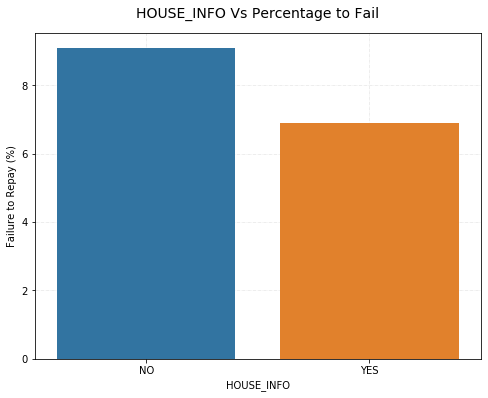

In [21]:
analizer.bins_impact(home_train, ["HOUSE_INFO"])

In [22]:
# Add this new variable to the final DF:

In [23]:
final_train = pd.concat([train["SK_ID_CURR"], home_train["HOUSE_INFO"]], axis = 1)

In [24]:
final_train.head()

SK_ID_CURR HOUSE_INFO
0      100002        YES
1      100003        YES
2      100004         NO
3      100006         NO
4      100007         NO

#### 2) Delete unuseful information:

We divide the dataframe in numerical and categorical variables, then we study the correlation and feature importance for both DFs. We fill the NA and keep only the important variables.

In [25]:
house_df = home_train.drop("TARGET", axis = 1)

In [26]:
# Split between numerical and categorical variables:

In [27]:
house_num = house_df.select_dtypes('float64').copy()

In [28]:
house_cat = house_df.select_dtypes('object').copy()

#### 2.1) Numerical Variables:

We want to remove multicollinearity keeping only one kind of measurament for each attribute (one among AVG, MEDIAN, MODE). To do this we test the importance of each attribute by ANOVA test (Random forest would work better, but it takes too much time).

In [29]:
# Let's keep only one measurament (AVG, MEDI, MODE) for each variable:

In [30]:
# Fill missing values:

In [31]:
for col in house_num.columns:
    tools.imputer(house_num, col, method = 'median')

In [32]:
# Feature importance:

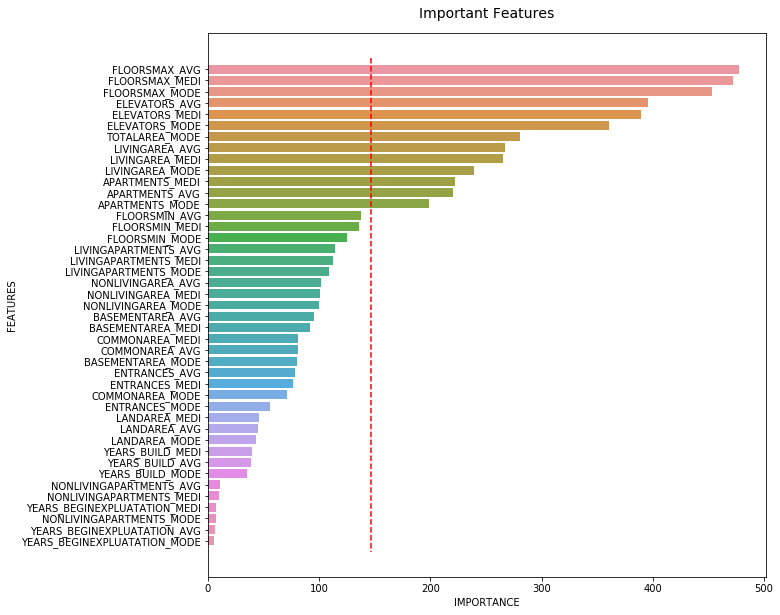

In [33]:
analizer.ANOVA_Importance(house_num, train, name = "House_Info")

In [34]:
house_num = train[["FLOORSMAX_AVG", "ELEVATORS_AVG", "TOTALAREA_MODE", "LIVINGAREA_AVG", "APARTMENTS_MEDI", 
                   "FLOORSMIN_AVG", "LIVINGAPARTMENTS_AVG", "NONLIVINGAREA_AVG", "BASEMENTAREA_AVG", "COMMONAREA_AVG",
                   "ENTRANCES_MEDI", "LANDAREA_MEDI", "YEARS_BUILD_MEDI", "NONLIVINGAPARTMENTS_AVG", 
                   "YEARS_BEGINEXPLUATATION_MEDI"]]

In [35]:
# Check Correlation 

As we can expected "TOTALAREA_MOD" is highly correlated with almost all of the other variables, but "YEARS_BEGININGEXPLUATATION" and "NONLIVINAPARTMENTS". These two variables are also low correlated with all the other ones, so we keep also them.

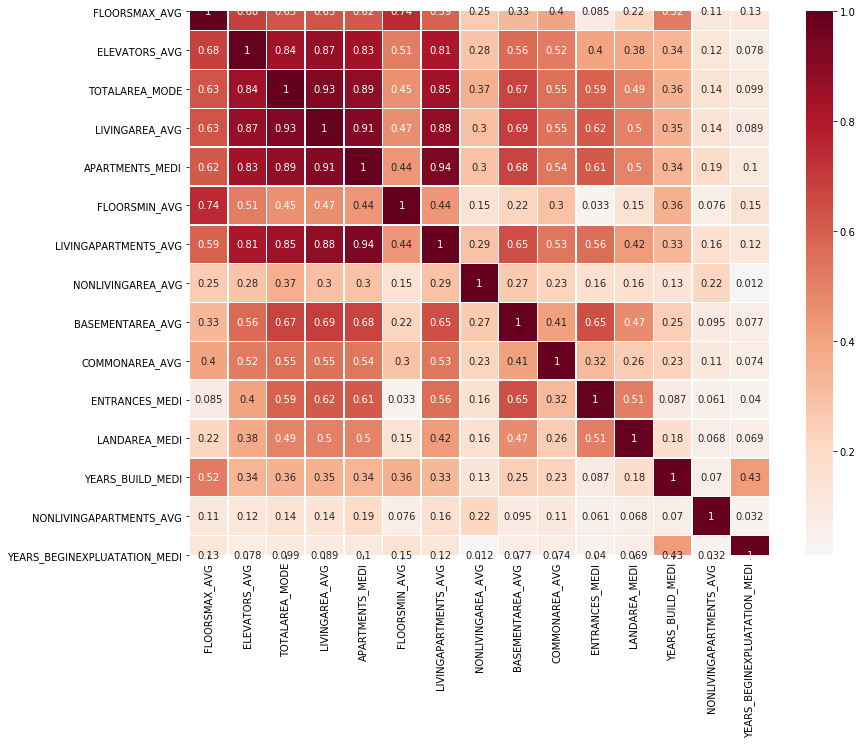

In [36]:
analizer.cor_plot(house_num, size = (13, 10), an = True, name = "House_Info_After_Removing")

In [37]:
house_num = house_num[["TOTALAREA_MODE", "NONLIVINGAPARTMENTS_AVG", 'YEARS_BEGINEXPLUATATION_MEDI']]

#### 2.2) Categorical variables:

In [38]:
# Prepare the DF:

In [39]:
# Add the continious variables:

house_cat = pd.concat([house_cat, house_num], axis = 1)

# Fill NA as a new category + fill na of categorical:

house_cat["FONDKAPREMONT_MODE"].fillna(value = "not specified", inplace = True)
house_cat["HOUSETYPE_MODE"].fillna(value = "not specified", inplace = True)
house_cat["WALLSMATERIAL_MODE"].fillna(value = "Others", inplace = True)
house_cat["EMERGENCYSTATE_MODE"].fillna(value = "Others", inplace = True)


for col in house_num.columns:
     tools.imputer(house_cat, col, method = 'median')

# One HOt Encoding:

house_cat = pd.get_dummies(house_cat)

In [40]:
house_cat.head()

TOTALAREA_MODE  NONLIVINGAPARTMENTS_AVG  YEARS_BEGINEXPLUATATION_MEDI  \
0          0.0149                   0.0000                        0.9722   
1          0.0714                   0.0039                        0.9851   
2          0.0688                   0.0000                        0.9816   
3          0.0688                   0.0000                        0.9816   
4          0.0688                   0.0000                        0.9816   

   FONDKAPREMONT_MODE_not specified  FONDKAPREMONT_MODE_org spec account  \
0                                 0                                    0   
1                                 0                                    0   
2                                 1                                    0   
3                                 1                                    0   
4                                 1                                    0   

   FONDKAPREMONT_MODE_reg oper account  \
0                                    1   
1                                    1   
2                                    0   
3                                    0   
4                                    0   

   FONDKAPREMONT_MODE_reg oper spec account  HOUSETYPE_MODE_block of flats  \
0                                         0                              1   
1                                         0                              1   
2                                         0                              0   
3                                         0                              0   
4                                         0                              0   

   HOUSETYPE_MODE_not specified  HOUSETYPE_MODE_specific housing  ...  \
0                             0                                0  ...   
1                             0                                0  ...   
2                             1                                0  ...   
3                             1                                0  ...   
4                             1                                0  ...   

   WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
0                              0                          0   
1                              0                          0   
2                              0                          1   
3                              0                          1   
4                              0                          1   

   WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
0                         0                                1   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   

   WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  \
0                          0                       1   
1                          0                       1   
2                          0                       0   
3                          0                       0   
4                          0                       0   

   EMERGENCYSTATE_MODE_Others  EMERGENCYSTATE_MODE_Yes  HOUSE_INFO_NO  \
0                           0                        0              0   
1                           0                        0              0   
2                           1                        0              1   
3                           1                        0              1   
4                           1                        0              1   

   HOUSE_INFO_YES  
0               1  
1               1  
2               0  
3               0  
4               0  

[5 rows x 23 columns]

In [41]:
# Let's study the importance by ANOVA:

We must take in account that some of the top variables are the one created, which were nulls, and in the most of the cases represent 50% or more of the observation 8and they are all the same). That's why thery are so imporrtant. We ignore them. Instead, it seems that EMERGENCY_STRATE_MOD give us some more intreresting info, also the variabel we have created (HOUSE_INFO) is very important for the model and finally the continious variables we have selcted.

SUMMARY: we keep EMERGENCY_STRATE_MOD, HOUSE_INFO, TOTALAREA_MODE, YEARS_BEGINEEXPLUATATION_MEDI, NONLIVINGAPARTMENTS_AVG.

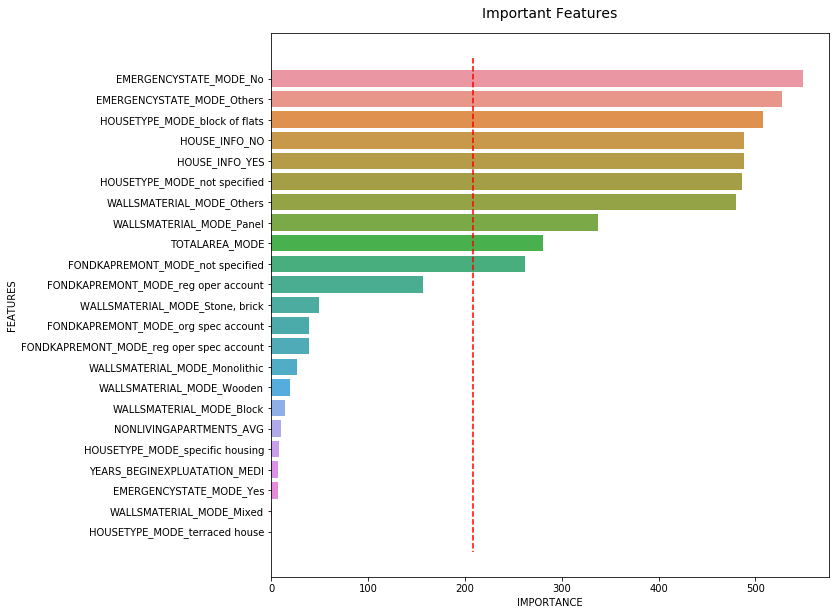

In [42]:
analizer.ANOVA_Importance(house_cat, train, name = "House_Cat")

In [43]:
# Generat ethe DF with the variables we need:

In [44]:
# Generate the DF:

house_cat = train[["EMERGENCYSTATE_MODE", "TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG", "NONLIVINGAPARTMENTS_AVG",
                  "TARGET"]]
house_cat = pd.concat([house_cat, final_train["HOUSE_INFO"]], axis = 1)

# Transform NaN of categorical variable in a category:

house_cat["EMERGENCYSTATE_MODE"].fillna(value = "not specified", inplace = True)

# Get Dummies:

house_cat = pd.get_dummies(house_cat)

# Reorder DF:

house_cat =  house_cat[["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG", "NONLIVINGAPARTMENTS_AVG",
                       "HOUSE_INFO_YES", "HOUSE_INFO_NO","EMERGENCYSTATE_MODE_Yes", "EMERGENCYSTATE_MODE_No",
                        "EMERGENCYSTATE_MODE_not specified", "TARGET"]]

In [45]:
house_cat.head()

TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  NONLIVINGAPARTMENTS_AVG  \
0          0.0149                       0.9722                   0.0000   
1          0.0714                       0.9851                   0.0039   
2             NaN                          NaN                      NaN   
3             NaN                          NaN                      NaN   
4             NaN                          NaN                      NaN   

   HOUSE_INFO_YES  HOUSE_INFO_NO  EMERGENCYSTATE_MODE_Yes  \
0               1              0                        0   
1               1              0                        0   
2               0              1                        0   
3               0              1                        0   
4               0              1                        0   

   EMERGENCYSTATE_MODE_No  EMERGENCYSTATE_MODE_not specified  TARGET  
0                       1                                  0       1  
1                       1                                  0       0  
2                       0                                  1       0  
3                       0                                  1       0  
4                       0                                  1       0

In [46]:
# Let's study the correlation:

The correlation among some variables for exemple HOUSE_INFO_Yes and No is due to the dummy trap. But for the other variables the correlation is very low, but not for EMERGENCY_STATE_MODE_No, this is because HOUSE_INFO already captures info about this variable. We will delete these variables, to improve our model.
 
To notice that no variables have a aprticular impact on the target variable.

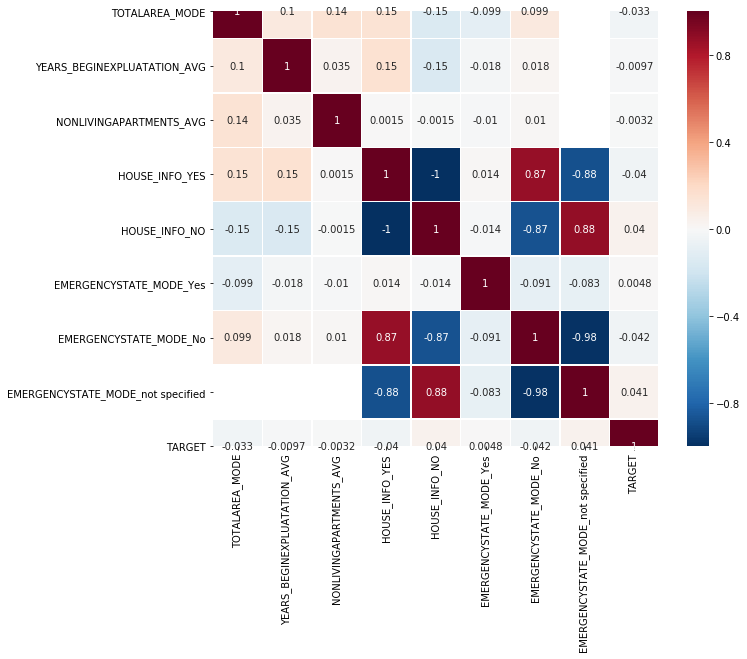

In [47]:
analizer.cor_plot(house_cat, an = True, name = "House_cat")

In [48]:
# Drop the columns to avoid dummy Trap:

In [49]:
house_cat = house_cat.drop(columns = ["HOUSE_INFO_NO", "EMERGENCYSTATE_MODE_not specified"])

#### 2.3) Check Outlayers:

As we can see these variables are very skewned, the most of the values are concentrated at 0 or at 1, anyway the values are between 0 and 1, therefore we cannot say that there are putlayer. In addition the observations are well distributed, so we cannot remov them. This fenomena is also due to the fact that the number of missing observations is very high: between 48% and 70%. For the variable with 70% of nan the best solution is to dop it.

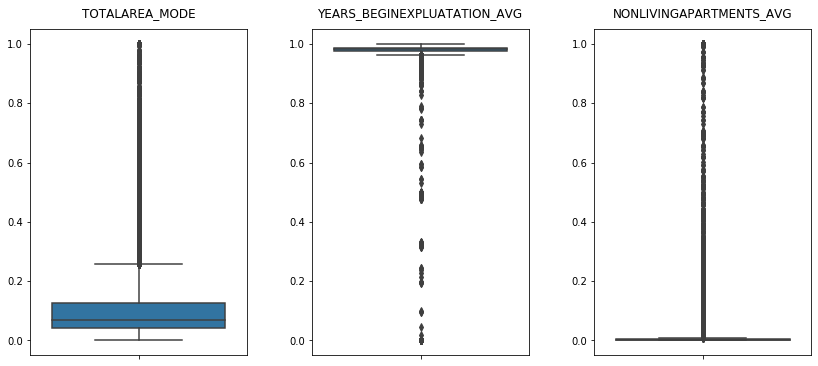

In [50]:
cols = ["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG", "NONLIVINGAPARTMENTS_AVG"]
analizer.Box_Plots(house_cat, cols, nrow = 1, ncol = 3, size = (14, 6), name = "House_Info")

In [51]:
# Let's drop the variable with 70% of mssing values:

In [52]:
round(proportions(house_cat), 2)

poms  pobs
TOTALAREA_MODE               0.48  0.52
YEARS_BEGINEXPLUATATION_AVG  0.49  0.51
NONLIVINGAPARTMENTS_AVG      0.69  0.31
HOUSE_INFO_YES               0.00  1.00
EMERGENCYSTATE_MODE_Yes      0.00  1.00
EMERGENCYSTATE_MODE_No       0.00  1.00
TARGET                       0.00  1.00

In [53]:
house_cat = house_cat.drop("NONLIVINGAPARTMENTS_AVG", axis = 1)

#### 2.4) Adjust the Skewnes:

In this case we cannot do a lot. In addition, we don't know wheather these 0s are real number or additional misisng values. Because if tou think about the meaning of totalareamode, it means that the area of he most of the rooms of the house is 0, namely they are not present.

For "YEARS_BEGINEXPLUATATION_AVG" if we get from 0.94 it is "almost" normal distributed, anyway, it has a less skewned shape. This distribution has a multvariate one, it has the most of the values on 1 and on 0 in the middle there isn't almost anything. The values before 0.95 are less than the 0.05%, so let's suppose that they are missin (they are close to 0 o r 0).

Afte the replacement, some useful information comes out. The former, we got a normal distribution for the second variables, the latter for the variable "YEARS_BEGINEXPLUATATION_AVG" seems that clients have higher prob to repay for a very high ratio (> 0.98), for a smaller the opposite is True.
For the vairable "TOTALAREA_MODE", it seems that for a higher ratio (> 0.2) the clients are willig to repay he loan more likely. Instead, when the mode is close to 0 the probability to repay is less.

In [54]:
# Let's plot the distribution:

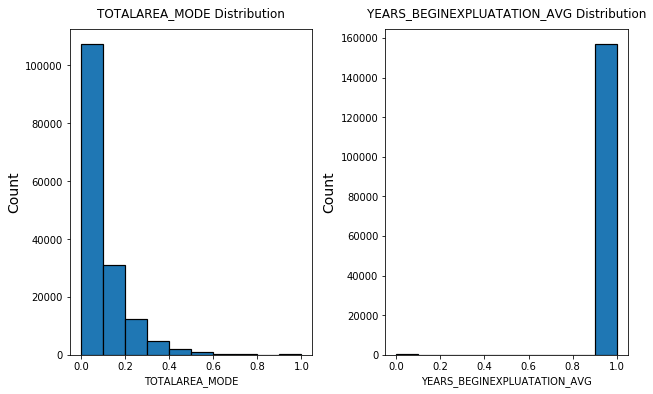

In [55]:
cols = ["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG"]
analizer.plot_distributions(house_cat, cols, nrow = 1, ncol = 2, size = (10, 6), kind = "histogram", name = "House_Info")

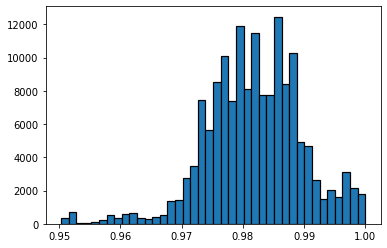

In [56]:
years_over_95_perc = house_cat[house_cat["YEARS_BEGINEXPLUATATION_AVG"] > 0.95]["YEARS_BEGINEXPLUATATION_AVG"]
plt.hist(years_over_95_perc, bins = 40, edgecolor='black', linewidth=1.2)
plt.show()

In [57]:
# Let's check the values lessn than 0.95:

In [58]:
round(len(house_cat[house_cat["YEARS_BEGINEXPLUATATION_AVG"] <0.95])/len(house_cat), 3)

0.005

In [59]:
# Impute as missing values:

In [60]:
house_cat["YEARS_BEGINEXPLUATATION_AVG"] = house_cat["YEARS_BEGINEXPLUATATION_AVG"].apply(lambda x: np.nan if x < 0.95 else x)


In [61]:
# Let's plot the new results:

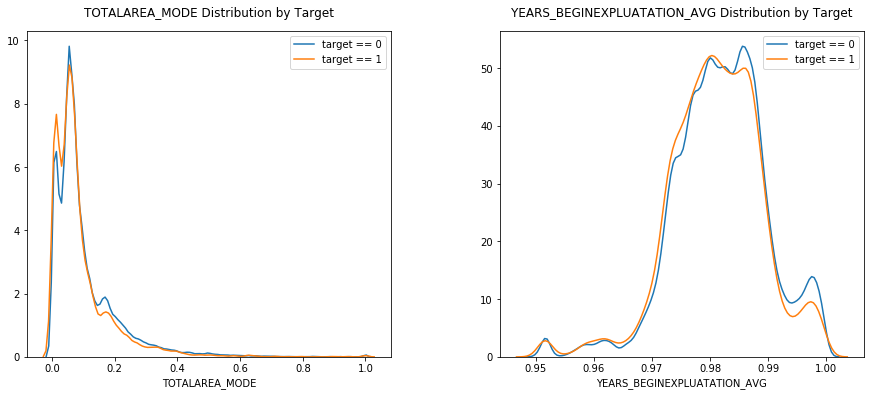

In [62]:
cols = ["TOTALAREA_MODE", "YEARS_BEGINEXPLUATATION_AVG"]
analizer.plot_distributions(house_cat, cols, nrow = 1, ncol = 2, kind = "kdeplot", name = "House_Info")

#### 2.4) Fill missing values:

They have a lot of missing values, but less than the 60% (our threshold), so we will fill them. For "TOTALAREA_MODE", we use the median, because it has skewned distribution. Instead, for "YEARS_BEGINEXPLUATATION_AVG" we use the mean, "more" normal distributed.

We must rememeber that "EMERGENCYSTATE_MODE" had missing values, but we created a column for them,anyway ths column was highly correlate dwith the variable "HOUSE_INFO" which says if the info the house columns are present. SO to avoid multicollinearity and also the dummy tap we droped it.

In [63]:
proportions(house_cat)

poms      pobs
TOTALAREA_MODE               0.482685  0.517315
YEARS_BEGINEXPLUATATION_AVG  0.493238  0.506762
HOUSE_INFO_YES               0.000000  1.000000
EMERGENCYSTATE_MODE_Yes      0.000000  1.000000
EMERGENCYSTATE_MODE_No       0.000000  1.000000
TARGET                       0.000000  1.000000

In [64]:
'''tools.imputer(house_cat, "TOTALAREA_MODE")
tools.imputer(house_cat, "YEARS_BEGINEXPLUATATION_AVG", method = "mean")'''

'tools.imputer(house_cat, "TOTALAREA_MODE")\ntools.imputer(house_cat, "YEARS_BEGINEXPLUATATION_AVG", method = "mean")'

#### 3) Add the new columns to the final DF:

In [65]:
final_train = pd.concat([final_train, house_cat.iloc[:, :-1]], axis = 1)

In [66]:
final_train = final_train.drop("HOUSE_INFO", axis = 1)

In [67]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  
0                        0                       1  
1                        0                       1  
2                        0                       0  
3                        0                       0  
4                        0                       0

### External infortmation:

#### 1) Create te DF:

In [68]:
externals = train[["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "TARGET"]]

In [69]:
externals.head()

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  TARGET
0      0.083037      0.262949      0.139376       1
1      0.311267      0.622246           NaN       0
2           NaN      0.555912      0.729567       0
3           NaN      0.650442           NaN       0
4           NaN      0.322738           NaN       0

#### 2) Correlation

There is just a little bit of positive correlation among these three variables (< 20%). Instead all of them have a negative correlation with the target (around 20%).

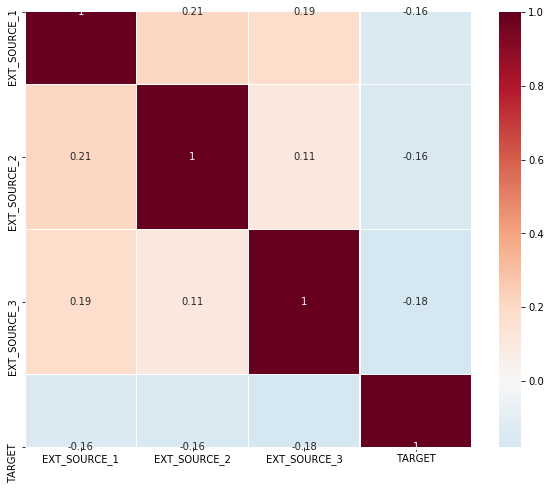

In [70]:
analizer.cor_plot(externals, an = True, name = "Externals")

#### 3) Distribution:

The first source has a normal distribution, the other two are skewed on the left. After trying different transformation we have noticed that the situation can only change in bad, so let's keep tjem in this way.

For all of them the impact on the TARGET variable is cleare, for lower values the clients have a lower probability to repaty the loan.

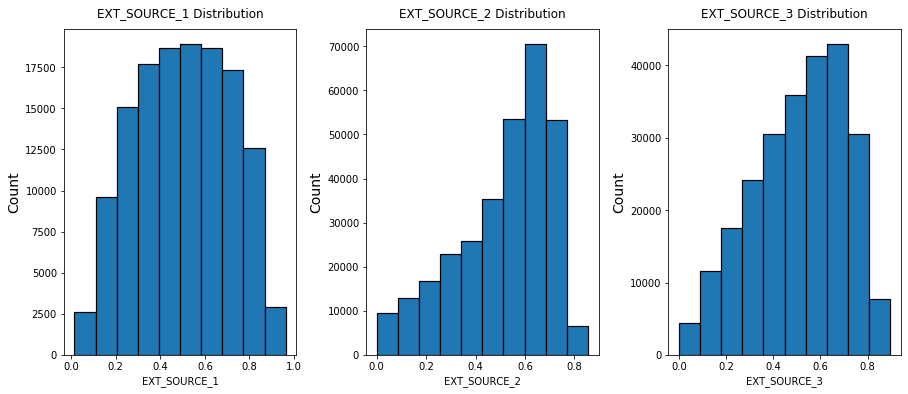

In [71]:
cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]
analizer.plot_distributions(externals, cols, nrow = 1, ncol = 3, kind = "histogram", name = "Externals")

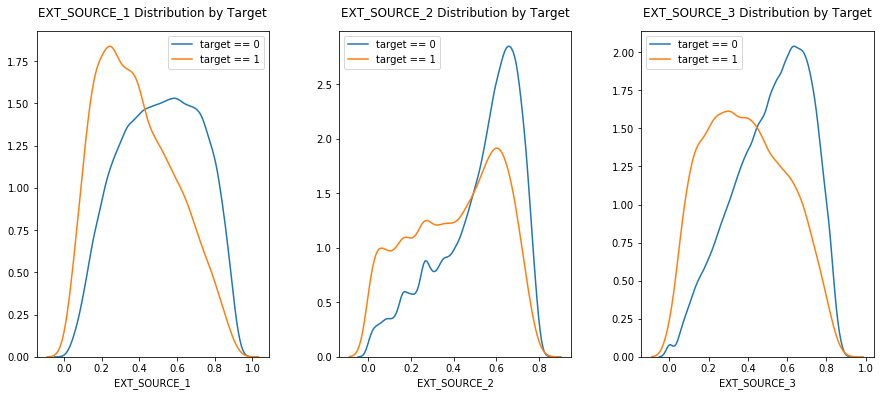

In [72]:
analizer.plot_distributions(externals, cols, nrow = 1, ncol = 3, size = (15, 6), kind = "kdeplot", name = "Externals")

#### 3) Null Analysis:

The one with less nan is the second one, we can think to keep only this, because of the high correlation between them.
At the moment we keep and impute all of them.

In [73]:
# Check the percentage of NA:

In [74]:
proportions(externals)

poms      pobs
EXT_SOURCE_1  0.563811  0.436189
EXT_SOURCE_2  0.002146  0.997854
EXT_SOURCE_3  0.198253  0.801747
TARGET        0.000000  1.000000

In [75]:
# Fill the NA:

In [76]:
tools.imputer(externals, "EXT_SOURCE_1", method = "mean")
tools.imputer(externals, "EXT_SOURCE_2", method = "median")
tools.imputer(externals, "EXT_SOURCE_3", method = "median")

#### 4) Study the importance:

As we can see the two external sources are the ones that have a higher impact on the target variable. However, we can suppose that is due to the high ammount of missing values in the first external attribute. Anyway, we have seen that there is a correlation between them and expecially between the first external source and the other two, so we can drop the first one.

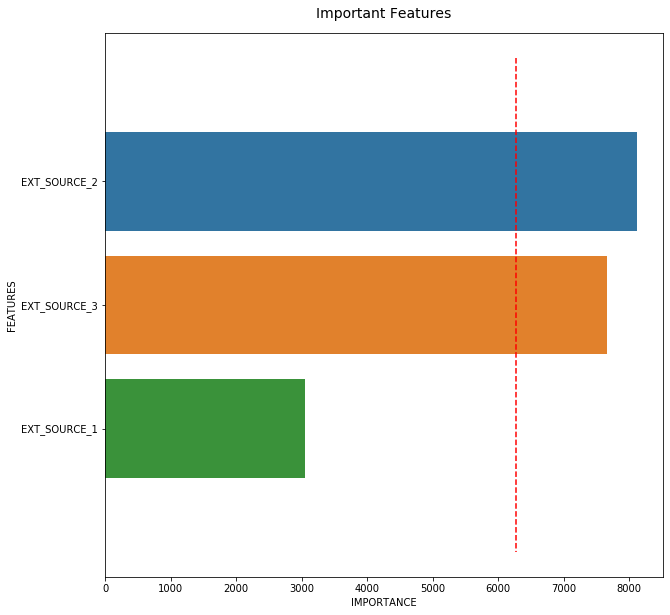

In [77]:
analizer.ANOVA_Importance(externals.iloc[:, :-1], train, name = "Externals")

In [78]:
# Drop the source with less mportance

In [79]:
externals = externals.drop("EXT_SOURCE_1", axis = 1)

#### 4) Join the result with the final DF:

In [80]:
externals["EXT_SOURCE_2"] = train["EXT_SOURCE_2"]
externals["EXT_SOURCE_2"] = train["EXT_SOURCE_3"]
externals.drop("TARGET", axis = 1, inplace = True)

In [81]:
final_train = pd.concat([final_train, externals], axis = 1)

In [82]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  EXT_SOURCE_3  
0                        0                       1      0.139376      0.139376  
1                        0                       1           NaN      0.535276  
2                        0                       0      0.729567      0.729567  
3                        0                       0           NaN      0.535276  
4                        0                       0           NaN      0.535276

## Flag Documentation

#### 1) Create the DF:

In [83]:
flags = train[["FLAG_DOCUMENT_2", "FLAG_DOCUMENT_3", "FLAG_DOCUMENT_4", "FLAG_DOCUMENT_5", "FLAG_DOCUMENT_6", 
               "FLAG_DOCUMENT_7", "FLAG_DOCUMENT_8", "FLAG_DOCUMENT_9", "FLAG_DOCUMENT_10", "FLAG_DOCUMENT_11", 
               "FLAG_DOCUMENT_12", "FLAG_DOCUMENT_13", "FLAG_DOCUMENT_14", "FLAG_DOCUMENT_15", "FLAG_DOCUMENT_16", 
               "FLAG_DOCUMENT_17", "FLAG_DOCUMENT_18", "FLAG_DOCUMENT_19", "FLAG_DOCUMENT_20", "FLAG_DOCUMENT_21"]]

#### 2) Missing Values analysis:

There aren't missing values, but let's check how many people brought each kind of documnent: The most given documents are 3 (70%) and then 6 and 8 with 8% of times. At this point it is reasonable to group them, as follow:

- Document 3 present
- Document 6 or/and 8 present
- Any other document present
- No document present


In [84]:
pd.set_option('display.max_rows', None)
proportions(flags)

poms  pobs
FLAG_DOCUMENT_2    0.0   1.0
FLAG_DOCUMENT_3    0.0   1.0
FLAG_DOCUMENT_4    0.0   1.0
FLAG_DOCUMENT_5    0.0   1.0
FLAG_DOCUMENT_6    0.0   1.0
FLAG_DOCUMENT_7    0.0   1.0
FLAG_DOCUMENT_8    0.0   1.0
FLAG_DOCUMENT_9    0.0   1.0
FLAG_DOCUMENT_10   0.0   1.0
FLAG_DOCUMENT_11   0.0   1.0
FLAG_DOCUMENT_12   0.0   1.0
FLAG_DOCUMENT_13   0.0   1.0
FLAG_DOCUMENT_14   0.0   1.0
FLAG_DOCUMENT_15   0.0   1.0
FLAG_DOCUMENT_16   0.0   1.0
FLAG_DOCUMENT_17   0.0   1.0
FLAG_DOCUMENT_18   0.0   1.0
FLAG_DOCUMENT_19   0.0   1.0
FLAG_DOCUMENT_20   0.0   1.0
FLAG_DOCUMENT_21   0.0   1.0

In [85]:
pd.set_option('display.max_rows', 10)

In [86]:
# Check the percentage of clients that brought each document:

In [87]:
tot_docs = len(flags)
for col in flags.columns:
    tot = len(flags[flags[col] == 1])
    perc = round(tot/tot_docs*100, 4)
    print("{}: {}%".format(col, perc))

FLAG_DOCUMENT_2: 0.0042%
FLAG_DOCUMENT_3: 71.0023%
FLAG_DOCUMENT_4: 0.0081%
FLAG_DOCUMENT_5: 1.5115%
FLAG_DOCUMENT_6: 8.8055%
FLAG_DOCUMENT_7: 0.0192%
FLAG_DOCUMENT_8: 8.1376%
FLAG_DOCUMENT_9: 0.3896%
FLAG_DOCUMENT_10: 0.0023%
FLAG_DOCUMENT_11: 0.3912%
FLAG_DOCUMENT_12: 0.0007%
FLAG_DOCUMENT_13: 0.3525%
FLAG_DOCUMENT_14: 0.2936%
FLAG_DOCUMENT_15: 0.121%
FLAG_DOCUMENT_16: 0.9928%
FLAG_DOCUMENT_17: 0.0267%
FLAG_DOCUMENT_18: 0.813%
FLAG_DOCUMENT_19: 0.0595%
FLAG_DOCUMENT_20: 0.0507%
FLAG_DOCUMENT_21: 0.0335%


In [88]:
# Group Them:

In [89]:
flags.insert(20, "DOC_6_OR_8", 0)
flags.insert(21, "ANY_OTHER_DOCS", 0)
flags.insert(22, "NO_DOCUMENTS", 0)

In [90]:
flags.head()

FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  \
0                0                1                0                0   
1                0                1                0                0   
2                0                0                0                0   
3                0                1                0                0   
4                0                0                0                0   

   FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                1                0   

   FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  ...  FLAG_DOCUMENT_15  \
0                 0                 0  ...                 0   
1                 0                 0  ...                 0   
2                 0                 0  ...                 0   
3                 0                 0  ...                 0   
4                 0                 0  ...                 0   

   FLAG_DOCUMENT_16  FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   
3                 0                 0                 0                 0   
4                 0                 0                 0                 0   

   FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  DOC_6_OR_8  ANY_OTHER_DOCS  \
0                 0                 0           0               0   
1                 0                 0           0               0   
2                 0                 0           0               0   
3                 0                 0           0               0   
4                 0                 0           0               0   

   NO_DOCUMENTS  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 23 columns]

In [91]:
flags.loc[(flags['FLAG_DOCUMENT_6'] == 1) | (flags['FLAG_DOCUMENT_8'] == 1), 'DOC_6_OR_8'] = 1

flags.loc[(flags.iloc[:, [0, 2, 3, 5, 7, 8, 9 ,10, 11, 12, 13, 14, 15, 16, 17, 18, 19]] == 1).any(axis = 1) &
         (flags.iloc[:, [1,4,6]] != 1).all(axis = 1), 'ANY_OTHER_DOCS']= 1

flags.loc[(flags.iloc[:, :-3] == 0).all(axis = 1), "NO_DOCUMENTS"] = 1

In [92]:
# Remove all the columns we don't need:

In [93]:
flags.drop(columns = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
                      'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',   'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 
                      'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
                      'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
          inplace = True)

In [94]:
flags.head()

FLAG_DOCUMENT_3  DOC_6_OR_8  ANY_OTHER_DOCS  NO_DOCUMENTS
0                1           0               0             0
1                1           0               0             0
2                0           0               0             1
3                1           0               0             0
4                0           1               0             0

In [95]:
flags.columns = ['FLAG_DOC_3', 'FLAG_DOC_6_OR_8', 'FLAG_ANY_OTHER_DOCS', 'FLAG_NO_DOCUMENTS']

In [96]:
flags = flags.astype('uint8')

In [97]:
flags = pd.concat([flags, train["TARGET"]], axis = 1)

#### 2) Study correlation:

There is a strong correlation between "FLAG_DOCUMENT_3" and all other variables. On one hand, this correlation is due to dummy trap, on the other hand, to overcome this issue we cannot drop this attribute, because it is also the one we ehich has the strongest correlation with our TARGET.


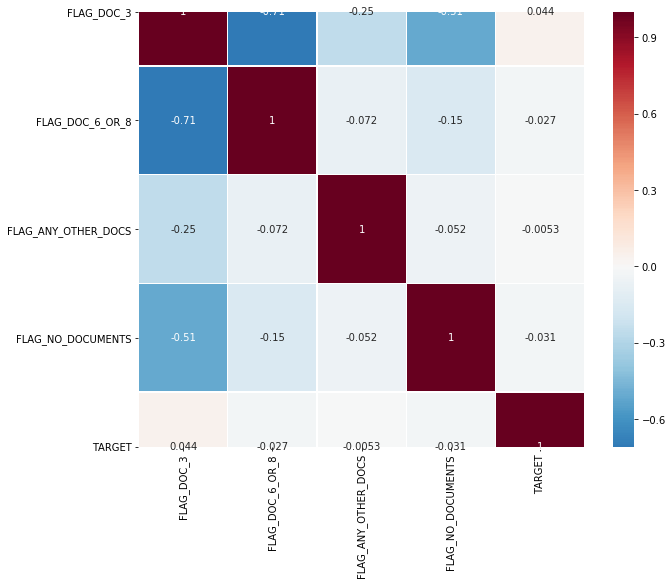

In [98]:
analizer.cor_plot(flags, an = True, name = "Flags")

#### 3) Features importance:

It seems that who bring doc 3 is more likely not to repay, but if we think about this result, we must underline that this is the document that almost 80% of people brought and our TARGET distribution is asymettric. In other words: it is easier to find a client that dosen't repay in this class, than in the others, but just because the number of obs.

Instead, it is more interesting to see that who brought one of the other documents is more likely to repay the loan. Finally, it is ambigous the result for who didn't bring any document, it seems that this kind of client has a very high prob to repay (Difficult to explain without furthermore knowledge).

Running the ANOVA test, we can see hoe DOC 3 is the one that explain the more about the model, but again, maybe because it is the one that the most brought and ANY_OTHER_DOC is not important for our model (maybe same reason).

Let's join FLAG_DOC_6/8 and FLAG_ANY_OTHER because they explain almost the same thing. After doing that, we can see that the correlation between the new variable and the other two is high. Choosing which keep and which not is hard, at the moment let's drop DOC_3, but the possibility to change our mind it is still open, also because this attribute seems to be the most important according to ANOVA test.

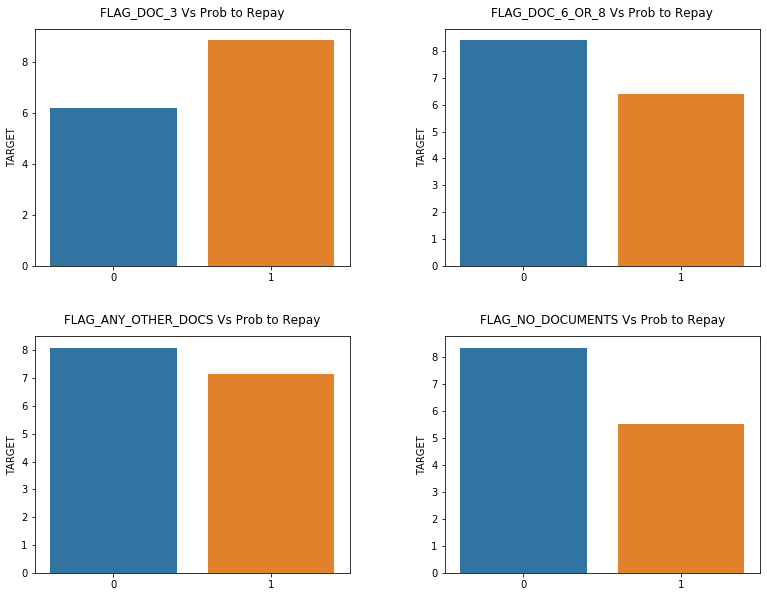

In [99]:
lst_c = flags.columns[:-1]
analizer.bins_impact(flags, lst_c, nrow = 2, ncol = 2, size = (13,10))

In [100]:
# Build New DF (join the variables and drop the old ones):

In [101]:
flags.insert(3, "FLAG_ANY_BUT_3", 0)

In [102]:
flags.loc[(flags["FLAG_DOC_6_OR_8"] == 1) & (flags["FLAG_ANY_OTHER_DOCS"] == 0), "FLAG_ANY_BUT_3"] = 1
flags.loc[(flags["FLAG_DOC_6_OR_8"] == 0) & (flags["FLAG_ANY_OTHER_DOCS"] == 1), "FLAG_ANY_BUT_3"] = 1
flags.loc[(flags["FLAG_DOC_6_OR_8"] == 1) & (flags["FLAG_ANY_OTHER_DOCS"] == 1), "FLAG_ANY_BUT_3"] = 1

In [103]:
flags = flags.drop(columns=["FLAG_DOC_6_OR_8", "FLAG_ANY_OTHER_DOCS"], axis = 1)

In [104]:
flags = flags[["FLAG_DOC_3", "FLAG_ANY_BUT_3", "FLAG_NO_DOCUMENTS", "TARGET"]]

In [105]:
# Do again the statistics:

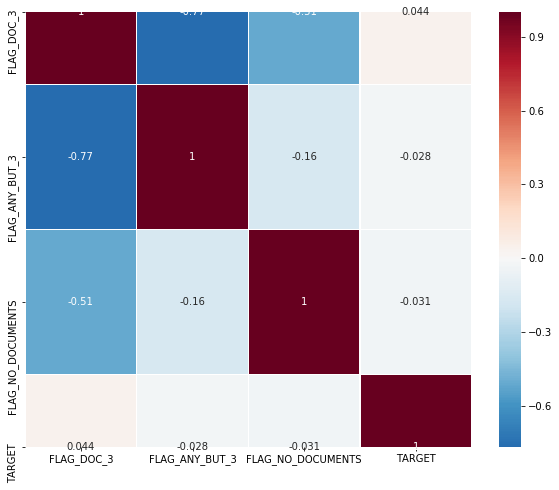

In [106]:
analizer.cor_plot(flags, an = True, name = "New_Flags")

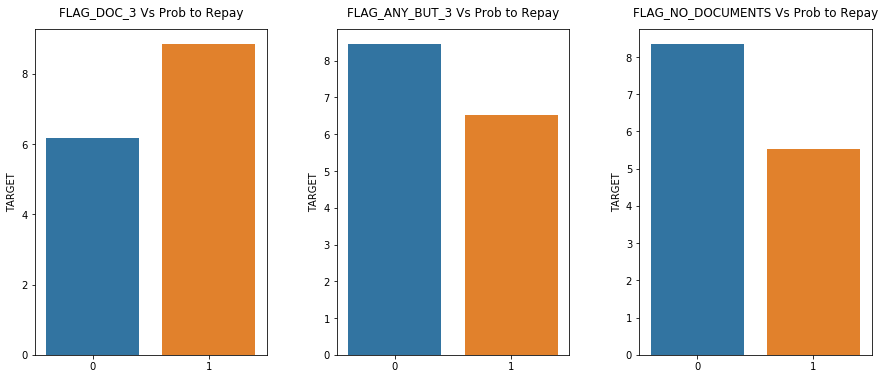

In [107]:
lst_c = flags.columns[:-1]
analizer.bins_impact(flags, lst_c, nrow = 1, ncol = 3, size = (15,6))

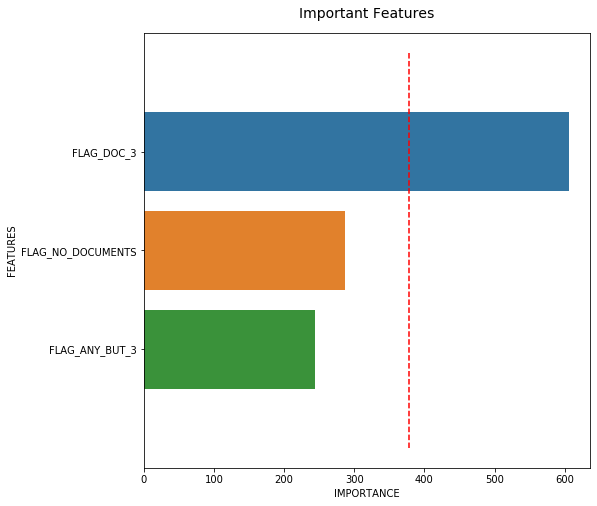

In [108]:
analizer.ANOVA_Importance(flags.iloc[:, :-1], train, size = (8, 8), name = "New_Flags")

In [109]:
# Dorp DOC_3:

In [110]:
flags = flags.drop("FLAG_DOC_3", axis = 1)

#### 4) Add new variables to the final DF:

In [111]:
final_train = pd.concat([final_train, flags.iloc[:, :-1]], axis = 1)

In [112]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  
0      0.139376               0                  0  
1      0.535276               0                  0  
2      0.729567               0                  1  
3      0.535276               0                  0  
4      0.535276               1                  0

### Social Circle

#### 1) Generate the DF:

In [113]:
social = train[['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                 'DEF_60_CNT_SOCIAL_CIRCLE']]

In [114]:
social.head()

OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0                       2.0                       2.0   
1                       1.0                       0.0   
2                       0.0                       0.0   
3                       2.0                       0.0   
4                       0.0                       0.0   

   OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  
0                       2.0                       2.0  
1                       1.0                       0.0  
2                       0.0                       0.0  
3                       2.0                       0.0  
4                       0.0                       0.0

#### 2) Let's check outlayers:

It is clear that there is an outlayer, probabily it is only one client, for teh differentattributes. We substitute the outlayer with a NA. We don't remove other elements, because we suppose it is probable that some person has a social circle of around 40 people. In addition we don't know the criterion to define the social circle, so who knows... 
For the default people, given the number of people in a scoial circle it seems reasonable that up to 8 people default, moreover they are few cases.

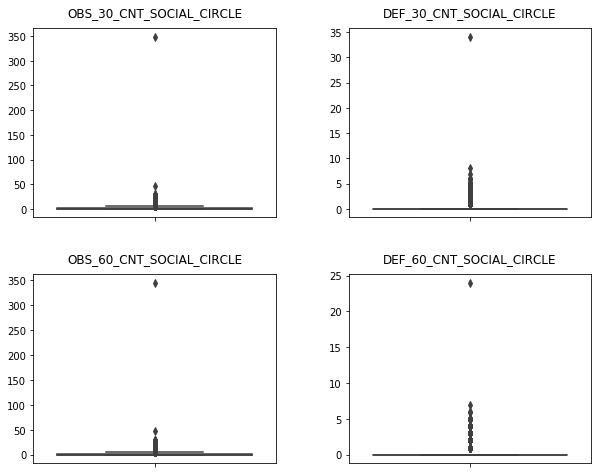

In [115]:
cols = ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']
analizer.Box_Plots(social, cols, nrow = 2, ncol = 2, size = (10, 8), name = "Social")

In [116]:
# Substitute outlayers with NAN:

In [117]:
# For OBS_30/60 we replace all values greater than 100 with missin values:

social["OBS_30_CNT_SOCIAL_CIRCLE"] = social["OBS_30_CNT_SOCIAL_CIRCLE"].apply(lambda x: np.nan if x >= 100 else x)
social["OBS_60_CNT_SOCIAL_CIRCLE"] = social["OBS_60_CNT_SOCIAL_CIRCLE"].apply(lambda x: np.nan if x >= 100 else x)

# For DEF_30/60 we replace all values greater than 10 with missin values:

social["DEF_30_CNT_SOCIAL_CIRCLE"] = social["DEF_30_CNT_SOCIAL_CIRCLE"].apply(lambda x: np.nan if x >= 10 else x)
social["DEF_60_CNT_SOCIAL_CIRCLE"] = social["DEF_60_CNT_SOCIAL_CIRCLE"].apply(lambda x: np.nan if x >= 10 else x)

In [118]:
#Let's check the new situation:

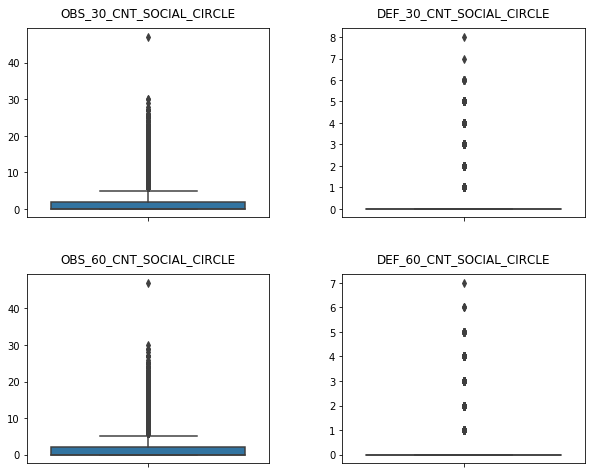

In [119]:
analizer.Box_Plots(social, cols, nrow = 2, ncol = 2, size = (10, 8), name = "New_Social")

#### 3) Let's studythe distribution of the variables

The problem here is the high amount of zeroes: if for the default attribute it makes sense (no one default), for the social circle it seems to be a NA, 0 people in the social, it is a strange number for so many people. Therefore, it is reasonable transform that values in NA. 

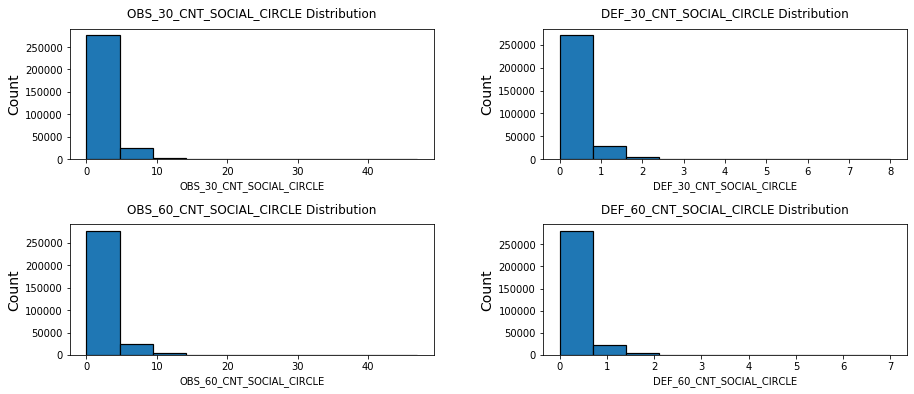

In [120]:
analizer.plot_distributions(social, cols, nrow = 2, ncol = 2, kind = "histogram", name = "Social")

In [121]:
# Let's transform zeroes in NA:

In [122]:
social.loc[social["OBS_30_CNT_SOCIAL_CIRCLE"] == 0, "OBS_30_CNT_SOCIAL_CIRCLE"] = np.nan
social.loc[(social["OBS_30_CNT_SOCIAL_CIRCLE"] == np.nan) & (social["DEF_30_CNT_SOCIAL_CIRCLE"] == 0), "DEF_30_CNT_SOCIAL_CIRCLE"] = np.nan

social.loc[social["OBS_60_CNT_SOCIAL_CIRCLE"] == 0, "OBS_60_CNT_SOCIAL_CIRCLE"] = np.nan
social.loc[(social["OBS_60_CNT_SOCIAL_CIRCLE"] == np.nan) & (social["DEF_60_CNT_SOCIAL_CIRCLE"] == 0), "DEF_60_CNT_SOCIAL_CIRCLE"] = np.nan


#### 4) Correlation:

It seems there isn't any difference between 30 and 60 Days, so we will keep only one period, the 60 days, just because we thimk that it contains more info (thanks the longer periodo of observation).

The correlation of all variables with the target is almost 0.

It can be create another variable from these, namely, the ratio between default and number of memeber of the circle. After creating it and calculating the correlation, we can say that also this variable dosen't have an impact on the model.


In [123]:
# Add TARGET:

In [124]:
social["TARGET"] = train["TARGET"]

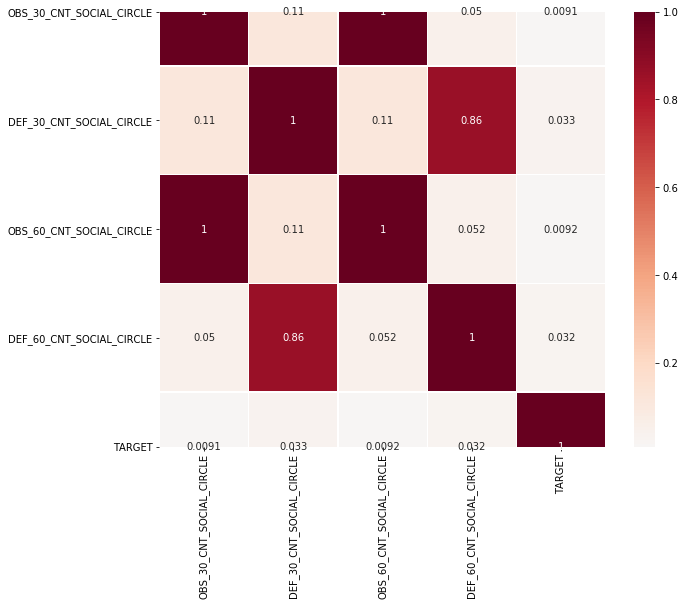

In [125]:
analizer.cor_plot(social, an = True, name = "Social")

In [126]:
# Drop 30 Days attributes:

In [127]:
social = social.drop(columns = ["OBS_30_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE"], axis = 1)

In [128]:
# Calculate the ratio:

In [129]:
social["SOCIAL_DEFAUL_RATIO_60"]=social["DEF_60_CNT_SOCIAL_CIRCLE"]/social["OBS_60_CNT_SOCIAL_CIRCLE"]
social.loc[(social["DEF_60_CNT_SOCIAL_CIRCLE"].isnull()) |  (social["OBS_60_CNT_SOCIAL_CIRCLE"].isnull()), 
           "SOCIAL_DEFAUL_RATIO_60"] = np.nan

In [130]:
social = social[["OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "SOCIAL_DEFAUL_RATIO_60", "TARGET"]]

In [131]:
# Let's see the correlation with the target:

In [132]:
social.corr()

OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  \
OBS_60_CNT_SOCIAL_CIRCLE                  1.000000                  0.051629   
DEF_60_CNT_SOCIAL_CIRCLE                  0.051629                  1.000000   
SOCIAL_DEFAUL_RATIO_60                   -0.166930                  0.772932   
TARGET                                    0.009248                  0.031565   

                          SOCIAL_DEFAUL_RATIO_60    TARGET  
OBS_60_CNT_SOCIAL_CIRCLE               -0.166930  0.009248  
DEF_60_CNT_SOCIAL_CIRCLE                0.772932  0.031565  
SOCIAL_DEFAUL_RATIO_60                  1.000000  0.038664  
TARGET                                  0.038664  1.000000

#### 5) Missing Values:

There are a lot of missing values, but still under out threshold (60%), so let's fill them and study the importance of the variable.

In [133]:
# Check:

In [134]:
proportions(social)

poms      pobs
OBS_60_CNT_SOCIAL_CIRCLE  0.538803  0.461197
DEF_60_CNT_SOCIAL_CIRCLE  0.003323  0.996677
SOCIAL_DEFAUL_RATIO_60    0.538803  0.461197
TARGET                    0.000000  1.000000

In [135]:
# Save columns with na:

In [136]:
social_nan = social.copy()

In [137]:
# Fill:

In [138]:
tools.imputer(social, "OBS_60_CNT_SOCIAL_CIRCLE", method = "median")
tools.imputer(social, "DEF_60_CNT_SOCIAL_CIRCLE", method = "median")
tools.imputer(social, "SOCIAL_DEFAUL_RATIO_60", method = "median")

#### 6) Importance:

It seems that for extrem values of both original variables, there is a low probability not to repay the loan.

- Low probabilitiy among 0 and 6 friends that default and more than 5
- Low probabilitiy if no social circle or with more than 30 friends

In [139]:
# ANOVA test:

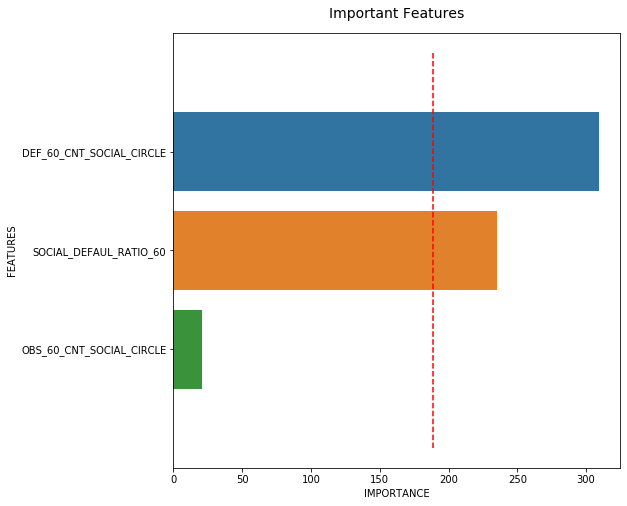

In [140]:
analizer.ANOVA_Importance(social.iloc[:, :-1], train, size = (8, 8), name = "Social")

In [141]:
# KDEPlot:

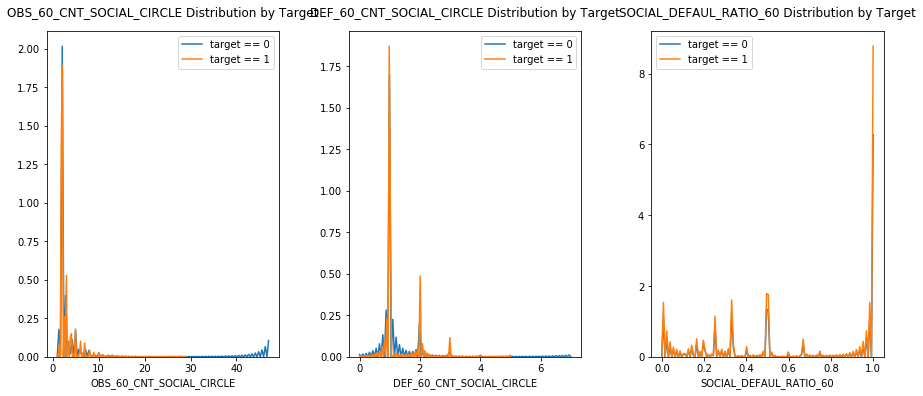

In [142]:
cols = ["OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "SOCIAL_DEFAUL_RATIO_60"]
analizer.plot_distributions(social, cols, nrow = 1, ncol = 3, kind = "kdeplot", name = "Social")

#### 6) Final DF:

Let's keep only the ration which is a summary of the other two variables.

In [143]:
final_train = pd.concat([final_train, social_nan[["SOCIAL_DEFAUL_RATIO_60"]]], axis = 1)

In [144]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  SOCIAL_DEFAUL_RATIO_60  
0      0.139376               0                  0                     1.0  
1      0.535276               0                  0                     0.0  
2      0.729567               0                  1                     NaN  
3      0.535276               0                  0                     0.0  
4      0.535276               1                  0                     NaN

### Enquires

#### 1) Create the DF

In [145]:
enquires = train[["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
                 "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]]

#### 2) Let's check outlayers:

It is interesting to see that there is also an attribute for the enquire in a hour, as we can expected almost all of the obs are 0. Probabily the non zero values are due to some errors occured during the procedure.

We can see there is an outlayer for th request in the quarter, we are going to replace with NA. it i interesting to see that for the within a year the median of the requests is 1. We think the requests done in a year is the most important attribute here.

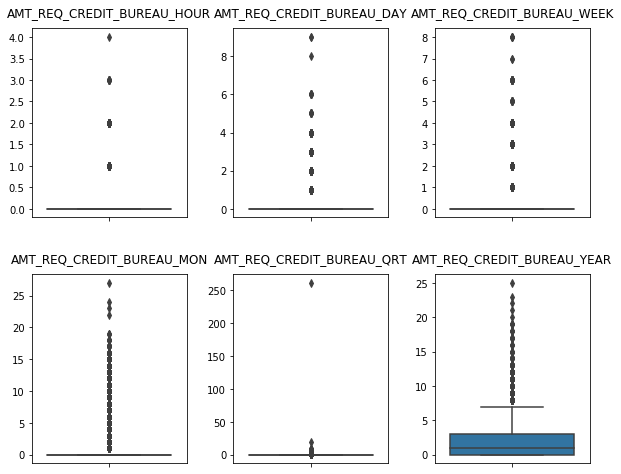

In [146]:
cols = ["AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
                 "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
analizer.Box_Plots(enquires, cols, nrow = 2, ncol = 3, size = (10, 8), name = "Enquires")

In [147]:
enquires["AMT_REQ_CREDIT_BUREAU_QRT"].max()

261.0

In [148]:
enquires["AMT_REQ_CREDIT_BUREAU_QRT"].replace(261, np.nan, inplace = True)

#### 3) Study Correlation:

For the structure of the data there should not be correlation. In fact, it is generaly true, but for some variables (strange). Anyway, this variables seemes not have an impact neither on the TARGET.

It is reasonable to group them in only variable, that counts the total number of enquires per year.

In [149]:
enquires = pd.concat([enquires, train["TARGET"]], axis = 1)

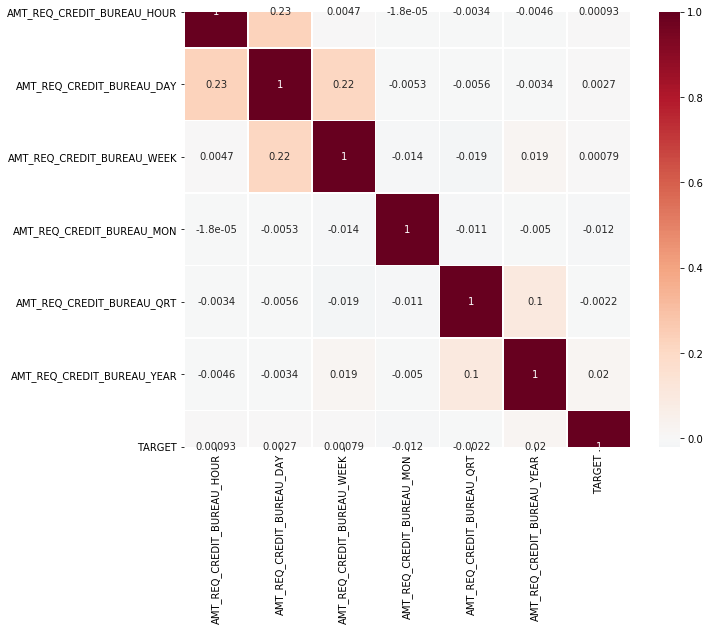

In [150]:
analizer.cor_plot(enquires, an = True, name = "Enquires")

In [151]:
# Createt the new variables:

In [152]:
enquires.insert(6, "TOT_ENQUIRES_YEARLY", np.nan)

In [153]:
enquires["TOT_ENQUIRES_YEARLY"] = enquires.iloc[: , range(6)].sum(axis = 1)
enquires.loc[(enquires.iloc[: , range(6)].isnull()).any(axis = 1), "TOT_ENQUIRES_YEARLY"] = np.nan

#### 4) Study the new variable:

The median is 2, which is reasonable, and the most haven't asked loans the previous year, also an accetable result. What concerns us is the max number of enquires in a year, let's say that over the 99th percntile the values are high (>9), but still reasonable. The max is 31 requests in a year, an average of two 3 request per month. Anyway, we must think about the kind of loans, they can be loans of a small amount or in same cases we are talking about credit cards, so it register in some sense, how many withdraw. The dub still exists anyway, because if check the amount of the new loans is high, for the most of them, so it is hard to believe that the older amounts were lower.

As we saind there are a lot of people tha didn't apply for a loan the year before, that's why the distribution is skewned.

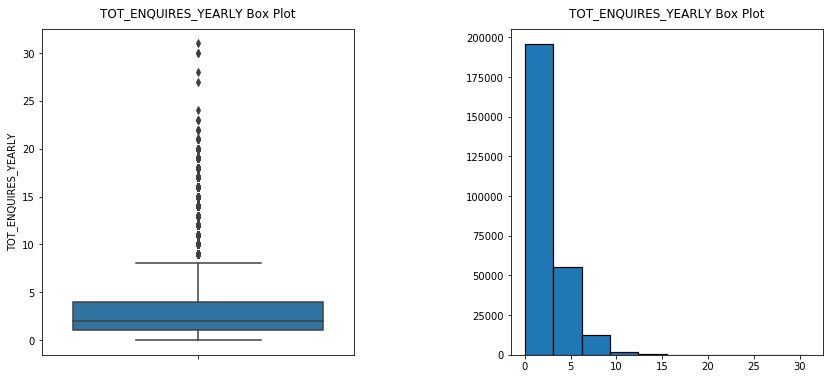

In [154]:
analizer.box_hist(enquires, "TOT_ENQUIRES_YEARLY", name = "Enquires")

In [155]:
enquires["TOT_ENQUIRES_YEARLY"].describe()

count    265991.000000
mean          2.479633
std           2.232322
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          31.000000
Name: TOT_ENQUIRES_YEARLY, dtype: float64

In [156]:
enquires["TOT_ENQUIRES_YEARLY"].quantile(0.99)

9.0

In [157]:
# Check the ammount of the current loans, for people that asked a lot of credit before:

In [158]:
idx = enquires.loc[enquires["TOT_ENQUIRES_YEARLY"] > 10].index
train.iloc[idx, ]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
418         100482       0         Cash loans           F            Y   
622         100712       0         Cash loans           M            N   
1059        101230       0         Cash loans           M            Y   
1388        101629       0         Cash loans           F            N   
1460        101718       0         Cash loans           F            N   
...            ...     ...                ...         ...          ...   
305890      454410       0         Cash loans           F            N   
306388      454980       0    Revolving loans           M            Y   
306459      455062       0         Cash loans           F            N   
306746      455393       0         Cash loans           F            N   
307418      456151       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
418                  Y             0          112500.0    445500.0   
622                  N             2          540000.0   1575000.0   
1059                 Y             1          292500.0   1288350.0   
1388                 Y             0          234823.5    647046.0   
1460                 Y             0          157500.0   1436850.0   
...                ...           ...               ...         ...   
305890               Y             0          247500.0   1287000.0   
306388               Y             2          225000.0    270000.0   
306459               N             2           90000.0    862560.0   
306746               N             0          108000.0    675000.0   
307418               N             0           90000.0    369720.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
418         16924.5  ...                 0                0                0   
622         43443.0  ...                 0                0                0   
1059        37800.0  ...                 0                0                0   
1388        17793.0  ...                 0                0                0   
1460        42142.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
305890      54657.0  ...                 0                0                0   
306388      13500.0  ...                 0                0                0   
306459      23850.0  ...                 0                0                0   
306746      21775.5  ...                 0                0                0   
307418      22747.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
418                   0                        0.0                       3.0   
622                   0                        0.0                       0.0   
1059                  0                        0.0                       0.0   
1388                  0                        0.0                       0.0   
1460                  0                        0.0                       0.0   
...                 ...                        ...                       ...   
305890                0                        0.0                       0.0   
306388                0                        0.0                       0.0   
306459                0                        0.0                       0.0   
306746                0                        0.0                       0.0   
307418                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
418                            3.0                        0.0   
622                            0.0                        9.0   
1059                           0.0                       11.0   
1388                           0.0                        3.0   
1460                           

#### 4.1) Studying the impact of the variable on th target:

The correlation with the TARGET is almost 0. It seems weird but who asked in the past more than 10 loans has a higher probability to repay, also more thant who haven't asked a loan wothin the previous year. Instead the most likely not to repay are the one that asked between 1 and 10 loans the year before.

All in all, this variable seems not to be important for our model, for the moment we put it, but than we should check the importance in our final model.

In [159]:
# Check correlation:

In [160]:
enquires[["TOT_ENQUIRES_YEARLY", "TARGET"]].corr()

TOT_ENQUIRES_YEARLY    TARGET
TOT_ENQUIRES_YEARLY             1.000000  0.011224
TARGET                          0.011224  1.000000

In [161]:
# Divide in category:

In [162]:
enquires["BINS_REQUESTS_PER_YEAR"] = pd.cut(enquires["TOT_ENQUIRES_YEARLY"], bins = [-1, 0, 10, np.inf], 
                                           labels = ["0", "[1, 10]", ">10"])

In [163]:
enquires = enquires[["TOT_ENQUIRES_YEARLY", "BINS_REQUESTS_PER_YEAR", "TARGET"]]

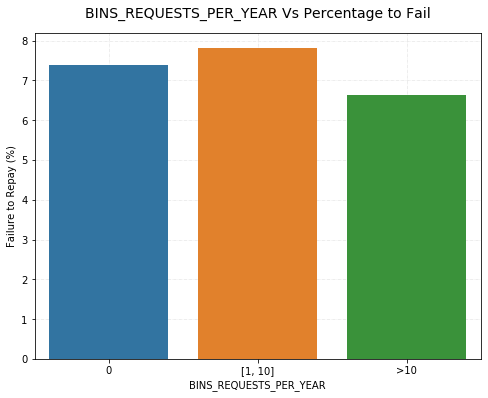

In [164]:
analizer.bins_impact(enquires, ["BINS_REQUESTS_PER_YEAR"])

#### 4.2) Fill Missing values:

In [165]:
#tools.imputer(enquires, "TOT_ENQUIRES_YEARLY", method = "median")

#### 5) Add the variable to the final DF:

In [166]:
final_train = pd.concat([final_train, enquires["TOT_ENQUIRES_YEARLY"]], axis = 1)

In [167]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  SOCIAL_DEFAUL_RATIO_60  \
0      0.139376               0                  0                     1.0   
1      0.535276               0                  0                     0.0   
2      0.729567               0                  1                     NaN   
3      0.535276               0                  0                     0.0   
4      0.535276               1                  0                     NaN   

   TOT_ENQUIRES_YEARLY  
0                  1.0  
1                  0.0  
2                  0.0  
3                  NaN  
4                  0.0

### Contract Type:

#### 1) Study the Distribution:

The variable is higly asymmetric, this can be a problem later.

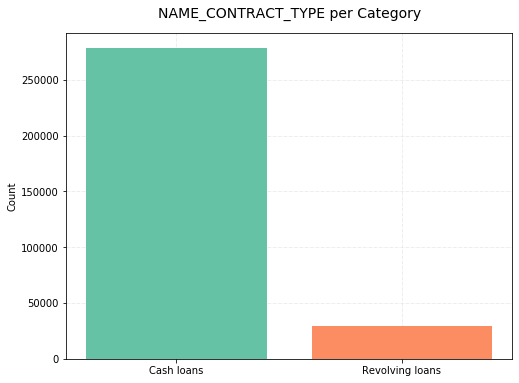

In [168]:
analizer.bar_plot(train, ["NAME_CONTRACT_TYPE"], size = (8, 6), name = "Contract_Type")

#### 2) Study the impact:

It seems that for cash loans clients are more likely to repay, anyway we cannot be sure about it, because of the not symmetric disstribution.

In [169]:
ContractType = train[["NAME_CONTRACT_TYPE", "TARGET"]].groupby("NAME_CONTRACT_TYPE").mean()

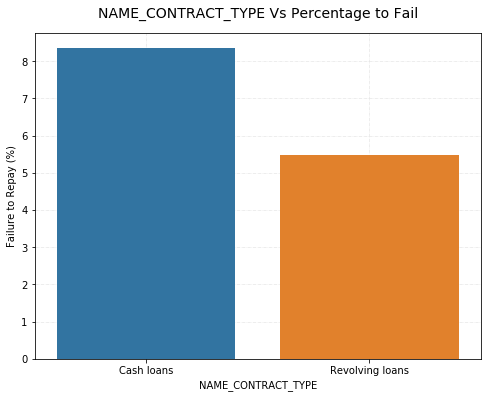

In [170]:
analizer.bins_impact(ContractType, ["NAME_CONTRACT_TYPE"])

#### 3) Transform in Dummies and Add to the final DF:

In [171]:
# Generate the dummy:

contrac_dummy = pd.get_dummies(train["NAME_CONTRACT_TYPE"], prefix = "CONTRACT_TYPE")
contrac_dummy.drop(columns = ["CONTRACT_TYPE_Revolving loans"], inplace = True)

# Generate the final DF:

final_train = pd.concat([final_train, contrac_dummy], axis = 1)

In [172]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  SOCIAL_DEFAUL_RATIO_60  \
0      0.139376               0                  0                     1.0   
1      0.535276               0                  0                     0.0   
2      0.729567               0                  1                     NaN   
3      0.535276               0                  0                     0.0   
4      0.535276               1                  0                     NaN   

   TOT_ENQUIRES_YEARLY  CONTRACT_TYPE_Cash loans  
0                  1.0                         1  
1                  0.0                         1  
2                  0.0                         0  
3                  NaN                         1  
4                  0.0                         1

### Ammount Annuity + Ammount Credit + Ammount Incomes:

#### 1) Generate the DF:

In [173]:
economics = train[["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

#### 2) Study the outlayers:

For the income there is for sure an outlayer, but there are also some very high variables, that we don't know whether to drop them or not, as we can see the 75 percentile is 202.500, but our incomes arrive up to 10.000.000.

It seemes AMT_CREDIT and AMT_GOODS_PRICE are distributed in the same way. they are probabily almost equal, we will see later.

All in all, the distributions are skewned, but all values seem reasonable.

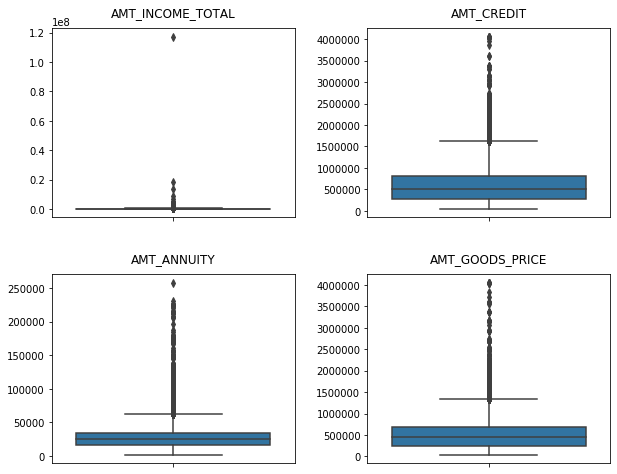

In [174]:
cols = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]
analizer.Box_Plots(economics, cols, nrow = 2, ncol = 2, size = (10, 8), name = "Economics")

In [175]:
# Check the outlayers:

In [176]:
round(economics["AMT_INCOME_TOTAL"].describe())

count       307511.0
mean        168798.0
std         237123.0
min          25650.0
25%         112500.0
50%         147150.0
75%         202500.0
max      117000000.0
Name: AMT_INCOME_TOTAL, dtype: float64

In [177]:
# Substitute with Na:

In [178]:
mm = economics["AMT_INCOME_TOTAL"].max()
economics.loc[economics["AMT_INCOME_TOTAL"] == mm, "AMT_INCOME_TOTAL"] = np.nan

#### 3) Distribution:

All the variables are skewned, But in general this kind of economics variables can be transform thanks to log in variables normal distributed (or very close to them).

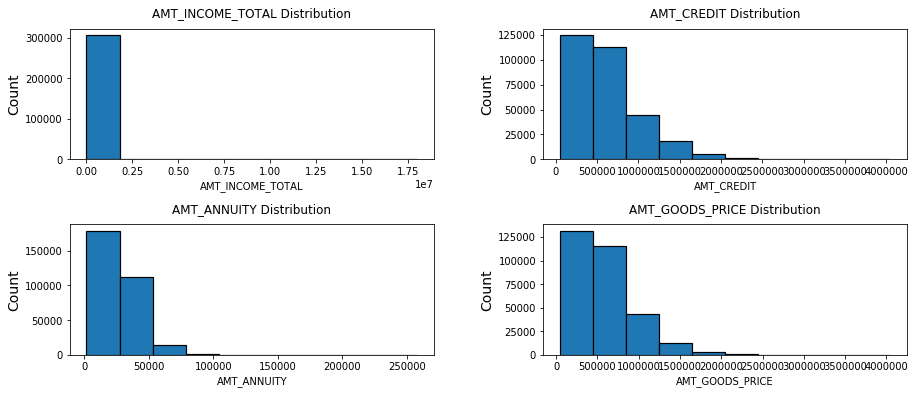

In [179]:
analizer.plot_distributions(economics, cols, nrow = 2, ncol = 2, size = (15, 6), kind = "histogram", name = "Economics")

In [180]:
# Transform and plot:

In [181]:
economics["AMT_INCOME_TOTAL_LOG"] = np.log(economics["AMT_INCOME_TOTAL"])

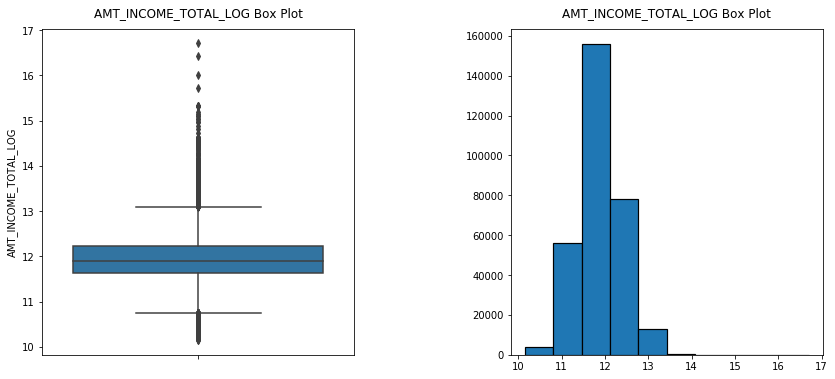

In [182]:
analizer.box_hist(economics, "AMT_INCOME_TOTAL_LOG", name = "Economics")

In [183]:
economics["AMT_CREDIT_LOG"] = np.log(economics["AMT_CREDIT"])

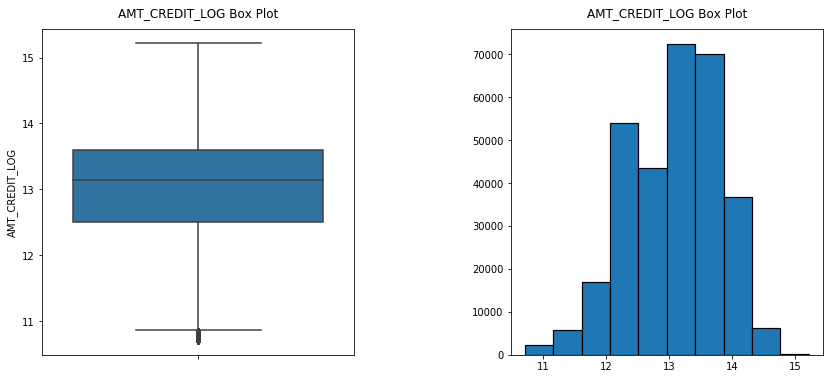

In [184]:
analizer.box_hist(economics, "AMT_CREDIT_LOG", name = "Economics")

In [185]:
economics["AMT_ANNUITY_LOG"] = np.log(economics["AMT_ANNUITY"])

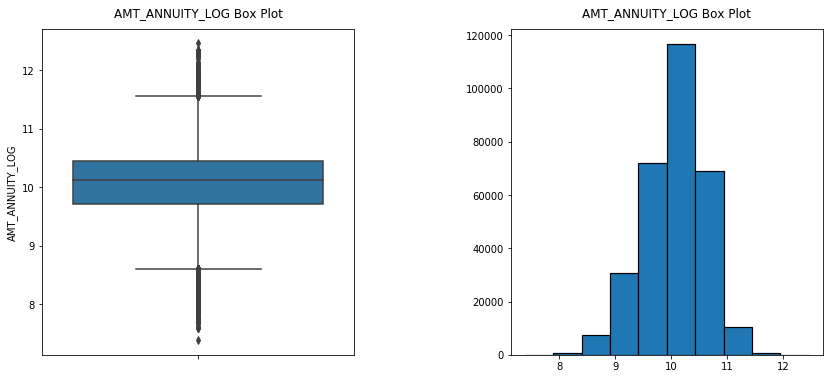

In [186]:
analizer.box_hist(economics, "AMT_ANNUITY_LOG", name = "Economics")

In [187]:
economics["AMT_GOODS_PRICE_LOG"] = np.log(economics["AMT_GOODS_PRICE"])

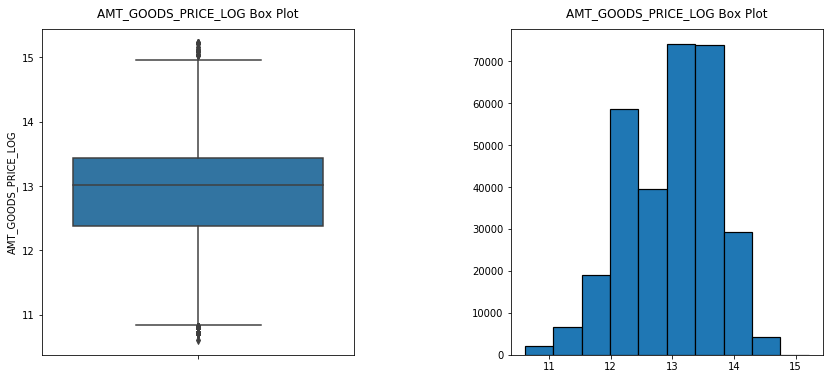

In [188]:
analizer.box_hist(economics, "AMT_GOODS_PRICE_LOG", name = "Economics")

#### 4) Study correlation

All this variables are highly correlated, as we expected the ammount given and the price of the good are correlated (with a correlation almost 1). For sure, also how much each client repay each year and the total amount of the loans are correlated.

Instead, none of the variables have a correlation with the target.

In [189]:
# Addjust DF:

In [190]:
# Add teh target:

economics["TARGET"] = train["TARGET"]

# Use only log variables:

economics_log = economics[["AMT_INCOME_TOTAL_LOG", "AMT_CREDIT_LOG", "AMT_ANNUITY_LOG", "AMT_GOODS_PRICE_LOG", "TARGET"]]

In [191]:
# Correlation matrix:

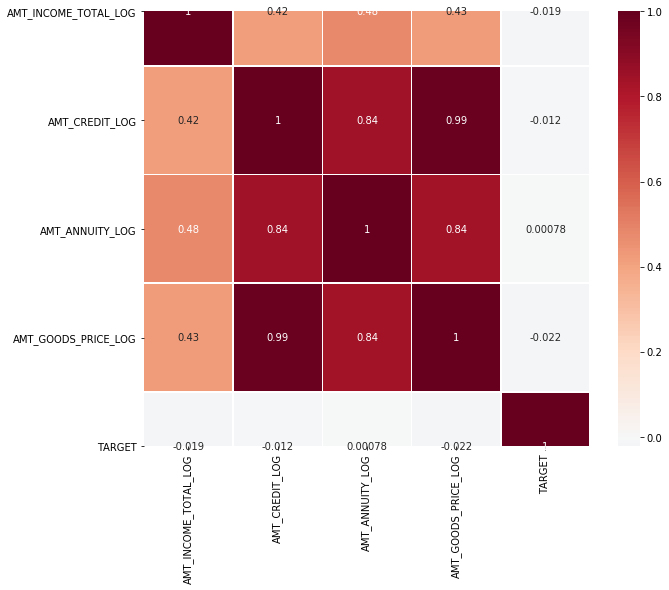

In [192]:
analizer.cor_plot(economics_log, an = True, name = "Economics")

#### 5) Importance:

Both Credit ammount and Annuity ammount seems that give us important information: for amount credit, people with the highest and smallest credit are more likely to repay, instead for peopel that have a credit which is in the middle of the distribution have a highe rprobability not to repay. The same fenomena can be observed for ammount annuity.

For the other two variables it is hard to extrapolate somenthing useful.

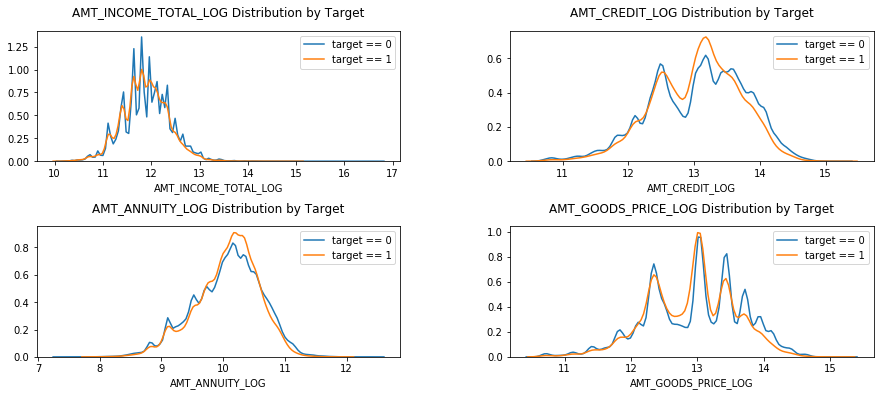

In [193]:
cols = ["AMT_INCOME_TOTAL_LOG", "AMT_CREDIT_LOG", "AMT_ANNUITY_LOG", "AMT_GOODS_PRICE_LOG"]
analizer.plot_distributions(economics, cols, nrow = 2, ncol = 2, size = (15, 6), kind = "kdeplot", name = "Economics")

#### 6.1) Extrapolate new info: Duration

If we divide the total amount of credit and how much they repay per year, we can get the duration of the loan. It is not accurate, because we cannot take in account that in the ammount annuity there are also the interests, but we don't know which is thei ammount, so we cannot have a precise outcume, but a very close to the right one.

There are some elements which are very high: for ex. a duration of 45 (interested exculded) is a lot, in general in Italy it is hard to get a loan for more than 30 years (and it males sense), but this is another Country, so we cannot say. But the common sense tells us that probably those values are outlayers. As matte rof fact, the 75 percentile is 27.
Furthermore, if we drop the values higher than 30, the distribution becomes normal.

We think that there can be anegative correlation with the age and in fact there is, it is silight (around 10%), but there is.

People that have a short term loan have a higher probability to repay, the worst are clients with a loans between 10 and 20 years, followed by who loans between 20 and 30. This is reasonable because, the loger the term, the more the situations that can bring to default. For >30 the result is not reasonable, but because there are fewer observations.

In [194]:
economics["DURATION"] = np.round(economics["AMT_CREDIT"] / economics["AMT_ANNUITY"])
economics[(economics["AMT_CREDIT"].isnull()) | (economics["AMT_ANNUITY"].isnull())]["DURATION"] = np.nan

In [195]:
# Check outlayers + Distribution:

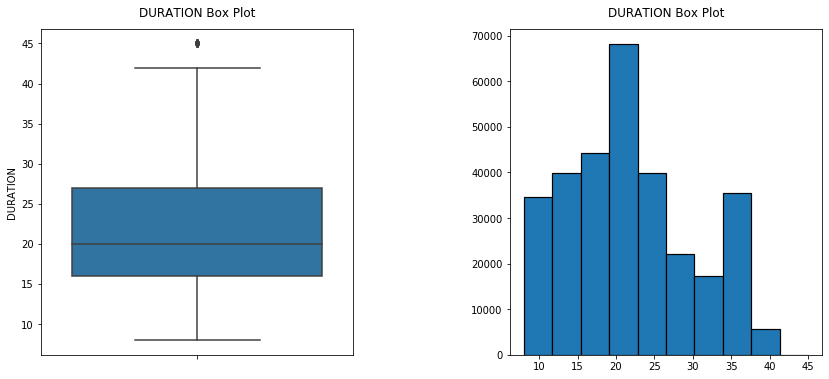

In [196]:
analizer.box_hist(economics, "DURATION", name = "Duration_Economics")

In [197]:
economics["DURATION"].describe()

count    307499.000000
mean         21.616815
std           7.834401
min           8.000000
25%          16.000000
50%          20.000000
75%          27.000000
max          45.000000
Name: DURATION, dtype: float64

In [198]:
# Check correlation with age:

In [199]:
age = pd.concat([train["DAYS_BIRTH"], economics["DURATION"]], axis = 1)
age.corr()

DAYS_BIRTH  DURATION
DAYS_BIRTH    1.000000 -0.109125
DURATION     -0.109125  1.000000

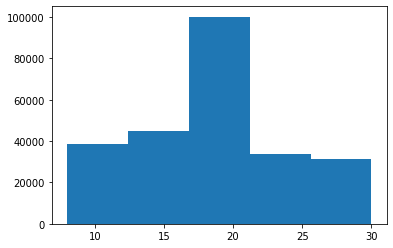

In [200]:
plt.hist(economics[economics["DURATION"] <= 30]["DURATION"], bins = 5)
plt.show()

In [201]:
# Check the impact of different duration:

In [202]:
economics["DURATION_BINS"] = pd.cut(economics["DURATION"], bins = [0, 10, 20, 30, np.inf], 
                                           labels = ["(0, 10]", "(10, 20]", "(20, 30]", ">30"])

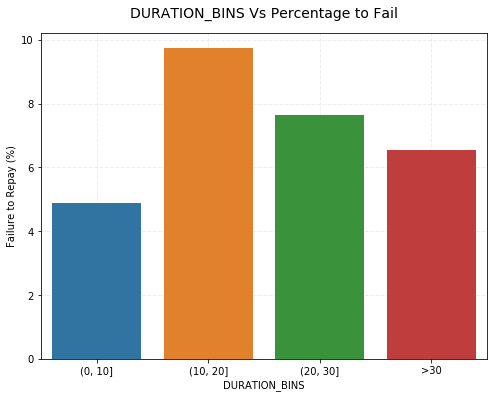

In [203]:
analizer.bins_impact(economics, ["DURATION_BINS"])

#### 6.2) Extrapolate new info: Credit - Incomes ratio:

It can happen that the banks borrow a too high amount of money to a client, which hasn't enough money to repat it neither along years. Let's see if this info can be useful.

In the average the ratio is 1 : 4, the credit is 4 times higher than the incomes of the client. It is reasonable, we can also expect, that this is not generally true for people that earn a lot more than the average.

The skew of the distribution underlines that some outlayers are present: for exemple the values 84 is clearly due to an outlayers. As matter of fact, this guy is the one that has a duration of 45 years. We can say that is an outlayer adn we we fill all his values with NA (because we don't know which are correct and which not) or in any case is an extreme case, that wrongly modify our model. 

If we think about the meaning of this ratio, there should be a correlation with the duration, because the bank probabily give the loan calculating a priori the percentage that a clien is able to repay each year, starting from his/her yearly incomes.

We have discovered a very strange trend: the probability to default is moderate high at the begining and decreases till the ratio is around 25, from that moment it suddnley increases a lot.

In [204]:
economics["AMT_CREDIT_INCOMES_RATIO"] = np.round(economics["AMT_CREDIT"] / economics["AMT_INCOME_TOTAL"])
economics[(economics["AMT_CREDIT"].isnull()) | (economics["AMT_INCOME_TOTAL"].isnull())]["AMT_CREDIT_INCOMES_RATIO"] = np.nan

In [205]:
# Check outlayers + Distribution:

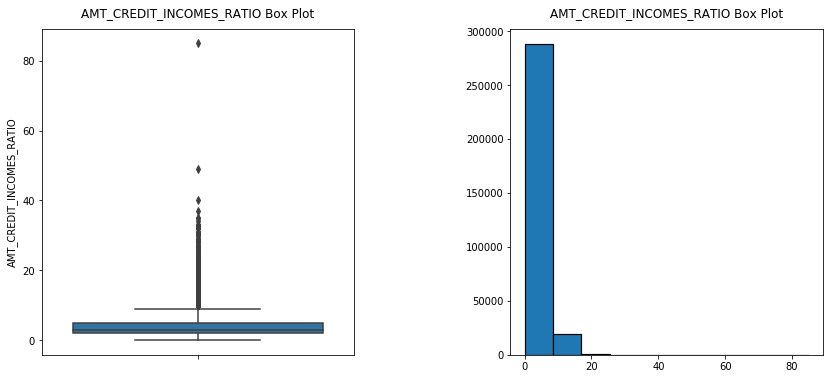

In [206]:
analizer.box_hist(economics, "AMT_CREDIT_INCOMES_RATIO", name = "Credit.Incomes.Ratio_Economics")

In [207]:
economics["AMT_CREDIT_INCOMES_RATIO"].describe()

count    307510.000000
mean          3.957439
std           2.706142
min           0.000000
25%           2.000000
50%           3.000000
75%           5.000000
max          85.000000
Name: AMT_CREDIT_INCOMES_RATIO, dtype: float64

In [208]:
# Check the outlayer and replace all its atribues with NA:

In [209]:
economics[economics["AMT_CREDIT_INCOMES_RATIO"] == 85]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
20727           25650.0   2173500.0      48118.5        2173500.0   

       AMT_INCOME_TOTAL_LOG  AMT_CREDIT_LOG  AMT_ANNUITY_LOG  \
20727             10.152299       14.591849        10.781422   

       AMT_GOODS_PRICE_LOG  TARGET  DURATION DURATION_BINS  \
20727            14.591849       1      45.0           >30   

       AMT_CREDIT_INCOMES_RATIO  
20727                      85.0

In [210]:
economics.loc[economics["AMT_CREDIT_INCOMES_RATIO"] == 85] = np.nan

In [211]:
# Check correlation with duration:

In [212]:
economics[["DURATION", "AMT_CREDIT_INCOMES_RATIO"]].corr()

DURATION  AMT_CREDIT_INCOMES_RATIO
DURATION                  1.000000                  0.597427
AMT_CREDIT_INCOMES_RATIO  0.597427                  1.000000

In [213]:
# Study importance:

In [214]:
economics["CREDIT_INCOMES_RATIO_BINS"] = pd.cut(economics["AMT_CREDIT_INCOMES_RATIO"], bins = [0, 5, 10, 20, 25, 30, np.inf], 
                                           labels = ["(0, 5]", "(5, 10]", "(10,20]", "(20,25]", "(25,30]",">30"])

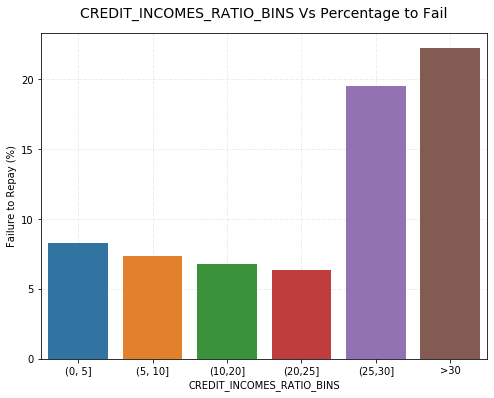

In [215]:
analizer.bins_impact(economics, ["CREDIT_INCOMES_RATIO_BINS"])

#### 6.3) Extrapolate new info: Annuity - Incomes ratio:

The concept is similar to the variable we have just created, and with a probability close to 1, this to variable are highly correlated.

This ratio it is useful, because it clearly explains that there is somenthing wrong: there are people which should pay to the bank more than how much they earn. It is important to understand better what is going on. What is stranger is the fact that almost all of them can repay the loan! If we check the information we have, all of them earn figures with 3 zeros and got credits also for a milion or more. It is hard to work with this data, because it is diffuclt to say that all these data are wrong, but for sure some of them are wrong. We cannot say which is the one, so to be sure not to do any mistake we will impute them as NA. We stop here, but it is reasonable to think that also 80% or evene 50% of incomes that go away to repay  the loan is a HUGE amount. As matter of fact, the mean in 20% of the incomes is used to pay the loan (an acceptable result).

As we can expected for a higher ratio, the people cannot repay the loan (To be precise with a ratio more than 1.8).

In [216]:
economics["AMT_ANNUITY_INCOMES_RATIO"] = economics["AMT_ANNUITY"] / economics["AMT_INCOME_TOTAL"]
economics[(economics["AMT_ANNUITY"].isnull()) | (economics["AMT_ANNUITY"].isnull())]["AMT_ANNUITY_INCOMES_RATIO"] = np.nan

In [217]:
# Check outlayers + Distribution:

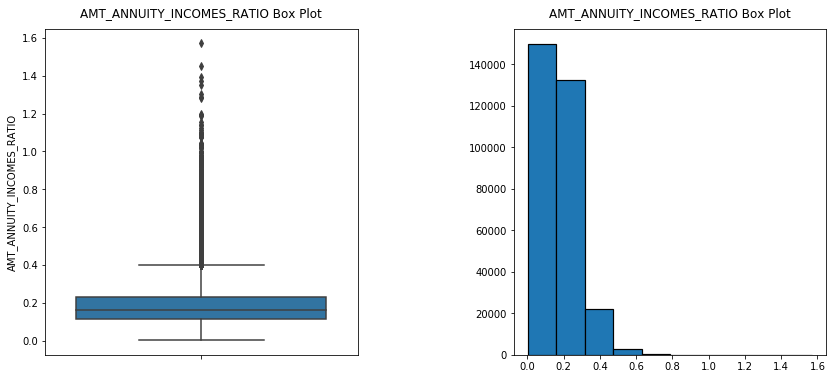

In [218]:
analizer.box_hist(economics, "AMT_ANNUITY_INCOMES_RATIO", name = "Annuity.Incomes.Ratio_Economics")

In [219]:
economics["AMT_ANNUITY_INCOMES_RATIO"].describe()

count    307497.000000
mean          0.180925
std           0.094524
min           0.003333
25%           0.114782
50%           0.162833
75%           0.229067
max           1.570600
Name: AMT_ANNUITY_INCOMES_RATIO, dtype: float64

In [220]:
# Check the outlayer and replace all its atribues with NA:

In [221]:
economics[(economics["AMT_ANNUITY_INCOMES_RATIO"] > 1)]

AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
678              54000.0   1885500.0      74191.5        1885500.0   
25802            46044.0   1024740.0      52452.0         900000.0   
35791            45000.0   2215224.0      58567.5        1980000.0   
49185            33750.0    835380.0      36927.0         675000.0   
58379            54000.0   1724688.0      60079.5        1575000.0   
...                  ...         ...          ...              ...   
247615           31500.0    679500.0      45724.5         679500.0   
257550           45000.0    675000.0      47110.5         675000.0   
264706           38250.0    398016.0      39496.5         360000.0   
266975           27000.0    640080.0      31261.5         450000.0   
293599           33165.0   1006920.0      42790.5         900000.0   

        AMT_INCOME_TOTAL_LOG  AMT_CREDIT_LOG  AMT_ANNUITY_LOG  \
678                10.896739       14.449704        11.214405   
25802              10.737353       13.839949        10.867654   
35791              10.714418       14.610864        10.977935   
49185              10.426736       13.635642        10.516698   
58379              10.896739       14.360557        11.003424   
...                      ...             ...              ...   
247615             10.357743       13.429113        10.730390   
257550             10.714418       13.422468        10.760251   
264706             10.551899       12.894247        10.583967   
266975             10.203592       13.369348        10.350143   
293599             10.409250       13.822407        10.664071   

        AMT_GOODS_PRICE_LOG  TARGET  DURATION DURATION_BINS  \
678               14.449704     1.0      25.0      (20, 30]   
25802             13.710150     0.0      20.0      (10, 20]   
35791             14.498607     0.0      38.0           >30   
49185             13.422468     0.0      23.0      (20, 30]   
58379             14.269766     0.0      29.0      (20, 30]   
...                     ...     ...       ...           ...   
247615            13.429113     0.0      15.0      (10, 20]   
257550            13.422468     0.0      14.0      (10, 20]   
264706            12.793859     0.0      10.0       (0, 10]   
266975            13.017003     0.0      20.0      (10, 20]   
293599            13.710150     0.0      24.0      (20, 30]   

        AMT_CREDIT_INCOMES_RATIO CREDIT_INCOMES_RATIO_BINS  \
678                         35.0                       >30   
25802                       22.0                   (20,25]   
35791                       49.0                       >30   
49185                       25.0                   (20,25]   
58379                       32.0                       >30   
...                          ...                       ...   
247615                      22.0                   (20,25]   
257550                      15.0                   (10,20]   
264706                      10.0                   (5, 10]   
266975                      24.0                   (20,25]   
293599                      30.0                   (25,30]   

        AMT_ANNUITY_INCOMES_RATIO  
678                      1.373917  
25802                    1.139171  
35791                    1.301500  
49185                    1.094133  
58379                    1.112583  
...                           ...  
247615                   1.451571  
257550                   1.046900  
264706                   1.032588  
266975                   1.157833  
293599                   1.290231  

[32 rows x 14 columns]

In [222]:
economics.loc[(economics["AMT_ANNUITY_INCOMES_RATIO"] > 1)] = np.nan

In [223]:
# Check correlation with the other ratio:

In [224]:
economics[["AMT_ANNUITY_INCOMES_RATIO", "AMT_CREDIT_INCOMES_RATIO"]].corr()

AMT_ANNUITY_INCOMES_RATIO  AMT_CREDIT_INCOMES_RATIO
AMT_ANNUITY_INCOMES_RATIO                   1.000000                  0.782522
AMT_CREDIT_INCOMES_RATIO                    0.782522                  1.000000

In [225]:
# Study importance:

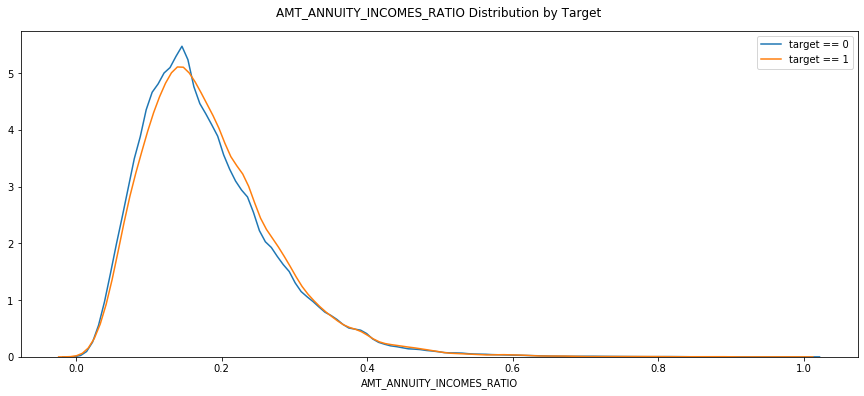

In [226]:
cols = ["AMT_ANNUITY_INCOMES_RATIO"]
analizer.plot_distributions(economics, cols, kind = "kdeplot", name = "Annuity.Incomes.Ratio_Economics")

#### 7) Reassemble the Puzzle

All the variables are highly correlated, let's keep only the ratio we computed. In addition, The ratio between credit and incomes is highly correlated with the other two ratios, we also drop it.

In [227]:
# Adjust DF:

In [228]:
# Reordering the columns:

economics = economics[['AMT_INCOME_TOTAL_LOG', 'AMT_CREDIT_LOG', 'AMT_ANNUITY_LOG','AMT_GOODS_PRICE_LOG', 'DURATION',
                       'AMT_CREDIT_INCOMES_RATIO', 'AMT_ANNUITY_INCOMES_RATIO']]

# Add again Target:

economics["TARGET"] = train["TARGET"]

In [229]:
# Study correlation:

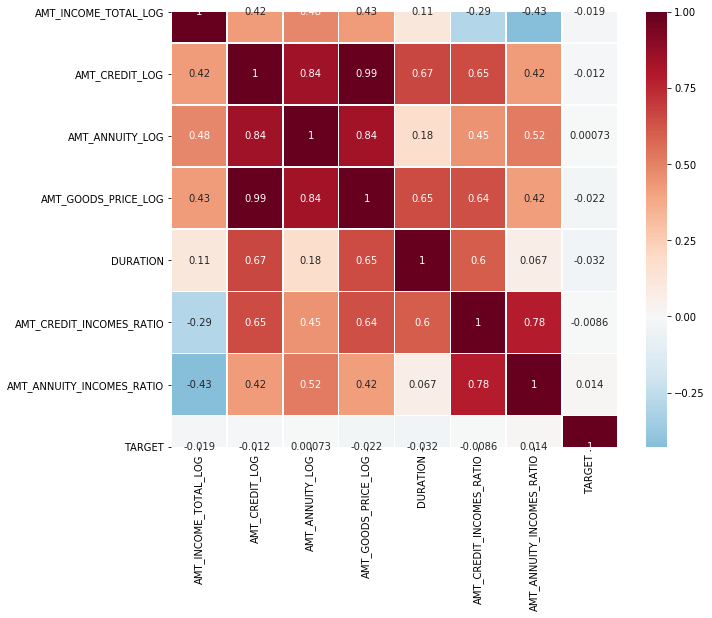

In [230]:
analizer.cor_plot(economics, an = True, name = "Final_Economics")

In [231]:
economics = economics.drop(columns = ['AMT_INCOME_TOTAL_LOG', 'AMT_CREDIT_LOG', 'AMT_ANNUITY_LOG',
                                      'AMT_GOODS_PRICE_LOG','AMT_CREDIT_INCOMES_RATIO'])

#### 9) Missing Values:

In [232]:
# Check missing values:

In [233]:
proportions(economics)

poms      pobs
DURATION                   0.000146  0.999854
AMT_ANNUITY_INCOMES_RATIO  0.000150  0.999850
TARGET                     0.000000  1.000000

In [234]:
# Fill:

In [235]:
'''tools.imputer(economics, "AMT_ANNUITY_INCOMES_RATIO", method = 'median')
tools.imputer(economics, "DURATION", method = 'median')'''

'tools.imputer(economics, "AMT_ANNUITY_INCOMES_RATIO", method = \'median\')\ntools.imputer(economics, "DURATION", method = \'median\')'

#### 8) Add the variables to the final DF:

In [236]:
final_train = pd.concat([final_train, economics.iloc[:,:-1]], axis = 1)

In [237]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  SOCIAL_DEFAUL_RATIO_60  \
0      0.139376               0                  0                     1.0   
1      0.535276               0                  0                     0.0   
2      0.729567               0                  1                     NaN   
3      0.535276               0                  0                     0.0   
4      0.535276               1                  0                     NaN   

   TOT_ENQUIRES_YEARLY  CONTRACT_TYPE_Cash loans  DURATION  \
0                  1.0                         1      16.0   
1                  0.0                         1      36.0   
2                  0.0                         0      20.0   
3                  NaN                         1      11.0   
4                  0.0                         1      23.0   

   AMT_ANNUITY_INCOMES_RATIO  
0                   0.121978  
1                   0.132217  
2                   0.100000  
3                   0.219900  
4                   0.179963

### Personal Informations:

#### 1) Create the DF:

In [238]:
personalInf = train[['CODE_GENDER','DAYS_BIRTH', 'NAME_EDUCATION_TYPE']]

#### 2) Study the continious variable:

There isn't any outlayer, but ages like 70 are strange. After checking we can say that they are not outlayers, the amount, duration and fraction of annuity on the total outcome is reasonable. In our opinion, giving a loan with a duration of 15 year to a client which is almost 70 years old and with a low income is dangerous. But Data denays our hp: younger people have a higher probability not to repay the loan,instead people older that 40 years old repays the loan.

In [239]:
# Transform age in years:

In [240]:
personalInf["YEARS_BIRTH"] = personalInf["DAYS_BIRTH"].apply(lambda x: -int(x/365))

In [241]:
# Check outlayers:

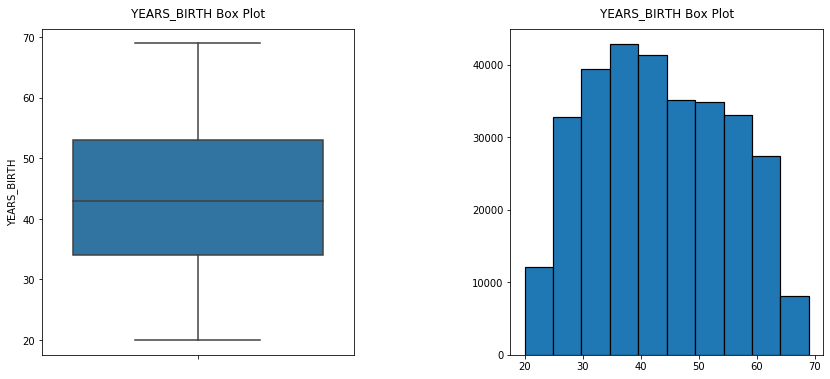

In [242]:
analizer.box_hist(personalInf, "YEARS_BIRTH", name = "Age_Personal")

In [243]:
idx = personalInf[personalInf["YEARS_BIRTH"] == 69].index
print(pd.concat([train[["AMT_CREDIT", "AMT_INCOME_TOTAL"]].iloc[idx, ],
                 economics[["DURATION", "AMT_ANNUITY_INCOMES_RATIO"]].iloc[idx, ]], axis = 1))

        AMT_CREDIT  AMT_INCOME_TOTAL  DURATION  AMT_ANNUITY_INCOMES_RATIO
63316     112500.0           61830.0      10.0                   0.179330
65237     126000.0           90000.0      11.0                   0.131000
79852     112500.0           90000.0      10.0                   0.123600
124430    225000.0          180000.0      11.0                   0.118200
130108    225000.0          112500.0      10.0                   0.196000
...            ...               ...       ...                        ...
226213    162000.0          171000.0      10.0                   0.093053
265026   2250000.0          450000.0      10.0                   0.500000
271258    225000.0          157500.0      10.0                   0.139171
276202    225000.0          166500.0      10.0                   0.132432
282013    225000.0          225000.0      10.0                   0.098000

[16 rows x 4 columns]


In [244]:
# Let's study the impact on our TARGET:

In [245]:
personalInf["TARGET"] = train["TARGET"]

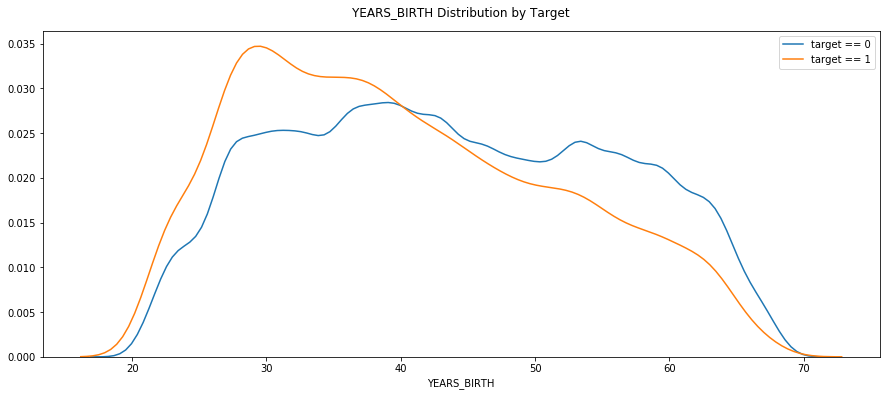

In [246]:
analizer.plot_distributions(personalInf, ["YEARS_BIRTH"], kind = "kdeplot", name = "Years_Personal")

In [247]:
# Kde Plot:

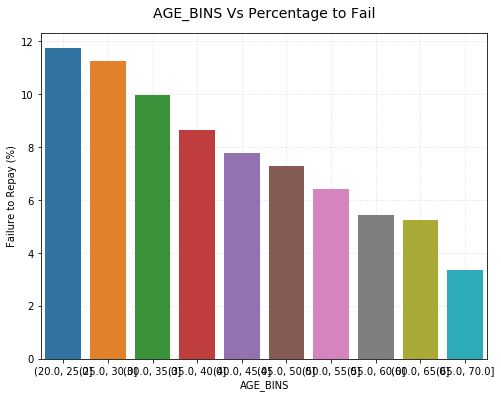

In [248]:
# Create the bins:

personalInf["AGE_BINS"] = pd.cut(personalInf["YEARS_BIRTH"], bins = np.linspace(20, 70, num = 11))

# Plot

analizer.bins_impact(personalInf, ["AGE_BINS"], rot = 45)

In [249]:
# Check NA:

In [250]:
proportions(personalInf[["YEARS_BIRTH"]])

poms  pobs
YEARS_BIRTH   0.0   1.0

#### 3.1) Study categorical variables: Gender

There are some NA in gender, but it may be because of someone perfers not to declear, anyway in this case the NA are so few that is better to impute with the mode, rather than create a new category. It seems male clients are far more likely not to repay.

In [251]:
# Check NA:

In [252]:
personalInf['CODE_GENDER'].unique()

array(['M', 'F', 'XNA'], dtype=object)

In [253]:
round(len(personalInf[personalInf['CODE_GENDER'] == "XNA"])/len(personalInf)*100, 3)

0.001

In [254]:
proportions(personalInf[['CODE_GENDER']])

poms  pobs
CODE_GENDER   0.0   1.0

In [255]:
# Study the distribution:

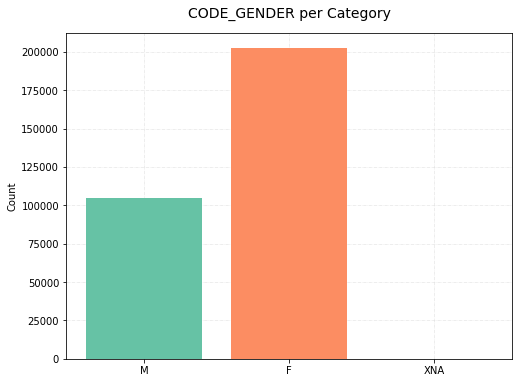

In [256]:
analizer.bar_plot(personalInf, ['CODE_GENDER'], name = "Gender_Personal")

In [257]:
# Study the impact:

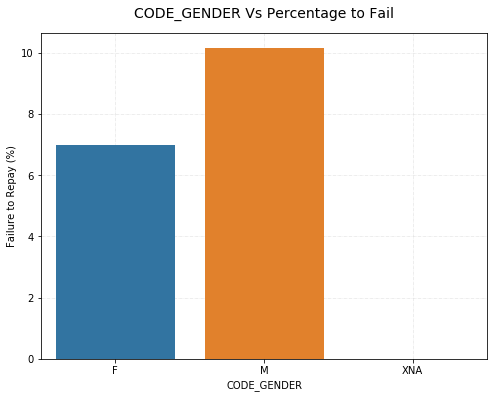

In [258]:
analizer.bins_impact(personalInf, ["CODE_GENDER"])

#### 3.2) Study categorical variables: Education

This variable dosen't have any NA, but it is highly asymmetric because it has too many categories, so we will group it as follow:

- Secondary or less: Secondary / seocnary special + Lower Secondary + Incomplete
- Higher Education: Higher education + Academic Degree

At the end of the process the simmetry has not been reached, but now is better than before. As we can expect, clients with a lower education have hugher prob not to repay the loan.

In [259]:
personalInf['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [260]:
proportions(personalInf[['NAME_EDUCATION_TYPE']])

poms  pobs
NAME_EDUCATION_TYPE   0.0   1.0

In [261]:
# Group categories:

In [262]:
personalInf.loc[personalInf['NAME_EDUCATION_TYPE'] == 'Incomplete higher', 'NAME_EDUCATION_TYPE'] = 'Secondary / secondary special'
personalInf.loc[personalInf['NAME_EDUCATION_TYPE'] == 'Academic degree', 'NAME_EDUCATION_TYPE'] = 'Higher education'
personalInf.loc[personalInf['NAME_EDUCATION_TYPE'] == 'Secondary / secondary special', 'NAME_EDUCATION_TYPE'] = 'Secondary or Less'
personalInf.loc[personalInf['NAME_EDUCATION_TYPE'] == 'Lower secondary', 'NAME_EDUCATION_TYPE'] = 'Secondary or Less'


In [263]:
# Study distribution:

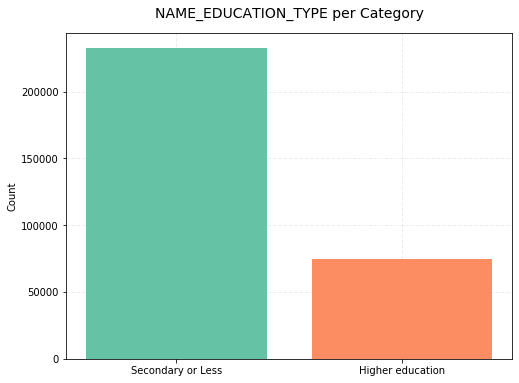

In [264]:
analizer.bar_plot(personalInf, ['NAME_EDUCATION_TYPE'], name = "Education_Personal")

In [265]:
# Study the impact:

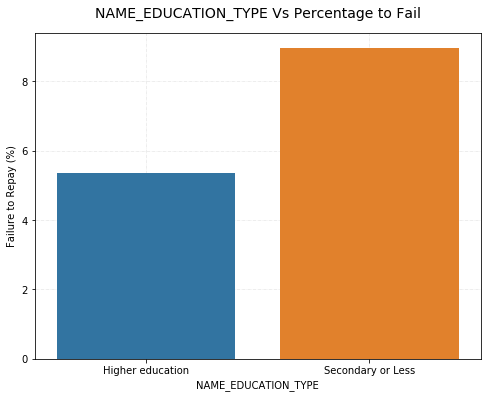

In [266]:
analizer.bins_impact(personalInf, ['NAME_EDUCATION_TYPE'])

#### 4) General Analysis:

The variables are not highly correlated, we just have to drop a category per column in order to avoid dummy trap.

In [267]:
# Adjust DF:

In [268]:
# Fill NA:

personalInf.loc[personalInf["CODE_GENDER"] == "XNA", "CODE_GENDER"] = "F"

# Drop the columns we don't need:

personalInf = personalInf[["YEARS_BIRTH", "CODE_GENDER", "NAME_EDUCATION_TYPE"]]

# Transform in dummies:

personalInf = pd.get_dummies(personalInf)

# Add Target:

personalInf["TARGET"] = train["TARGET"]

In [269]:
personalInf.head()

YEARS_BIRTH  CODE_GENDER_F  CODE_GENDER_M  \
0           25              0              1   
1           45              1              0   
2           52              0              1   
3           52              1              0   
4           54              0              1   

   NAME_EDUCATION_TYPE_Higher education  \
0                                     0   
1                                     1   
2                                     0   
3                                     0   
4                                     0   

   NAME_EDUCATION_TYPE_Secondary or Less  TARGET  
0                                      1       1  
1                                      0       0  
2                                      1       0  
3                                      1       0  
4                                      1       0

In [270]:
# Correlation:

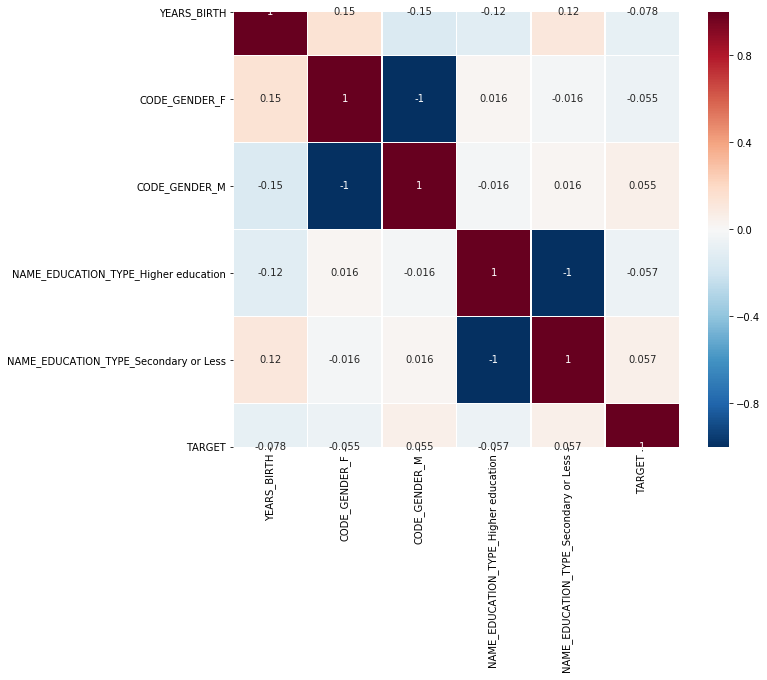

In [271]:
analizer.cor_plot(personalInf, an = True, name = "Info_Personal")

In [272]:
personalInf = personalInf.drop(columns = ["CODE_GENDER_F", "NAME_EDUCATION_TYPE_Higher education", "TARGET"])

#### 5) Add to final DF:

In [273]:
final_train = pd.concat([final_train, personalInf], axis = 1)

In [274]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  SOCIAL_DEFAUL_RATIO_60  \
0      0.139376               0                  0                     1.0   
1      0.535276               0                  0                     0.0   
2      0.729567               0                  1                     NaN   
3      0.535276               0                  0                     0.0   
4      0.535276               1                  0                     NaN   

   TOT_ENQUIRES_YEARLY  CONTRACT_TYPE_Cash loans  DURATION  \
0                  1.0                         1      16.0   
1                  0.0                         1      36.0   
2                  0.0                         0      20.0   
3                  NaN                         1      11.0   
4                  0.0                         1      23.0   

   AMT_ANNUITY_INCOMES_RATIO  YEARS_BIRTH  CODE_GENDER_M  \
0                   0.121978           25              1   
1                   0.132217           45              0   
2                   0.100000           52              1   
3                   0.219900           52              0   
4                   0.179963           54              1   

   NAME_EDUCATION_TYPE_Secondary or Less  
0                                      1  
1                                      0  
2                                      1  
3                                      1  
4                                      1

### Family info

#### 1) Create the DF:

In [275]:
family = train[['NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS','CNT_CHILDREN']]

#### 2) Numerical Variables:

It is clear that the numerical variables are correlated, moreover they have for sure outlayer, it seems quite irrealistic a family of 20 people, we replace all family with more than 10 children values with NA.

The distribution is skewned, the most of families have few memebers. As we can expected the two varibles are very highly correlated, instead of number of children, let's create a variable called  "HAS_CHILDREN" (1 = Yes, 0 = No). Also in this way the correlation is high, but before dropping anything, let's study and add the status).

At the moment, we cna just say that the number of elements in a family have a huge impact on the probability not to repay the loans.

In [276]:
# Outlayers:

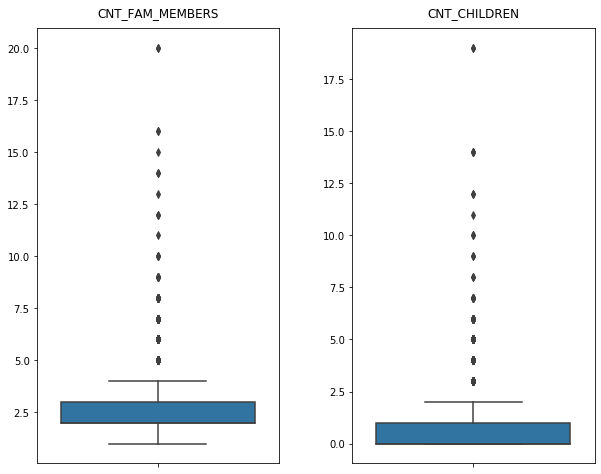

In [277]:
cols = ['CNT_FAM_MEMBERS','CNT_CHILDREN']
analizer.Box_Plots(family, cols, nrow = 1, ncol = 2, size = (10, 8), name = "Family")

In [278]:
family.loc[family["CNT_CHILDREN"] > 10, 'CNT_FAM_MEMBERS'] = np.nan
family.loc[family["CNT_CHILDREN"] > 10, 'CNT_CHILDREN'] = np.nan

In [279]:
# Study the distribution:

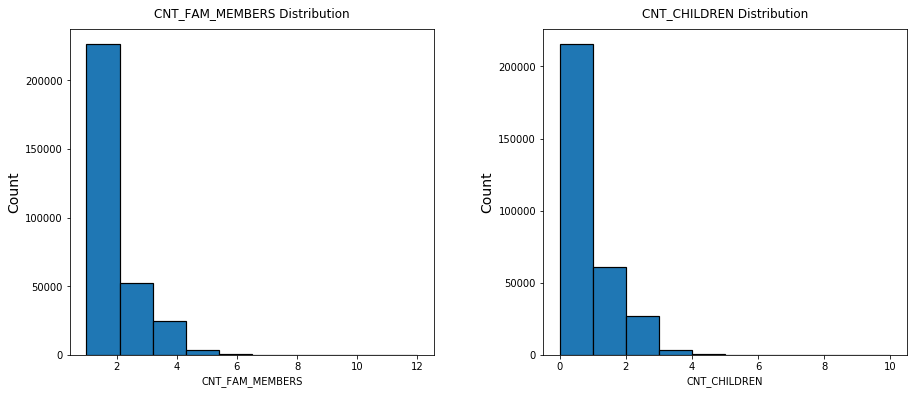

In [280]:
analizer.plot_distributions(family, cols, nrow = 1, ncol = 2, kind = "histogram", name = "Family")

In [281]:
# Correlation:

In [282]:
family[["CNT_CHILDREN", "CNT_FAM_MEMBERS"]].corr()

CNT_CHILDREN  CNT_FAM_MEMBERS
CNT_CHILDREN         1.000000         0.878412
CNT_FAM_MEMBERS      0.878412         1.000000

In [283]:
# Create variable "HAS_CHILDREN"

In [284]:
# New columns:

family.insert(2, "HAS_CHILDREN", "No")

# Fill Column:

family.loc[family["CNT_CHILDREN"] > 0, "HAS_CHILDREN"] = "Yes"
family.loc[family["CNT_CHILDREN"].isnull(), "HAS_CHILDREN"] = "XNA"

In [285]:
# importance:

In [286]:
family["TARGET"] = train["TARGET"]

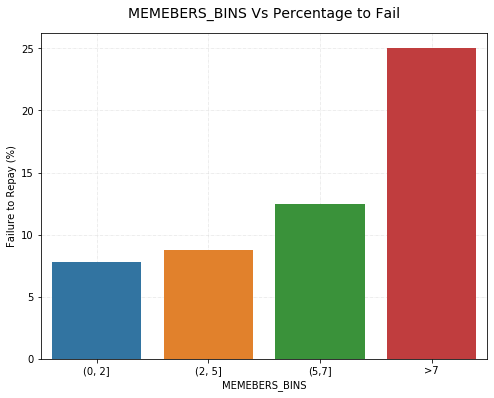

In [287]:
# Add importance:

family["TARGET"] = train["TARGET"]

# Generate the grouped DF:

family["MEMEBERS_BINS"] = pd.cut(family["CNT_FAM_MEMBERS"], bins = [0, 2, 5, 7, np.inf], 
                                           labels = ["(0, 2]", "(2, 5]", "(5,7]", ">7"])

# Plot:

analizer.bins_impact(family, ["MEMEBERS_BINS"])

#### 3) Categorical Variables

Also in this case it is possible to group categories of variable Family, because they are asymmetric. The groups follow this order:

- Not Married: Single / not married + Separated + Widow
- Married: 'Civil marriage + 'Married' 

It is clear that grouping the categories, a big dlice of variance is cut off. So it is better to keep the original categories. This idea is also confirmed by the ANOVA.

In [288]:
# Study the Distribution:

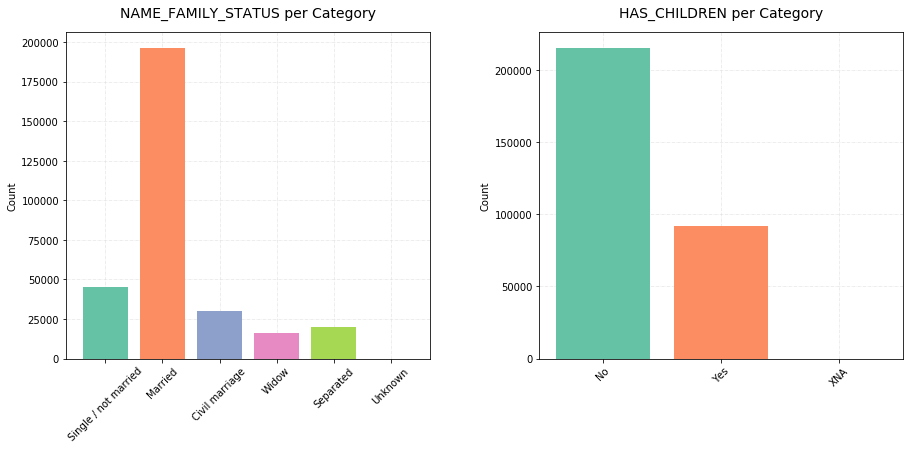

In [289]:
cols = ['NAME_FAMILY_STATUS', "HAS_CHILDREN"]
analizer.bar_plot(family, cols, nrow = 1, ncol = 2, rot = 45, size = (15, 6),name = "Cat_Family")

In [290]:
# Group The categories of Family:

In [291]:
family.insert(4, "MARRIED", "NO")

family.loc[(family['NAME_FAMILY_STATUS'] == "Civil marriage") | (family['NAME_FAMILY_STATUS'] == "Married"), 
                  'MARRIED'] = "Yes"
family.loc[(family['NAME_FAMILY_STATUS'] == "Separated") | (family['NAME_FAMILY_STATUS'] == "Widow") |
          (family['NAME_FAMILY_STATUS'] == "Single / not married"), 'MARRIED'] = "No"
family.loc[family['NAME_FAMILY_STATUS'] == "Unknown", 'MARRIED'] = "XNA"

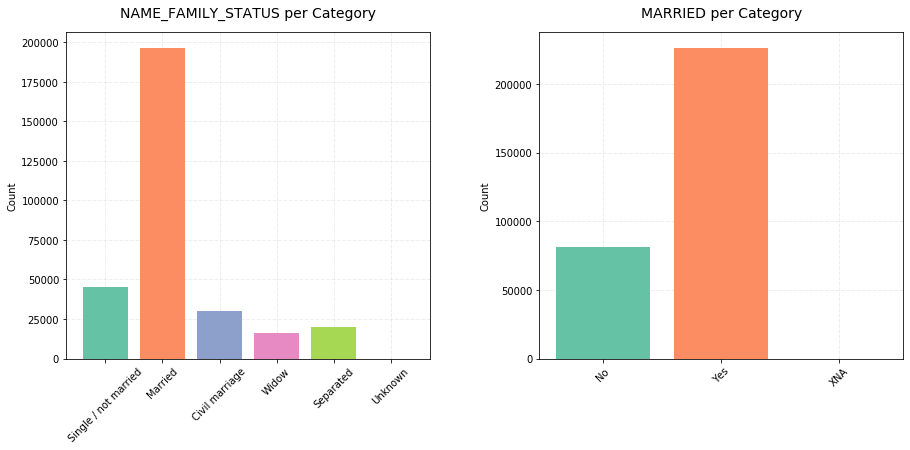

In [292]:
cols = ['NAME_FAMILY_STATUS', "MARRIED"]
analizer.bar_plot(family, cols, nrow = 1, ncol = 2, rot = 45, size = (15,6), name = "Married_Family")

In [293]:
# Study th importance:

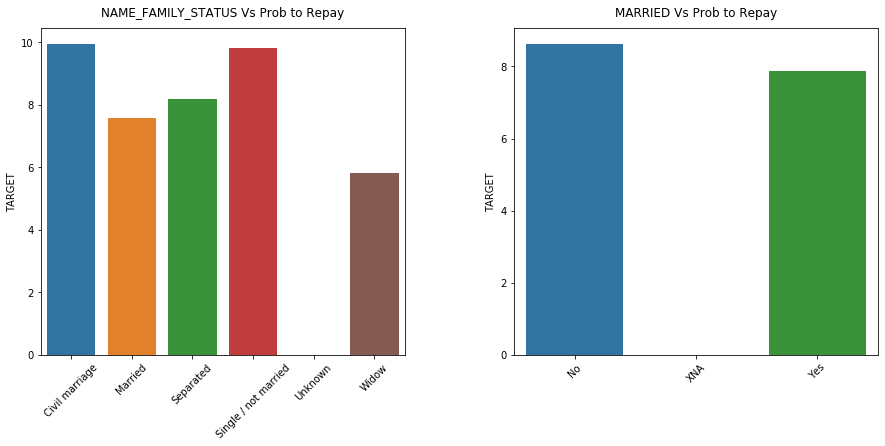

In [294]:
cols = ['NAME_FAMILY_STATUS', 'MARRIED']
analizer.bins_impact(family, cols, nrow = 1, ncol = 2, rot = 45, size = (15, 6))

In [295]:
# Transform categories in DUmmy:

In [296]:
family_dum = pd.get_dummies(family[["NAME_FAMILY_STATUS", "HAS_CHILDREN", "MARRIED"]])

In [297]:
#Study importance:

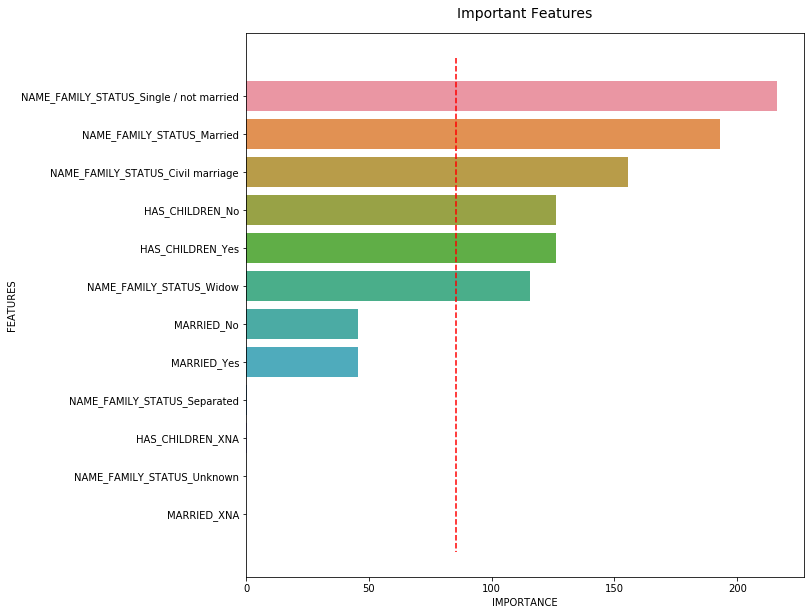

In [298]:
analizer.ANOVA_Importance(family_dum, train, name = "Family_Importance")

#### 4) Work with the whole DF:

We have seen above that the ANOVA suggest us to keep the original variable. In addition, having only two categories creates some problems of correlation between variables. Instead keeping the originals and dropping married, the correlation matrix is better.

As we have alredy observed, number of children and number of family memeber are highly correlated, we also drop the count of children. In general, number of members is correlated with all of the other variables, but it is also the most correlated with the target. At this point is hard to choose what to drop. Let's do ANOVA again to see the importance of teh variables: it suggests us to remove CNT_CHILDREN.

For the replacing of NA of HAS_CHILDREN, we drop the column XNA and we add 1 to the positions of XNA = 1, on the column which already has the most of the values (Have_CHILDRE_Yes). We also drop Has children Yes in order to avoid multicollinearity.

In [299]:
# Prepear the DF:

In [300]:
# Drop Unused columns:
family = family.drop(columns = ["MEMEBERS_BINS", "TARGET"])
# Generate Dummies:
family = pd.get_dummies(family)
# Add target:
family["TARGET"] = train["TARGET"]

In [301]:
# Study Correlation:

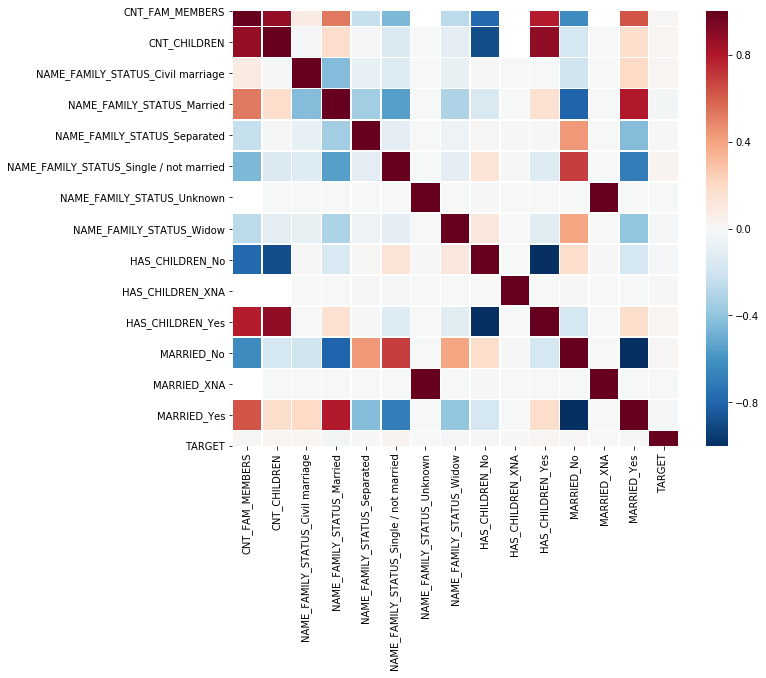

In [302]:
analizer.cor_plot(family, an = False, name = "All_Family")

In [303]:
# Drop columns:

In [304]:
family = family.drop(columns = ["MARRIED_No", "MARRIED_Yes", "MARRIED_XNA", "NAME_FAMILY_STATUS_Married", 
                                "CNT_CHILDREN"])

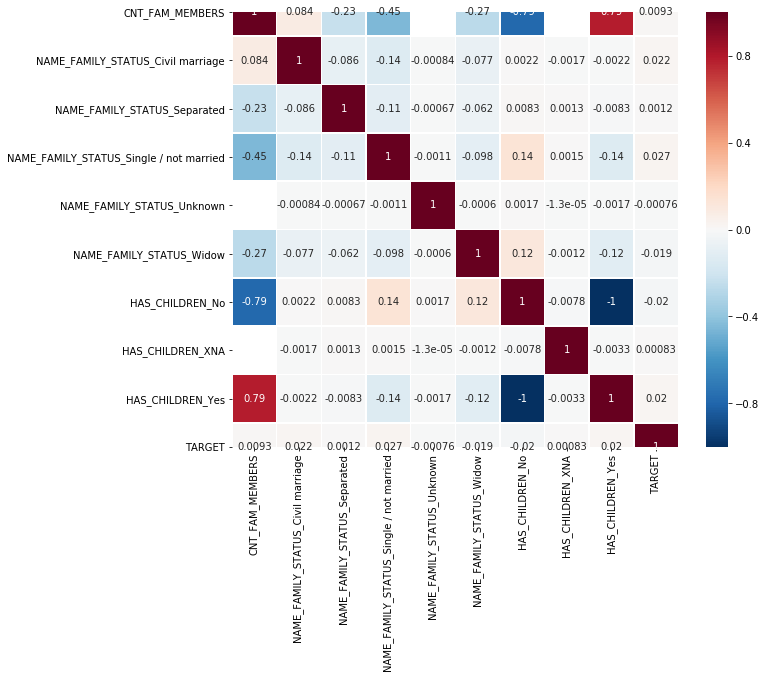

In [305]:
analizer.cor_plot(family, an = True, name = "All.2_Family")

In [306]:
# Fill Na:

In [307]:
tools.imputer(family, "CNT_FAM_MEMBERS", method = "mean")

In [308]:
# Study Importance:

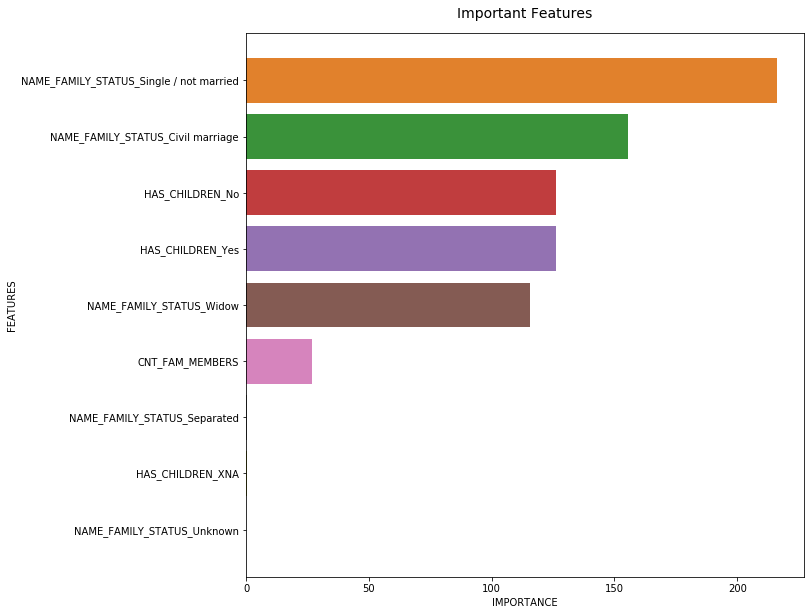

In [309]:
analizer.ANOVA_Importance(family, train, name = "Family.3_Importance")

In [310]:
# Drop CNT_FAMILY_MEMEBERS:

In [311]:
family = family.drop("CNT_FAM_MEMBERS", axis = 1)

In [312]:
# Adjust HAS_CHILDREN:

In [313]:
idx = family[family["HAS_CHILDREN_XNA"] == 1].index
family.iloc[idx, 7] = 1

In [314]:
family = family.drop(columns=["HAS_CHILDREN_XNA", "HAS_CHILDREN_No"])

In [315]:
family["HAS_CHILDREN_Yes"] = family["HAS_CHILDREN_Yes"].astype('uint8')

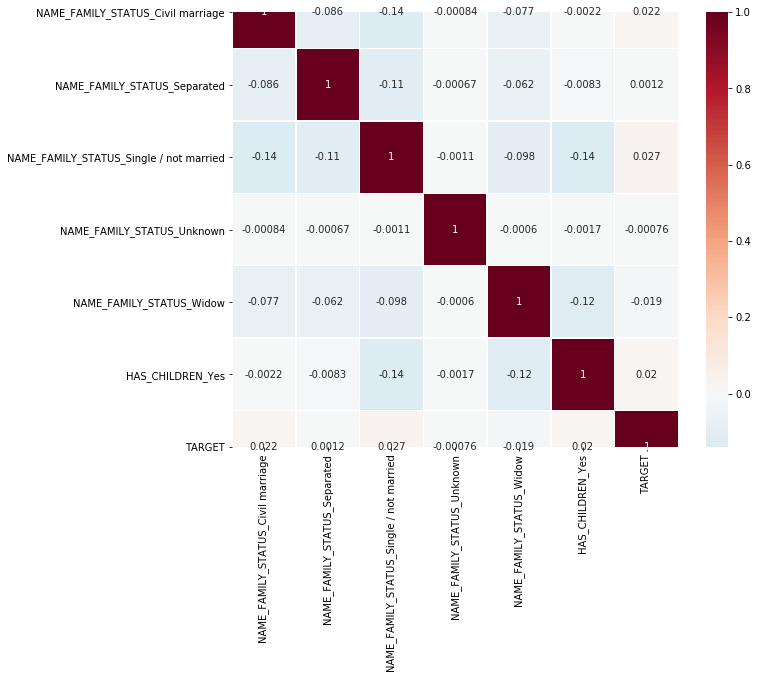

In [316]:
analizer.cor_plot(family, an = True, name = "Final_Family")

In [317]:
# Remove Uknow (consider as NA):
fam_mod = train["NAME_FAMILY_STATUS"].mode()
idx = family[family["NAME_FAMILY_STATUS_Unknown"] == 1].index
family.iloc[idx, 3] = 1
family = family.drop("NAME_FAMILY_STATUS_Unknown", axis = 1)

#### 5) Add to the final DF:

In [318]:
family = family.drop("TARGET", axis = 1)

In [319]:
final_train = pd.concat([final_train, family], axis = 1)

In [320]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  DURATION  \
0      0.139376               0                  0  ...      16.0   
1      0.535276               0                  0  ...      36.0   
2      0.729567               0                  1  ...      20.0   
3      0.535276               0                  0  ...      11.0   
4      0.535276               1                  0  ...      23.0   

   AMT_ANNUITY_INCOMES_RATIO  YEARS_BIRTH  CODE_GENDER_M  \
0                   0.121978           25              1   
1                   0.132217           45              0   
2                   0.100000           52              1   
3                   0.219900           52              0   
4                   0.179963           54              1   

   NAME_EDUCATION_TYPE_Secondary or Less  NAME_FAMILY_STATUS_Civil marriage  \
0                                      1                                  0   
1                                      0                                  0   
2                                      1                                  0   
3                                      1                                  1   
4                                      1                                  0   

   NAME_FAMILY_STATUS_Separated  NAME_FAMILY_STATUS_Single / not married  \
0                             0                                        1   
1                             0                                        0   
2                             0                                        1   
3                             0                                        0   
4                             0                                        1   

   NAME_FAMILY_STATUS_Widow  HAS_CHILDREN_Yes  
0                         0                 0  
1                         0                 0  
2                         0                 0  
3                         0                 0  
4                         0                 0  

[5 rows x 23 columns]

### Contact Information:

In [321]:
contact = train[['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_WORK_PHONE',
                 'DAYS_LAST_PHONE_CHANGE','FLAG_EMAIL']]

#### 1) Numerical variable:

The distribution is skwened the most have changed therefore within the last 3 years, the one at the extreme of the distribution have got the same phone for 10 years, it is not impossible. Moreover, we must take in account that probabily this DataFrame is referred to a poor Country.

After converting days in year, we can see that the whom has changed the phone within last three years have a higher likelyhood to default, with an exception for who has just changed it. After three years the tendency changes.

In [322]:
#Transform in Years:

In [323]:
contact['YEARS_LAST_PHONE_CHANGE'] = contact['DAYS_LAST_PHONE_CHANGE'].apply(lambda x: -x/365)

In [324]:
# Study Distribution and outlayers:

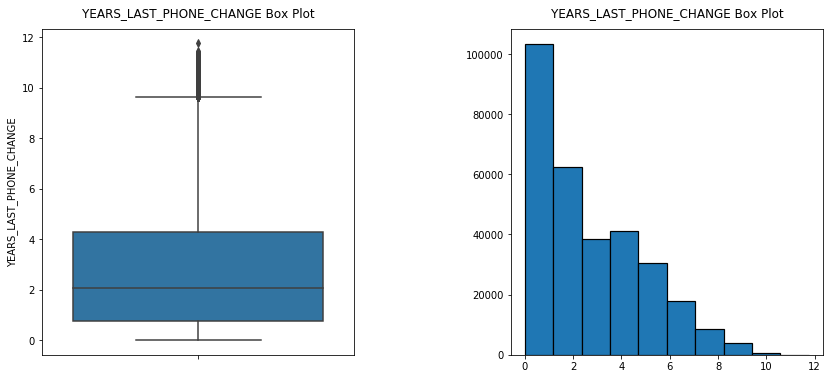

In [325]:
analizer.box_hist(contact, 'YEARS_LAST_PHONE_CHANGE', name = "Days_Contact")

In [326]:
# Check the impact:

In [327]:
contact["TARGET"] = train["TARGET"]

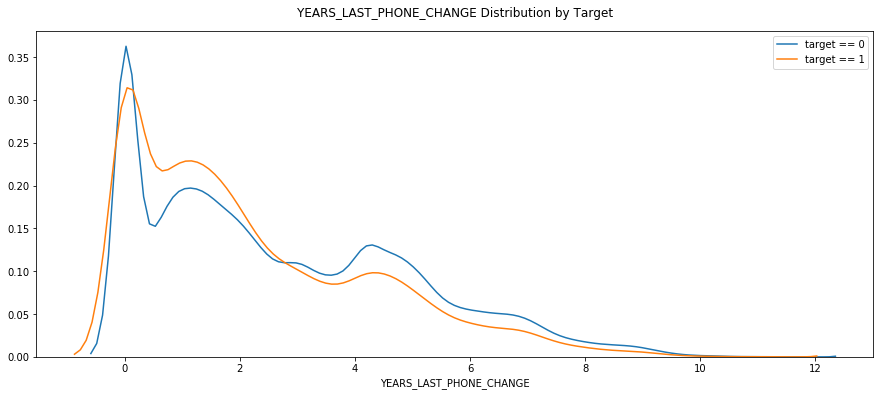

In [328]:
analizer.plot_distributions(contact, ['YEARS_LAST_PHONE_CHANGE'], kind = "kdeplot", name = "Phone_Contact")

#### 2) Study Categorical variables:

It seems that anybody gave a monile phone number and that this is reachable, insted only few provided the phone (the one at home), but who did has a higher prob to repay the loan. Instead, who provided (the most) an employ mobile/phone have a higher ratio not to repay (it is strange). For the other information there is not useful informatio (same prob to repay or not). Finally, anly few peple proveded email, but it seems that dosen't have an impact on the probability to repay.

In [329]:
# Transform in dummys:

In [330]:
cols = ['FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_WORK_PHONE', 'FLAG_EMAIL']
for c in cols:

    contact.loc[contact[c] == 1, c] = "Yes"
    contact.loc[contact[c] == 0, c] = "No"

In [331]:
# Check the distribution:

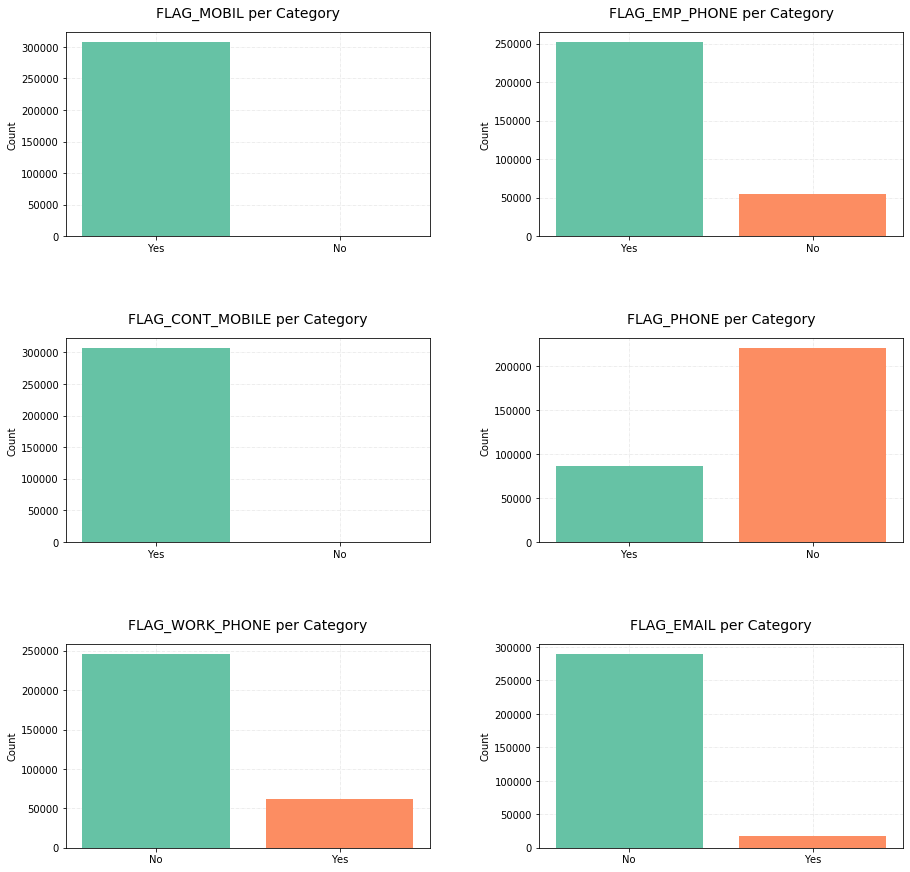

In [332]:
analizer.bar_plot(contact, cols, nrow = 3, ncol = 2, size = (15,15), name = "Cat_Contact")

In [333]:
# Study importance:

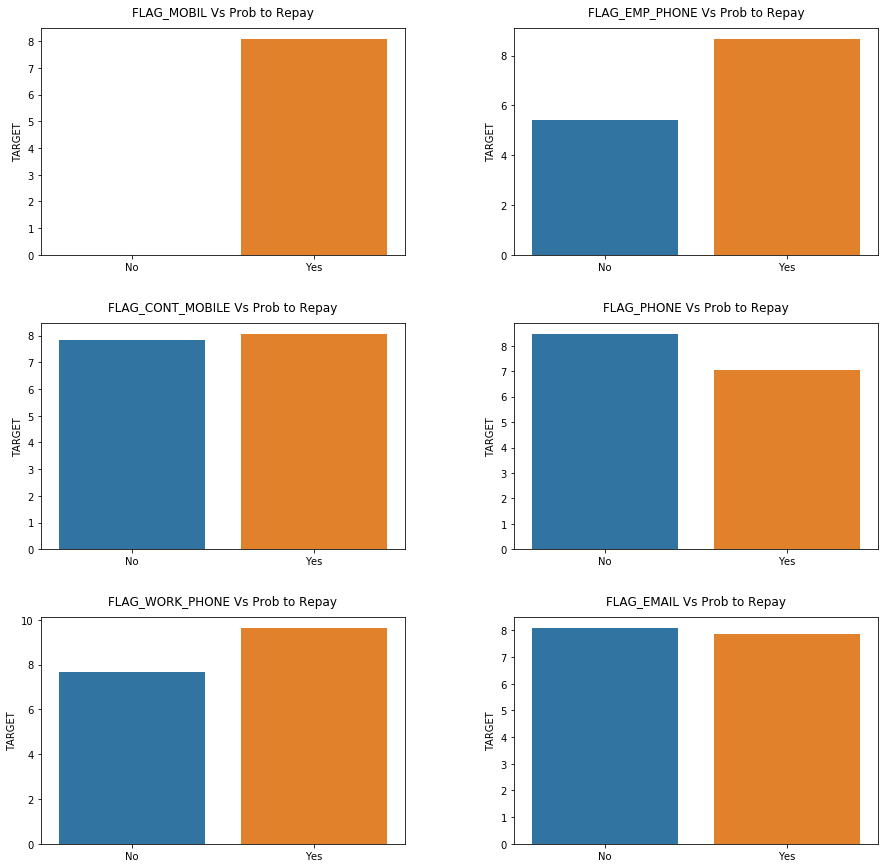

In [334]:
analizer.bins_impact(contact, cols, nrow = 3, ncol = 2, size = (15, 15))

#### 3) All together

In general the variables are not correlated each other, there is only a high correlation among FLAG_PHONE anf FLAG_WORK, it is difficult to say why, because there isn't a clear info about this variable, maybe it is the work phone and some people work at home, so it is the same. Anyway, the correlation is around 20% and the variables seems both important, so for the moment we keep both of them.

According to ANOVA test Mobiel e CNT_MOBIle don't expalin much about the variability of the system, it is reasonable, because all of them are 1 (same values). SO we drop them. also email, as we have seen before dosen't tell anything about our model,but for the moment we keep it.


In [335]:
# Adjust DF:

In [336]:
# Drop Target and DAYS..:

contact = contact.drop(columns = ['DAYS_LAST_PHONE_CHANGE', "TARGET"])

# Transform in dummies:

contact = pd.get_dummies(contact)

# Add Target:

contact["TARGET"] = train["TARGET"]

In [337]:
# Correlation:

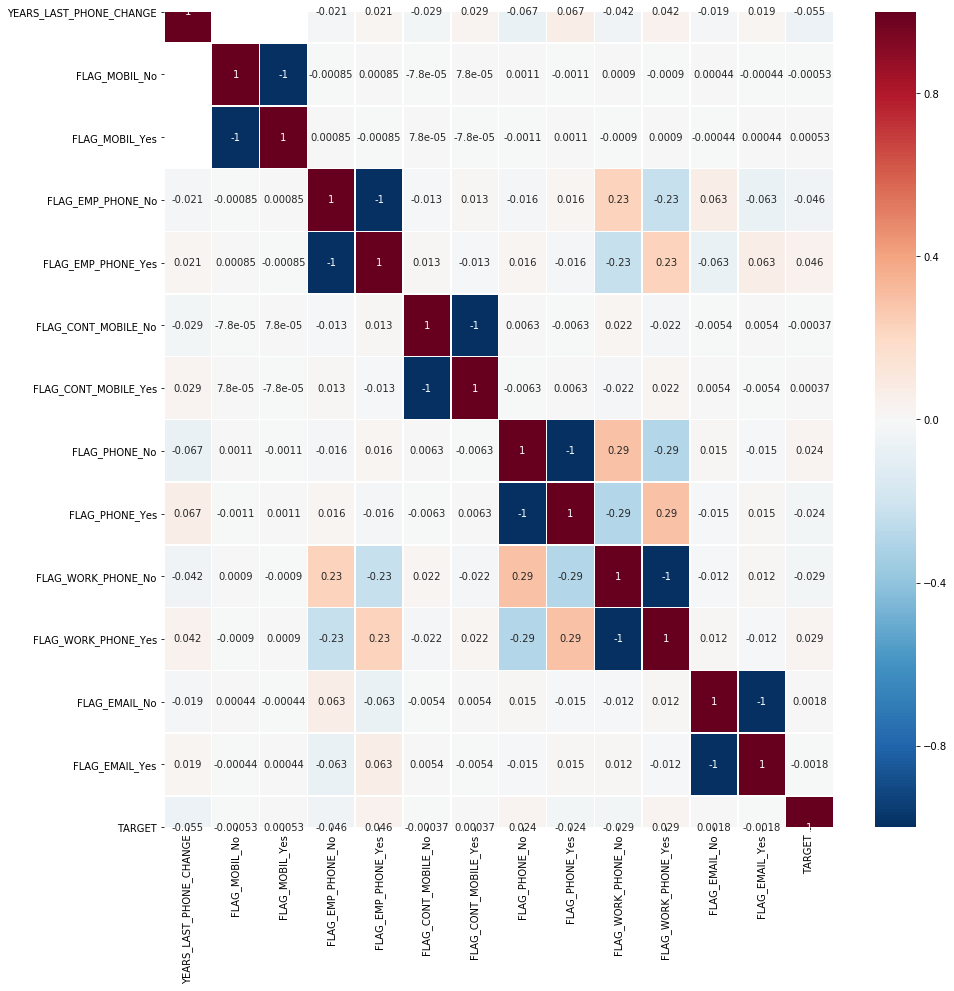

In [338]:
analizer.cor_plot(contact, an = True, size = (15, 15), name = "Contact")

In [339]:
# Drop Columns to remove multicollinearity:

In [340]:
contact = contact.drop(columns = ['FLAG_EMP_PHONE_No','FLAG_MOBIL_No', 'FLAG_CONT_MOBILE_No', 'FLAG_PHONE_Yes',
                                 'FLAG_WORK_PHONE_No', 'FLAG_EMAIL_No'])

In [341]:
# Fill NA:

In [342]:
proportions(contact)

poms      pobs
YEARS_LAST_PHONE_CHANGE  0.000003  0.999997
FLAG_MOBIL_Yes           0.000000  1.000000
FLAG_EMP_PHONE_Yes       0.000000  1.000000
FLAG_CONT_MOBILE_Yes     0.000000  1.000000
FLAG_PHONE_No            0.000000  1.000000
FLAG_WORK_PHONE_Yes      0.000000  1.000000
FLAG_EMAIL_Yes           0.000000  1.000000
TARGET                   0.000000  1.000000

In [343]:
t_last = contact["YEARS_LAST_PHONE_CHANGE"].to_list()

In [344]:
tools.imputer(contact, "YEARS_LAST_PHONE_CHANGE", method = "median")

In [345]:
# Check Importance:

In [346]:
contact.columns

Index(['YEARS_LAST_PHONE_CHANGE', 'FLAG_MOBIL_Yes', 'FLAG_EMP_PHONE_Yes',
       'FLAG_CONT_MOBILE_Yes', 'FLAG_PHONE_No', 'FLAG_WORK_PHONE_Yes',
       'FLAG_EMAIL_Yes', 'TARGET'],
      dtype='object')

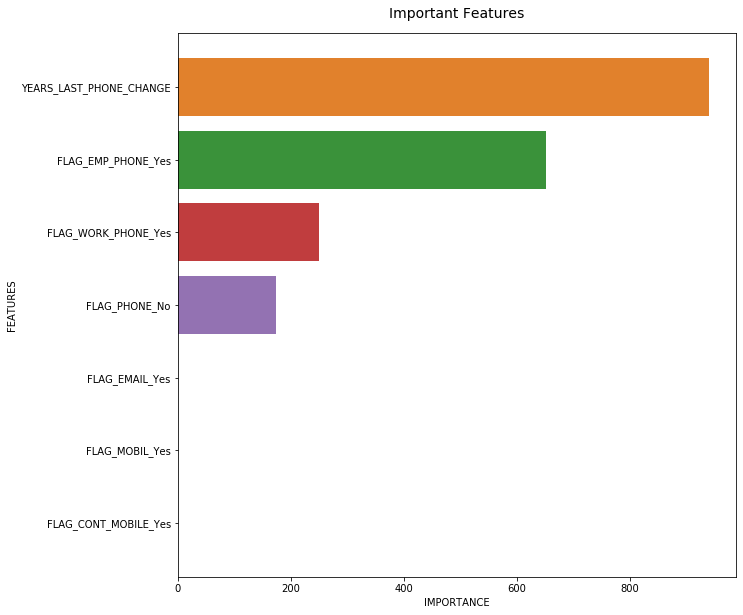

In [347]:
analizer.ANOVA_Importance(contact, train, name = "Contact")

In [348]:
# Drop columns:

In [349]:
contact = contact.drop(columns = ["FLAG_MOBIL_Yes", "FLAG_CONT_MOBILE_Yes"])

In [350]:
contact["YEARS_LAST_PHONE_CHANGE"] = t_last

#### 4) Add to the final DF:

In [351]:
# Adjust DF:

In [352]:
contact = contact.iloc[:, :-1]

In [353]:
final_train = pd.concat([final_train, contact], axis = 1)

In [354]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  \
0      0.139376               0                  0  ...   
1      0.535276               0                  0  ...   
2      0.729567               0                  1  ...   
3      0.535276               0                  0  ...   
4      0.535276               1                  0  ...   

   NAME_FAMILY_STATUS_Civil marriage  NAME_FAMILY_STATUS_Separated  \
0                                  0                             0   
1                                  0                             0   
2                                  0                             0   
3                                  1                             0   
4                                  0                             0   

   NAME_FAMILY_STATUS_Single / not married  NAME_FAMILY_STATUS_Widow  \
0                                        1                         0   
1                                        0                         0   
2                                        1                         0   
3                                        0                         0   
4                                        1                         0   

   HAS_CHILDREN_Yes  YEARS_LAST_PHONE_CHANGE  FLAG_EMP_PHONE_Yes  \
0                 0                 3.106849                   1   
1                 0                 2.268493                   1   
2                 0                 2.232877                   1   
3                 0                 1.690411                   1   
4                 0                 3.030137                   1   

   FLAG_PHONE_No  FLAG_WORK_PHONE_Yes  FLAG_EMAIL_Yes  
0              0                    0               0  
1              0                    0               0  
2              0                    1               0  
3              1                    0               0  
4              1                    0               0  

[5 rows x 28 columns]

### Property:

In [355]:
properties = train[['FLAG_OWN_CAR','OWN_CAR_AGE', 'FLAG_OWN_REALTY','NAME_HOUSING_TYPE','NAME_INCOME_TYPE']]

#### 1) Numerical variables:

The NAs are due to the fact the a persona dosen't have the car, the real NAs are only 5 and we replace them with the median. It's clear that there are outlayers, also a car of 60 years ago is pretty weird, but a car of almost 100 is really strange. We substitue with NAs all values grater than 65 years ago (more or less 1950). As we can expect people with a newer car (less than 15 years) have a higher probability to repay. It is really stranger, for people who has cars of the 50s the prob to default is lower.

In [356]:
# Check NA:

In [357]:
proportions(properties[["OWN_CAR_AGE"]])

poms      pobs
OWN_CAR_AGE  0.659908  0.340092

In [358]:
# Real NA

In [359]:
properties[(properties["OWN_CAR_AGE"].isnull()) & (properties["FLAG_OWN_CAR"] == "Y")]

FLAG_OWN_CAR  OWN_CAR_AGE FLAG_OWN_REALTY  NAME_HOUSING_TYPE  \
30897             Y          NaN               N  House / apartment   
181231            Y          NaN               N  House / apartment   
217549            Y          NaN               N  House / apartment   
229867            Y          NaN               Y  House / apartment   
236868            Y          NaN               Y  House / apartment   

            NAME_INCOME_TYPE  
30897                Working  
181231  Commercial associate  
217549               Working  
229867  Commercial associate  
236868  Commercial associate

In [360]:
#Distribution:

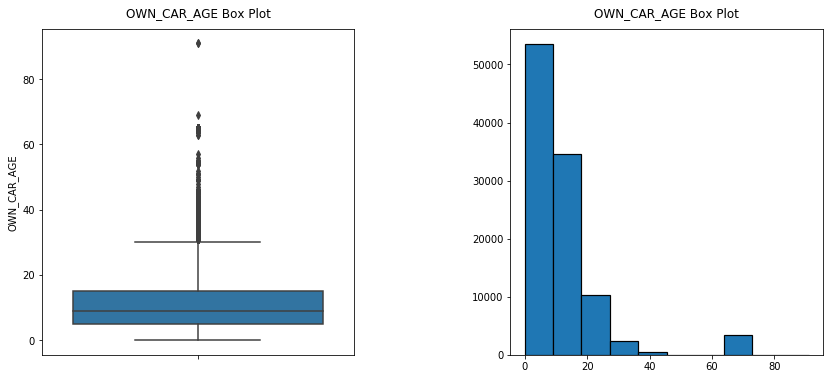

In [361]:
analizer.box_hist(properties, "OWN_CAR_AGE", name = "Car_Age")

In [362]:
# Remove outlayers:

In [363]:
properties.loc[properties["OWN_CAR_AGE"] > 65, "OWN_CAR_AGE"] = np.nan

In [364]:
# Normalize DIstribution:

In [365]:
properties["TARGET"] = train["TARGET"]

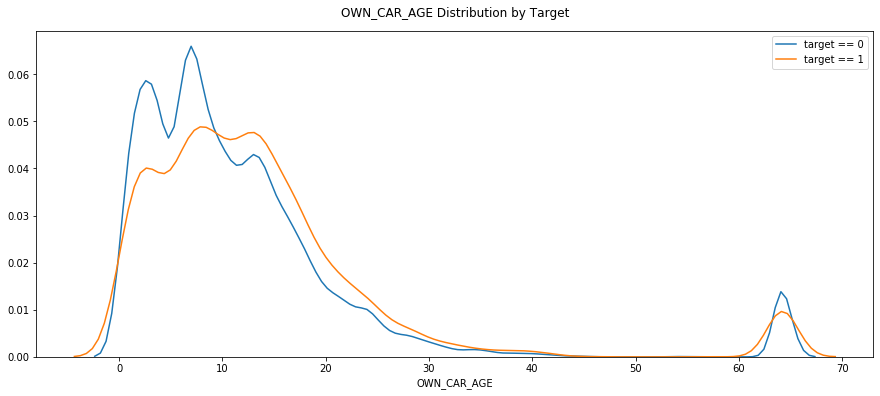

In [366]:
analizer.plot_distributions(properties, ["OWN_CAR_AGE"], kind = "kdeplot", name = "CarAge")

#### 2) Categorical Features

We can see that the most of people didn't have a car and maybe that's why they didn't provide info about the age of the car (probbily they are correlated), not having a car increases the probability of a default. The most of people have a house, however to have or not dosen't influence the prob of default.

For NAME_INCOME_TYPE we can group who work and who dosen't work or receive some kind of support, because many groups are very small and also haven't a big impact on our TARGET.

For NAME_HOUSE_TYPE we can group in the following way: house usually under a rent, parent, house usually already paid, office

In [367]:
# Distribution:

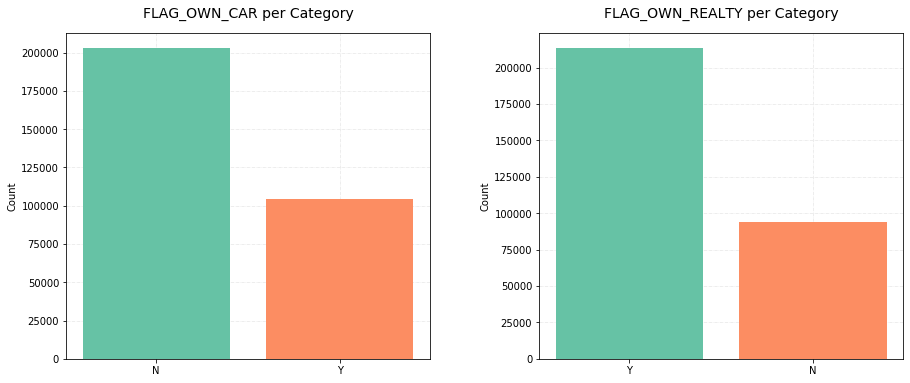

In [368]:
cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
analizer.bar_plot(properties, cols, nrow = 1, ncol = 2, size = (15,6), name = "cat1_Ownership")

In [369]:
# Importance

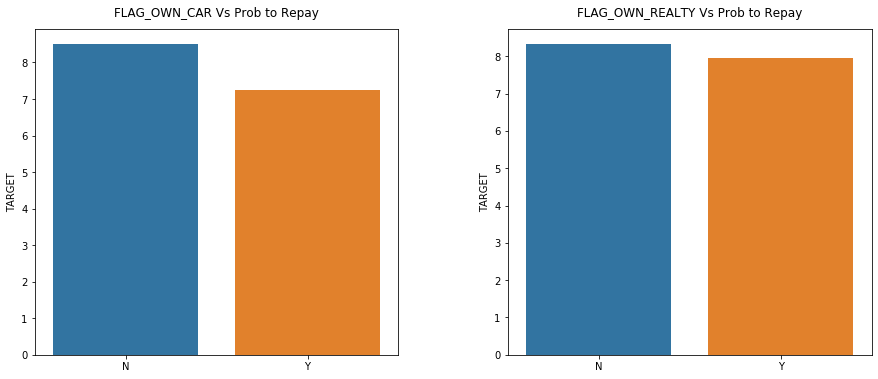

In [370]:
cols = ['FLAG_OWN_CAR','FLAG_OWN_REALTY']
analizer.bins_impact(properties, cols, nrow = 1, ncol = 2, size = (15,6))

In [371]:
# Distribution:

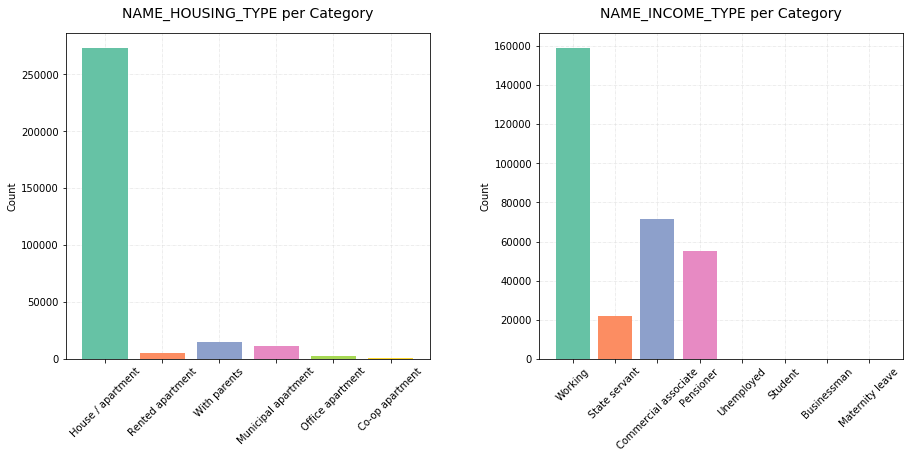

In [372]:
cols = ['NAME_HOUSING_TYPE','NAME_INCOME_TYPE']
analizer.bar_plot(properties, cols, nrow = 1, ncol = 2, rot = 45, size = (15,6), name = "Cat2_Ownership")

In [373]:
# Importance:

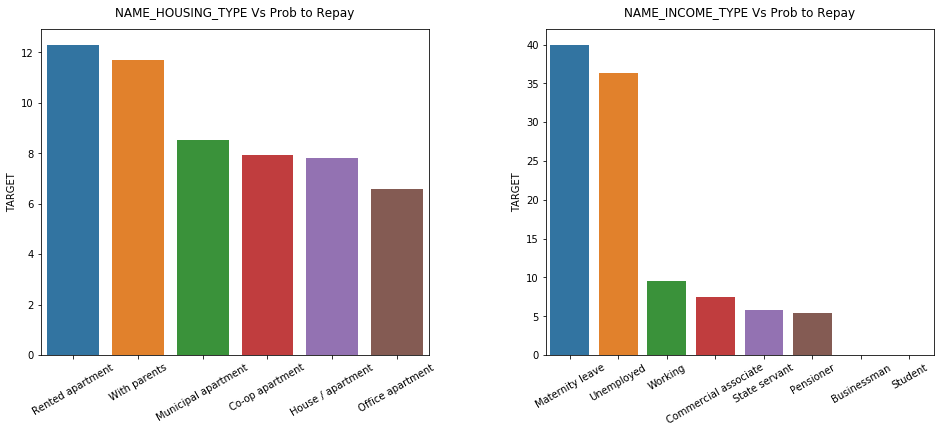

In [374]:
analizer.bins_impact(properties, cols, nrow = 1, ncol = 2, rot = 30, sort = True, size = (16,6))

In [375]:
# New variables:

In [376]:
properties.insert(4, "NAME_INCOME_TYPE_GROUPED", "")
properties.loc[(properties["NAME_INCOME_TYPE"] == "Maternity leave") | 
               (properties["NAME_INCOME_TYPE"] == "Unemployed") |
               (properties["NAME_INCOME_TYPE"] == "Student"), 
               "NAME_INCOME_TYPE_GROUPED"] = "Not working income / No income"
properties.loc[(properties["NAME_INCOME_TYPE"] != "Maternity leave") & 
               (properties["NAME_INCOME_TYPE"] != "Unemployed") &
               (properties["NAME_INCOME_TYPE"] != "Student"), 
               "NAME_INCOME_TYPE_GROUPED"] = "Working Income"

In [377]:
properties.insert(3, "NAME_HOUSING_TYPE_GROUPED", "")
properties.loc[(properties["NAME_HOUSING_TYPE"] == "Rented apartment") | 
               (properties["NAME_HOUSING_TYPE"] == "Municipal apartment") |
               (properties["NAME_HOUSING_TYPE"] == "Co-op apartment"), 
               "NAME_HOUSING_TYPE_GROUPED"] = "Subjected to a rent"
properties.loc[(properties["NAME_HOUSING_TYPE"] == "Office apartment"), 
               "NAME_HOUSING_TYPE_GROUPED"] = "Office"
properties.loc[(properties["NAME_HOUSING_TYPE"] == "With parents"), 
               "NAME_HOUSING_TYPE_GROUPED"] = "With parents"
properties.loc[(properties["NAME_HOUSING_TYPE"] == "House / apartment"), 
               "NAME_HOUSING_TYPE_GROUPED"] = "Not subjected to a rent"

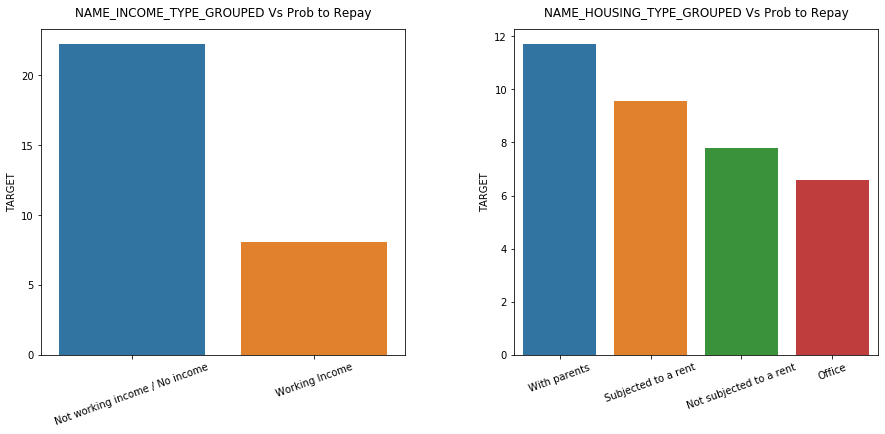

In [378]:
analizer.bins_impact(properties, ["NAME_INCOME_TYPE_GROUPED", "NAME_HOUSING_TYPE_GROUPED"], nrow = 1, ncol = 2, 
                     rot = 20, sort = True, size = (15, 6))

In [379]:
# Get dummies:

In [380]:
properties = properties.drop(columns = ["NAME_INCOME_TYPE","NAME_HOUSING_TYPE","TARGET"])
properties = pd.get_dummies(properties)
properties["TARGET"] = train["TARGET"]

#### 3) Study the whole:

There is correlation among variables but for the most it is due to dummy trap, so we drop one column for each  variable.

In [381]:
# Correlation:

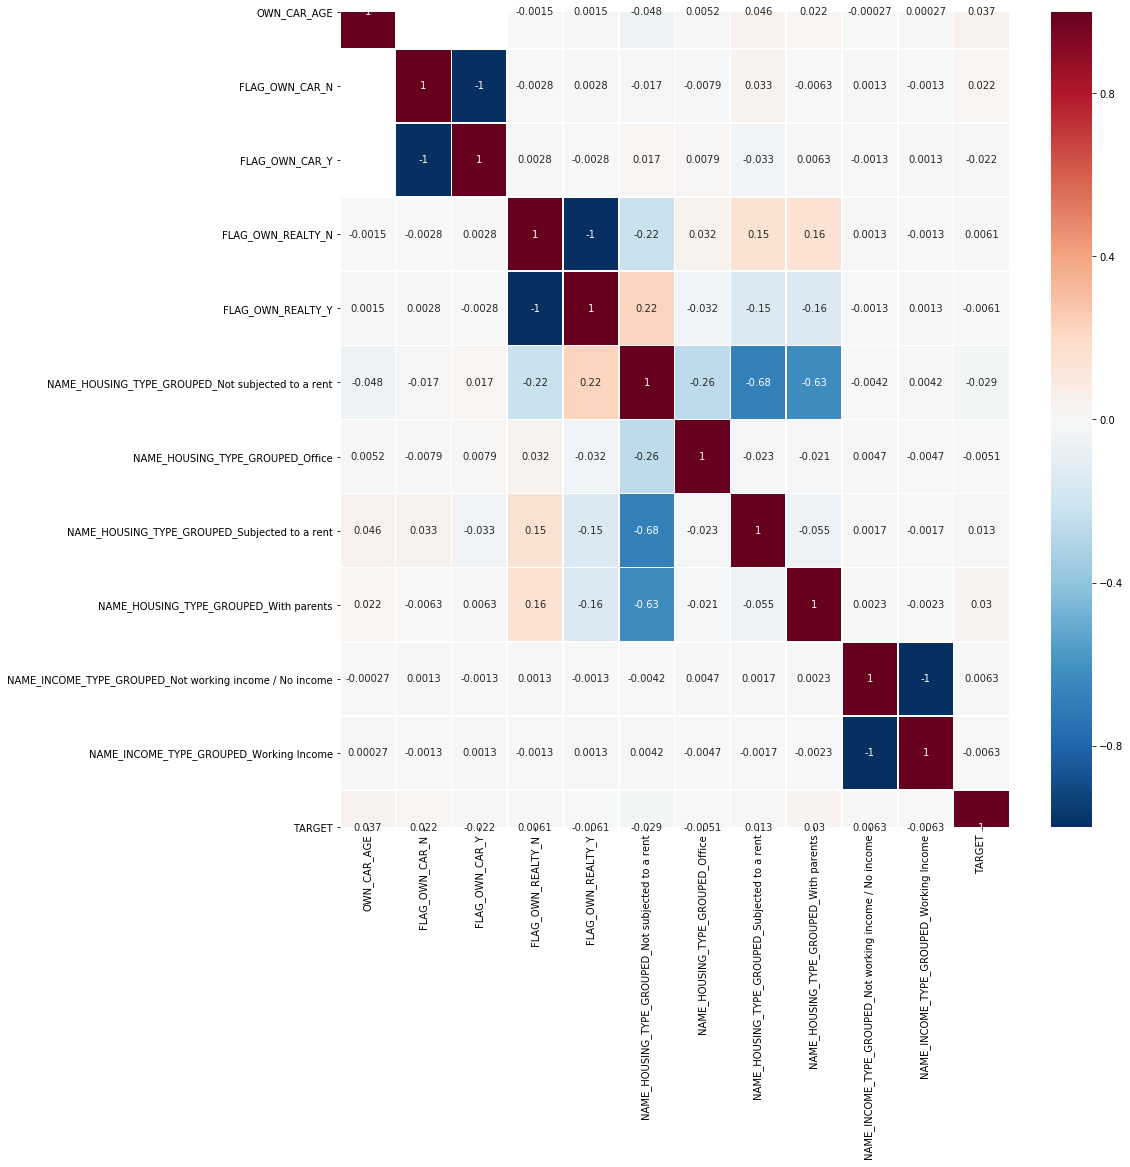

In [382]:
analizer.cor_plot(properties, an = True, size = (15, 15), name = "Properties")

In [383]:
# Drop:

In [384]:
properties = properties.drop(columns = ["FLAG_OWN_CAR_Y", "FLAG_OWN_REALTY_Y", 
                                        "NAME_HOUSING_TYPE_GROUPED_Not subjected to a rent", 
                                       "NAME_INCOME_TYPE_GROUPED_Working Income"])

#### 4) Fill NA:

In [385]:
'''car_mean = properties["OWN_CAR_AGE"].mean()
properties.loc[(properties["OWN_CAR_AGE"].isnull()) & (properties["FLAG_OWN_CAR_N"] == 0), "OWN_CAR_AGE"] = car_mean
properties.loc[properties["OWN_CAR_AGE"].isnull(), "OWN_CAR_AGE"] = -9999'''

'car_mean = properties["OWN_CAR_AGE"].mean()\nproperties.loc[(properties["OWN_CAR_AGE"].isnull()) & (properties["FLAG_OWN_CAR_N"] == 0), "OWN_CAR_AGE"] = car_mean\nproperties.loc[properties["OWN_CAR_AGE"].isnull(), "OWN_CAR_AGE"] = -9999'

#### 5) Add to final DF:

In [386]:
properties = properties.drop("TARGET", axis = 1)

In [387]:
final_train = pd.concat([final_train, properties], axis = 1)

In [388]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  FLAG_PHONE_No  \
0      0.139376               0                  0  ...              0   
1      0.535276               0                  0  ...              0   
2      0.729567               0                  1  ...              0   
3      0.535276               0                  0  ...              1   
4      0.535276               1                  0  ...              1   

   FLAG_WORK_PHONE_Yes  FLAG_EMAIL_Yes  OWN_CAR_AGE  FLAG_OWN_CAR_N  \
0                    0               0          NaN               1   
1                    0               0          NaN               1   
2                    1               0         26.0               0   
3                    0               0          NaN               1   
4                    0               0          NaN               1   

   FLAG_OWN_REALTY_N  NAME_HOUSING_TYPE_GROUPED_Office  \
0                  0                                 0   
1                  1                                 0   
2                  0                                 0   
3                  0                                 0   
4                  0                                 0   

   NAME_HOUSING_TYPE_GROUPED_Subjected to a rent  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   NAME_HOUSING_TYPE_GROUPED_With parents  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   NAME_INCOME_TYPE_GROUPED_Not working income / No income  
0                                                  0        
1                                                  0        
2                                                  0        
3                                                  0        
4                                                  0        

[5 rows x 35 columns]

### Other Info

In [389]:
otherInfo = train[['DAYS_ID_PUBLISH','DAYS_REGISTRATION','NAME_TYPE_SUITE']]

#### 1) Numerical Variables:

Who has for a longer time the ID (>10) is more reliable, same for people who live in the same place for a longer time (>25).

In [390]:
# transform in year:

In [391]:
otherInfo["YEARS_ID_PUBLISH"] = otherInfo["DAYS_ID_PUBLISH"].apply(lambda x: -x/365)
otherInfo["YEARS_REGISTRATION"] = otherInfo["DAYS_REGISTRATION"].apply(lambda x: -x/365)

In [392]:
# Outlayers:

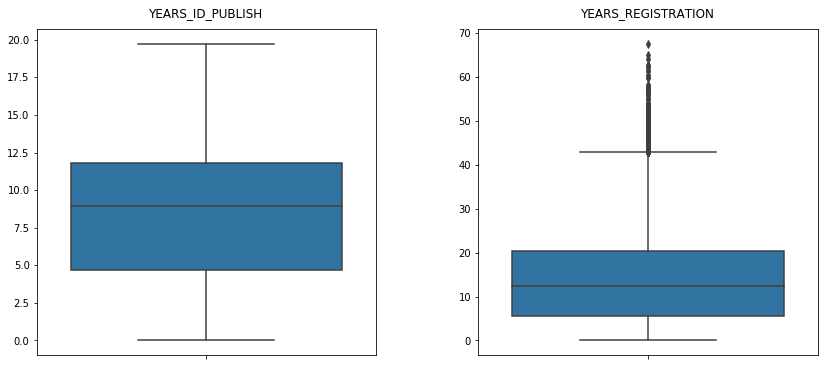

In [393]:
cols = ['YEARS_ID_PUBLISH','YEARS_REGISTRATION']
analizer.Box_Plots(otherInfo, cols, nrow = 1, ncol = 2, size = (14,6), name = "Info")

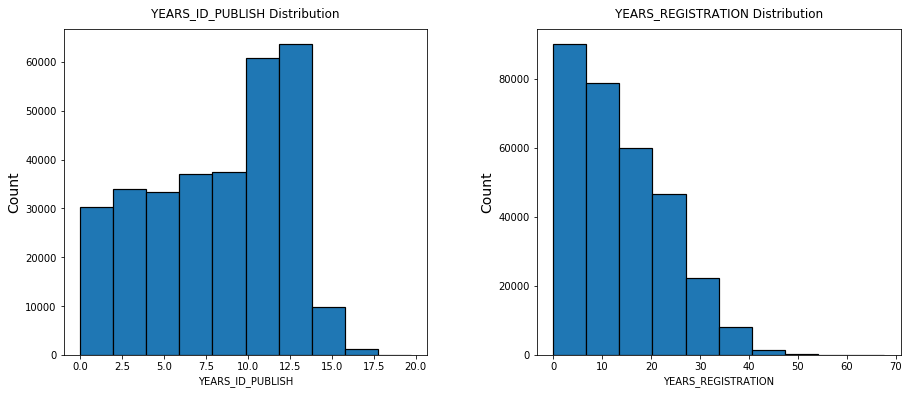

In [394]:
analizer.plot_distributions(otherInfo, cols, nrow = 1, ncol = 2)

In [395]:
# importance:

In [396]:
otherInfo["TARGET"] = train["TARGET"]

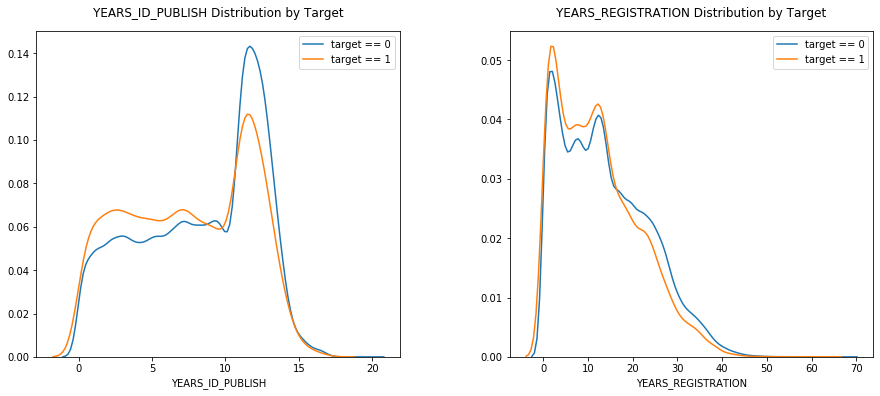

In [397]:
analizer.plot_distributions(otherInfo, cols, nrow = 1, ncol = 2, kind = "kdeplot", name = "Info")

#### 2) Categorical Variable:

Too many categories, let's try to group them: family, group, other

In [398]:
# Substitute Na with XNA:

In [399]:
otherInfo.loc[otherInfo["NAME_TYPE_SUITE"].isnull(), "NAME_TYPE_SUITE"] = "XNA"

In [400]:
# Distribution:

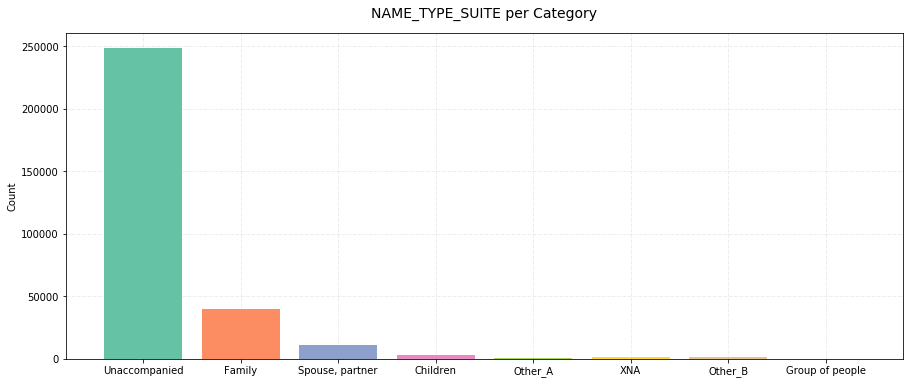

In [401]:
analizer.bar_plot(otherInfo, ['NAME_TYPE_SUITE'], rot = 45, size = (15,6), name = "Info")

In [402]:
# Importance:

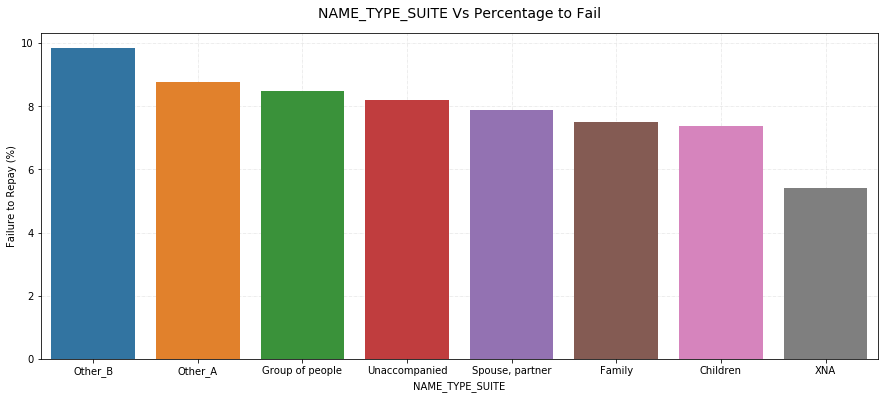

In [403]:
analizer.bins_impact(otherInfo, ['NAME_TYPE_SUITE'], nrow = 1, ncol = 1, sort = True, size = (15, 6))

In [404]:
# Group the variable:

In [405]:
otherInfo.insert(4, "NAME_TYPE_SUITE_GROUP", "")

otherInfo.loc[(otherInfo["NAME_TYPE_SUITE"] == "Other_A") | (otherInfo["NAME_TYPE_SUITE"] == "Other_B"),
             "NAME_TYPE_SUITE_GROUP"] = "Others"
otherInfo.loc[(otherInfo["NAME_TYPE_SUITE"] == "Children") | (otherInfo["NAME_TYPE_SUITE"] == "Family") |
              (otherInfo["NAME_TYPE_SUITE"] == "Spouse, partner"), "NAME_TYPE_SUITE_GROUP"] = "Family"
otherInfo.loc[(otherInfo["NAME_TYPE_SUITE"] == "Group of people"), "NAME_TYPE_SUITE_GROUP"] = "Group of people"
otherInfo.loc[(otherInfo["NAME_TYPE_SUITE"] == "Unaccompanied"), "NAME_TYPE_SUITE_GROUP"] = "Unaccompanied"

otherInfo.loc[(otherInfo["NAME_TYPE_SUITE"] == "XNA"), "NAME_TYPE_SUITE_GROUP"] = "XNA"

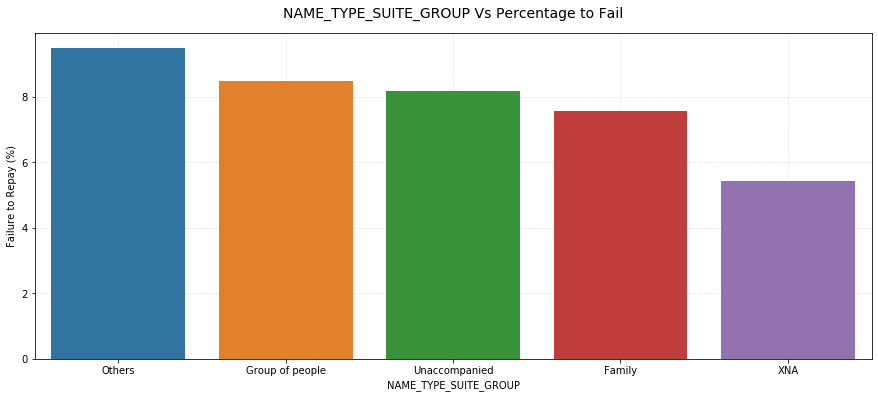

In [406]:
analizer.bins_impact(otherInfo, ['NAME_TYPE_SUITE_GROUP'], nrow = 1, ncol = 1, sort = True, size = (15, 6))

#### 3) All in one

The only important kind of correlation is due to dummy trap.

In [407]:
# Adjust DF:

In [408]:
otherInfo = otherInfo.drop(columns = ['DAYS_ID_PUBLISH','DAYS_REGISTRATION','NAME_TYPE_SUITE', "TARGET"])
otherInfo = pd.get_dummies(otherInfo)
otherInfo["TARGET"] = train["TARGET"]

In [409]:
# Correlation

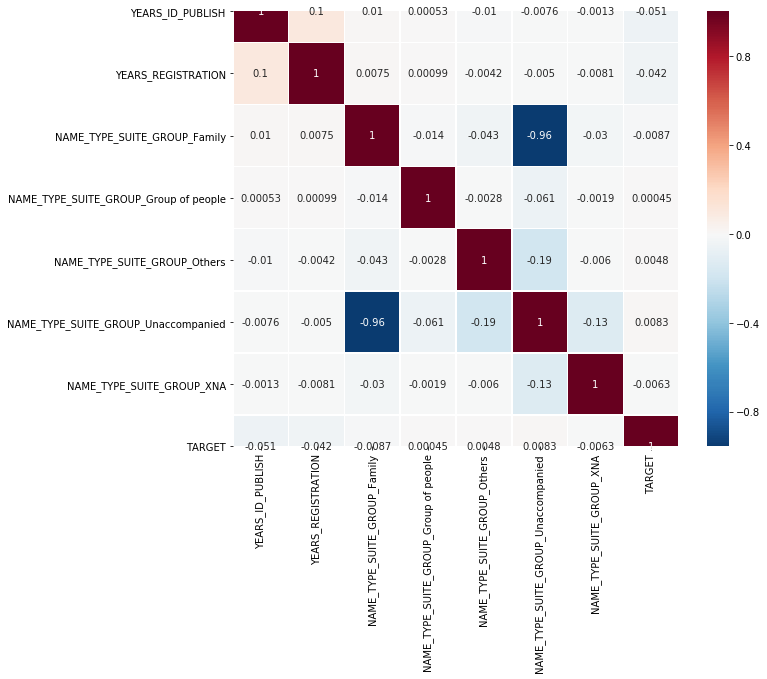

In [410]:
analizer.cor_plot(otherInfo, an = True, size = (10, 8), name = "Info")

In [411]:
# Fill NA:

In [412]:
proportions(otherInfo)

poms  pobs
YEARS_ID_PUBLISH                        0.0   1.0
YEARS_REGISTRATION                      0.0   1.0
NAME_TYPE_SUITE_GROUP_Family            0.0   1.0
NAME_TYPE_SUITE_GROUP_Group of people   0.0   1.0
NAME_TYPE_SUITE_GROUP_Others            0.0   1.0
NAME_TYPE_SUITE_GROUP_Unaccompanied     0.0   1.0
NAME_TYPE_SUITE_GROUP_XNA               0.0   1.0
TARGET                                  0.0   1.0

In [413]:
suite_mod = train["NAME_TYPE_SUITE"].mode()[0]
otherInfo.loc[otherInfo["NAME_TYPE_SUITE_GROUP_XNA"] == 1, "".join(["NAME_TYPE_SUITE_GROUP_", suite_mod])] = 1
otherInfo = otherInfo.drop("NAME_TYPE_SUITE_GROUP_XNA", axis = 1)
otherInfo = otherInfo.drop("NAME_TYPE_SUITE_GROUP_Unaccompanied", axis = 1)

#### 5) Add to the Final DF:

In [414]:
otherInfo = otherInfo.drop(columns = ["TARGET"])

In [415]:
final_train = pd.concat([final_train, otherInfo], axis = 1)

### Region Info

In [416]:
regionInfo = train[['LIVE_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',
                     'REG_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']]

#### 1) Numerical variables:

It seems there are outlayer, but after checking, there are many clients (around 9000) with that value, so maybe it is just a city with a huge density, like a capital. In general it seems that this variable dosen't have great impact on the DF, but a higher value (more than 0.03) drastically reduces the prob of default.

In [417]:
# Check NA:

In [418]:
proportions(regionInfo)

poms  pobs
LIVE_CITY_NOT_WORK_CITY       0.0   1.0
LIVE_REGION_NOT_WORK_REGION   0.0   1.0
REG_CITY_NOT_LIVE_CITY        0.0   1.0
REG_CITY_NOT_WORK_CITY        0.0   1.0
REGION_POPULATION_RELATIVE    0.0   1.0
REG_REGION_NOT_LIVE_REGION    0.0   1.0
REG_REGION_NOT_WORK_REGION    0.0   1.0
REGION_RATING_CLIENT          0.0   1.0
REGION_RATING_CLIENT_W_CITY   0.0   1.0

In [419]:
# Distribution:

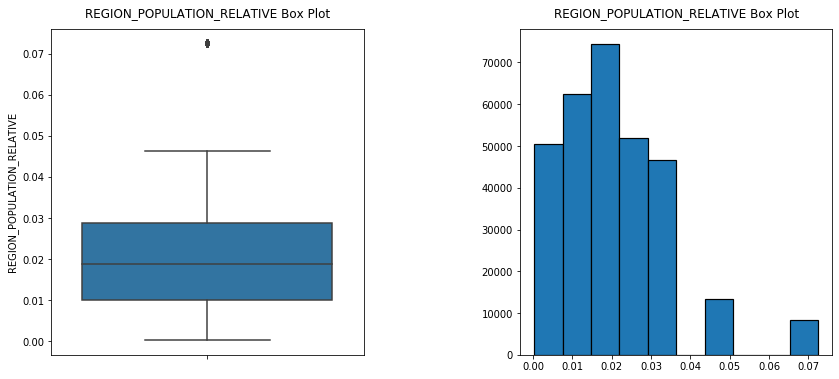

In [420]:
analizer.box_hist(regionInfo, "REGION_POPULATION_RELATIVE", name = "Region")

In [421]:
len(regionInfo.loc[regionInfo["REGION_POPULATION_RELATIVE"] >= 0.05])

8412

In [422]:
# Importance:

In [423]:
regionInfo["TARGET"] = train["TARGET"]

In [424]:
regionInfo["POP_REL_BINS"] = pd.cut(regionInfo["REGION_POPULATION_RELATIVE"], bins = [-1, 0.01, 0.02, 0.03, 0.05, np.inf],
                                   labels = ["[0, 0.01]", "(0.01, 0.02]", "(0.02, 0.03]", "(0.03, 0.05]", 
                                             "(0.05, 0.07]"])

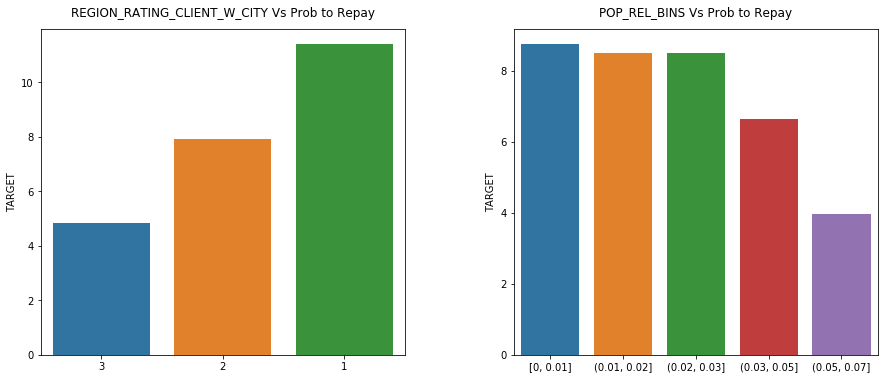

In [425]:
cols = ["REGION_RATING_CLIENT_W_CITY","POP_REL_BINS"]
analizer.bins_impact(regionInfo, cols, nrow = 1, ncol = 2, sort = True, size = (15, 6))

#### 2) Categorical Variables:

In [426]:
# Transform in Yes and No:

In [427]:
regionInfo.loc[regionInfo['LIVE_CITY_NOT_WORK_CITY'] == 1, 'LIVE_CITY_NOT_WORK_CITY'] = "Different"
regionInfo.loc[regionInfo['LIVE_CITY_NOT_WORK_CITY'] == 0, 'LIVE_CITY_NOT_WORK_CITY'] = "Same"

regionInfo.loc[regionInfo['LIVE_REGION_NOT_WORK_REGION'] == 1, 'LIVE_REGION_NOT_WORK_REGION'] = "Different"
regionInfo.loc[regionInfo['LIVE_REGION_NOT_WORK_REGION'] == 0, 'LIVE_REGION_NOT_WORK_REGION'] = "Same"

regionInfo.loc[regionInfo['REG_CITY_NOT_LIVE_CITY'] == 1, 'REG_CITY_NOT_LIVE_CITY'] = "Different"
regionInfo.loc[regionInfo['REG_CITY_NOT_LIVE_CITY'] == 0, 'REG_CITY_NOT_LIVE_CITY'] = "Same"

regionInfo.loc[regionInfo['REG_CITY_NOT_WORK_CITY'] == 1, 'REG_CITY_NOT_WORK_CITY'] = "Different"
regionInfo.loc[regionInfo['REG_CITY_NOT_WORK_CITY'] == 0, 'REG_CITY_NOT_WORK_CITY'] = "Same"

regionInfo.loc[regionInfo['REG_REGION_NOT_LIVE_REGION'] == 1, 'REG_REGION_NOT_LIVE_REGION'] = "Different"
regionInfo.loc[regionInfo['REG_REGION_NOT_LIVE_REGION'] == 0, 'REG_REGION_NOT_LIVE_REGION'] = "Same"

regionInfo.loc[regionInfo['REG_REGION_NOT_WORK_REGION'] == 1, 'REG_REGION_NOT_WORK_REGION'] = "Different"
regionInfo.loc[regionInfo['REG_REGION_NOT_WORK_REGION'] == 0, 'REG_REGION_NOT_WORK_REGION'] = "Same"

In [428]:
# Impact:

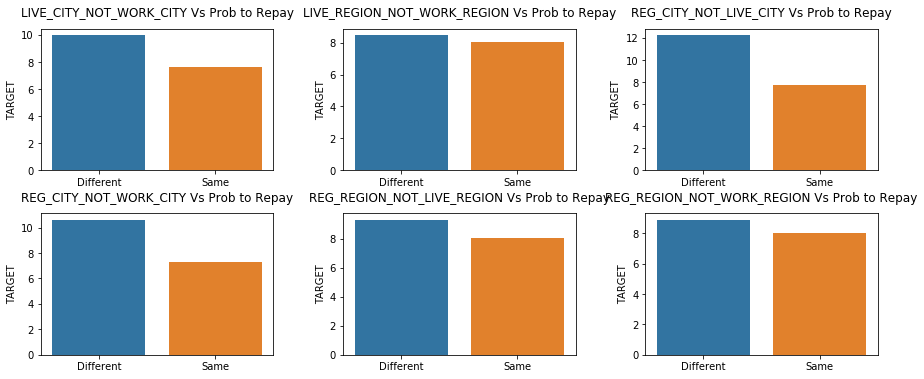

In [429]:
cols = ['LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION']
analizer.bins_impact(regionInfo, cols, nrow = 2, ncol = 3, size = (15, 6))

In [430]:
reg_dum = pd.get_dummies(regionInfo[['LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                                     'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION']])

#### 3) All together:

In [431]:
# Adjust DF:

In [432]:
regionInfo = regionInfo.drop(columns = ['LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION', "POP_REL_BINS", "TARGET"])

regionInfo = pd.concat([regionInfo, reg_dum, train["TARGET"]], axis = 1)

In [433]:
# Correlation:

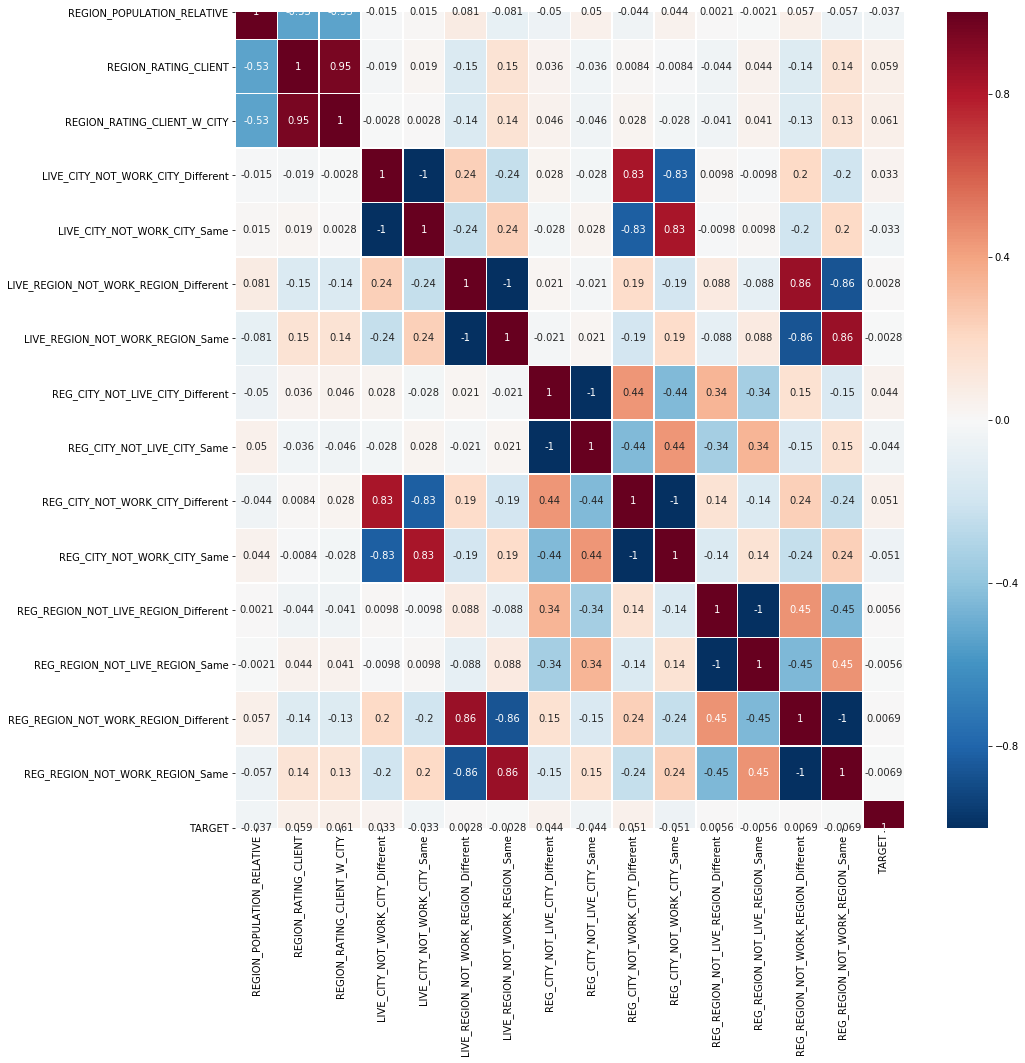

In [434]:
analizer.cor_plot(regionInfo, an = True, size = (15, 15), name = "Region")

In [435]:
# Deal with dummy trap:

In [436]:
regionInfo = regionInfo.drop(columns = ['REG_REGION_NOT_WORK_REGION_Same', 'REG_REGION_NOT_LIVE_REGION_Same', 
                                       'REG_CITY_NOT_WORK_CITY_Same', 'REG_CITY_NOT_LIVE_CITY_Same',
                                       'LIVE_REGION_NOT_WORK_REGION_Same', 'LIVE_CITY_NOT_WORK_CITY_Same'])

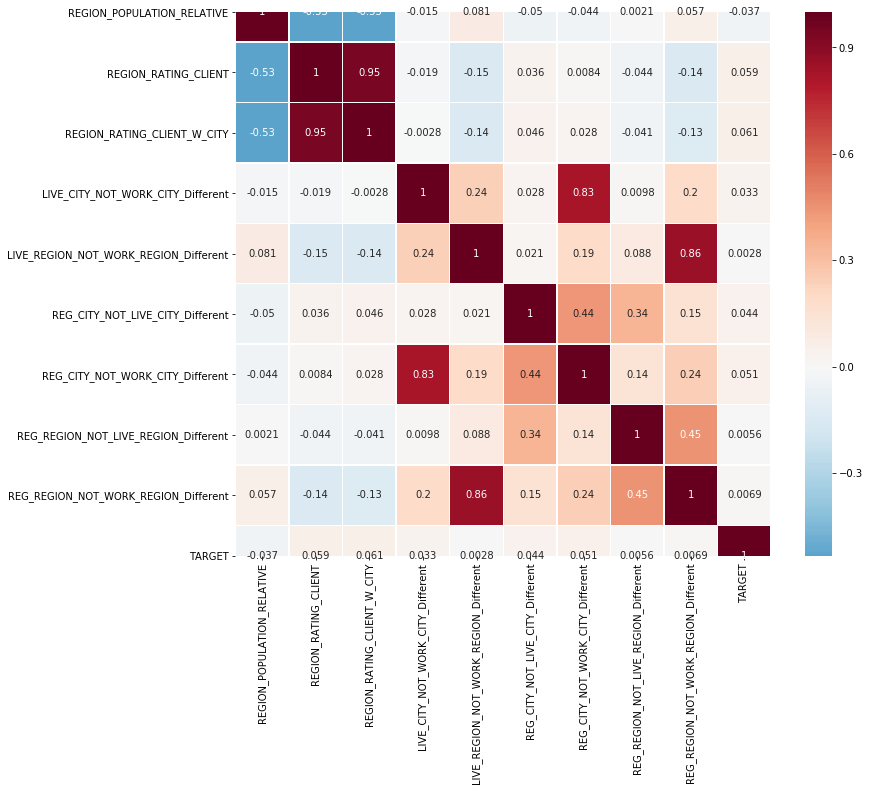

In [437]:
analizer.cor_plot(regionInfo, an = True, size = (12, 10), name = "Region")

In [438]:
regionInfo = regionInfo.drop(columns = ['REG_CITY_NOT_WORK_CITY_Different', 'REG_REGION_NOT_WORK_REGION_Different',
                                       'REGION_RATING_CLIENT'])

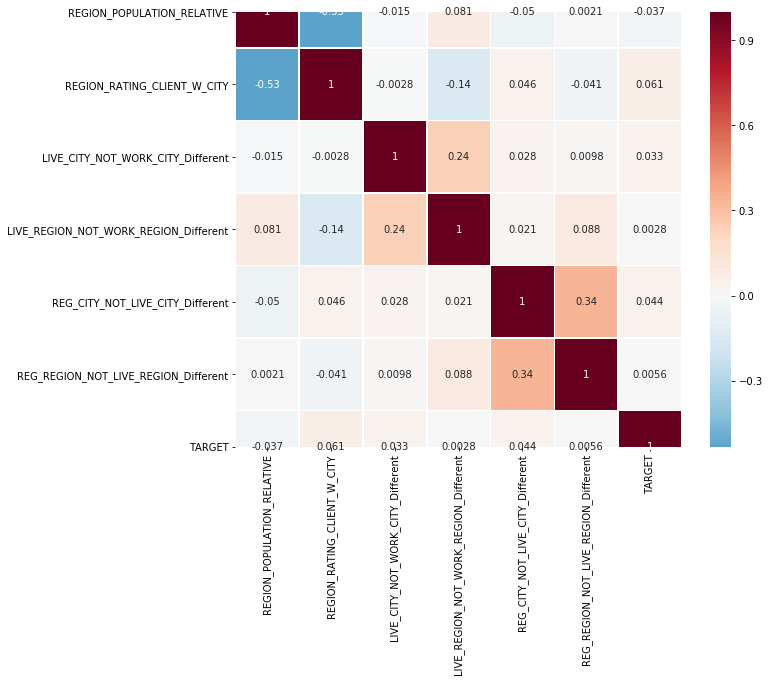

In [439]:
analizer.cor_plot(regionInfo, an = True, size = (10, 8), name = "Region")

In [440]:
# ANOVA Test:

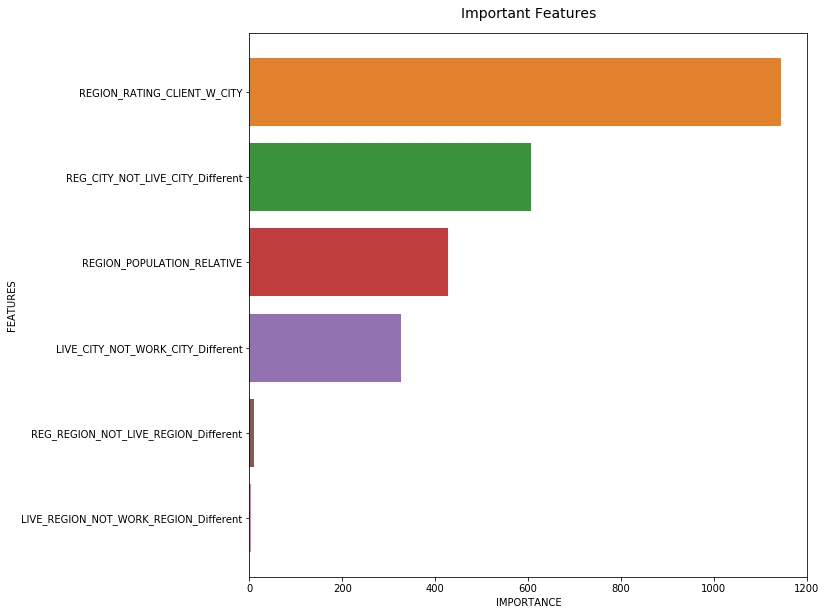

In [441]:
analizer.ANOVA_Importance(regionInfo, train, name = "Region")

In [442]:
regionInfo = regionInfo.drop(columns = ['REG_REGION_NOT_LIVE_REGION_Different', 'LIVE_REGION_NOT_WORK_REGION_Different',
                                       'REGION_POPULATION_RELATIVE'])

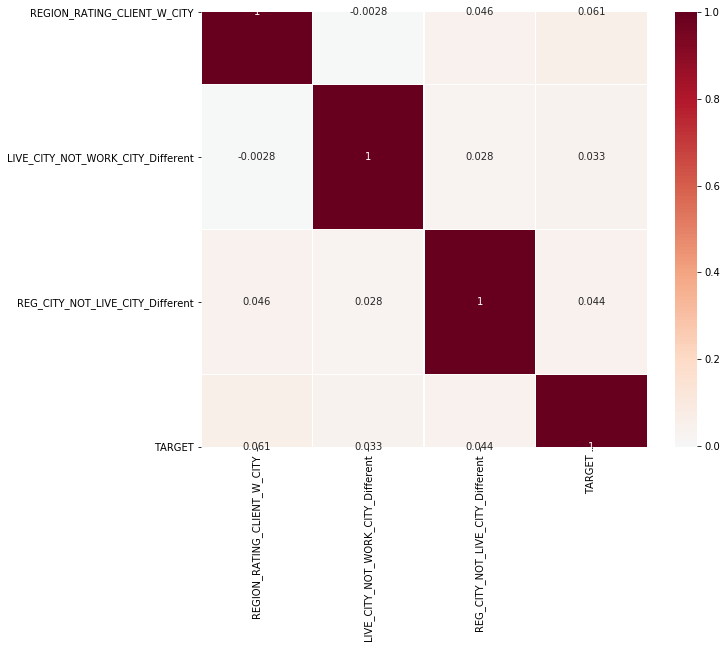

In [443]:
analizer.cor_plot(regionInfo, an = True, size = (10, 8), name = "Region")

#### 5) Final DF:

In [444]:
regionInfo = regionInfo.drop("TARGET", axis = 1)

In [445]:
final_train = pd.concat([final_train, regionInfo], axis = 1)

In [446]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  \
0      0.139376               0                  0  ...   
1      0.535276               0                  0  ...   
2      0.729567               0                  1  ...   
3      0.535276               0                  0  ...   
4      0.535276               1                  0  ...   

   NAME_HOUSING_TYPE_GROUPED_With parents  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   NAME_INCOME_TYPE_GROUPED_Not working income / No income  YEARS_ID_PUBLISH  \
0                                                  0                5.808219   
1                                                  0                0.797260   
2                                                  0                6.934247   
3                                                  0                6.676712   
4                                                  0                9.473973   

   YEARS_REGISTRATION  NAME_TYPE_SUITE_GROUP_Family  \
0            9.994521                             0   
1            3.249315                             1   
2           11.671233                             0   
3           26.939726                             0   
4           11.810959                             0   

   NAME_TYPE_SUITE_GROUP_Group of people  NAME_TYPE_SUITE_GROUP_Others  \
0                                      0                             0   
1                                      0                             0   
2                                      0                             0   
3                                      0                             0   
4                                      0                             0   

   REGION_RATING_CLIENT_W_CITY  LIVE_CITY_NOT_WORK_CITY_Different  \
0                            2                                  0   
1                            1                                  0   
2                            2                                  0   
3                            2                                  0   
4                            2                                  1   

   REG_CITY_NOT_LIVE_CITY_Different  
0                                 0  
1                                 0  
2                                 0  
3                                 0  
4                                 0  

[5 rows x 43 columns]

### Occupation:

In [447]:
occupation = train[['DAYS_EMPLOYED', 'OCCUPATION_TYPE','ORGANIZATION_TYPE']]

#### 1) Numerical variable:

There is for sure an outlayer, because it seems that this person worked for 1000 years and moreover the number is negative. After dropping that value, we can say that the distribution is skewned and there aren't anymore outlayers. We can normalize the function, by the logaritm.

From KDEPlot we can see that who has worked less than more or less 5 years has a far higher probability not to repay the loan.

In [448]:
# Transform in Years:

In [449]:
occupation["YEARS_EMPLOYED"] = occupation["DAYS_EMPLOYED"].apply(lambda x: -x/365)

In [450]:
occupation["YEARS_EMPLOYED"] = occupation["YEARS_EMPLOYED"].astype('float32')

In [451]:
# Study Distribution and outlayers:

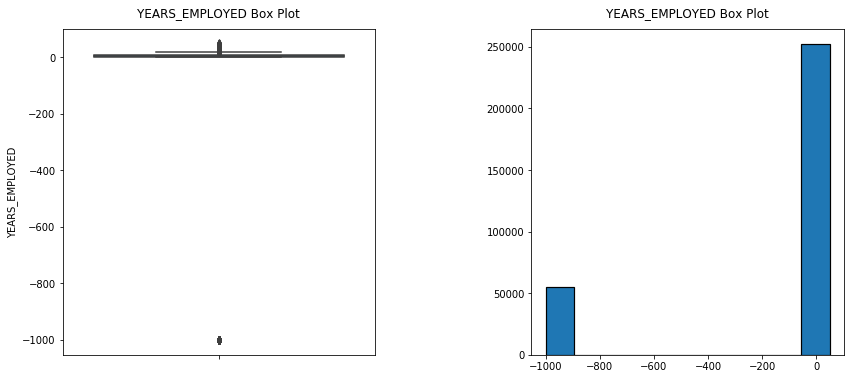

In [452]:
analizer.box_hist(occupation, "YEARS_EMPLOYED", name = "Occupation")

In [453]:
# Drop oulayer:

In [454]:
out = occupation["YEARS_EMPLOYED"].min()
occupation.loc[occupation["YEARS_EMPLOYED"] == out, "YEARS_EMPLOYED"] = np.nan

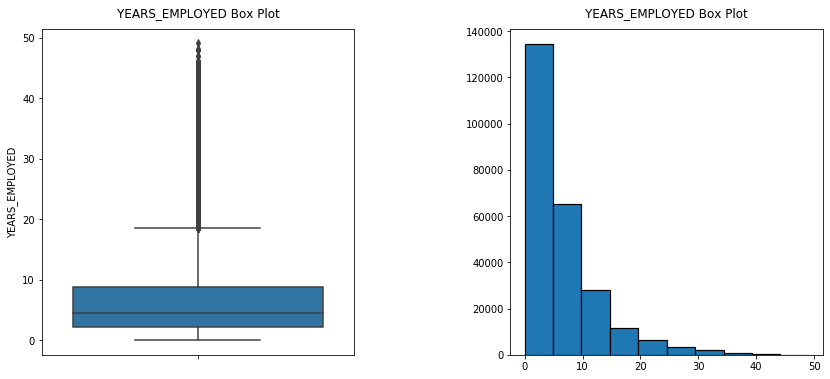

In [455]:
analizer.box_hist(occupation, "YEARS_EMPLOYED", name = "Occupation")

In [456]:
# Normalize the distribution

In [457]:
occupation["YEARS_EMPLOYED_LOG"] = np.log(occupation["YEARS_EMPLOYED"] + 1)

In [458]:
# Check importance:

In [459]:
occupation["TARGET"] = train["TARGET"]

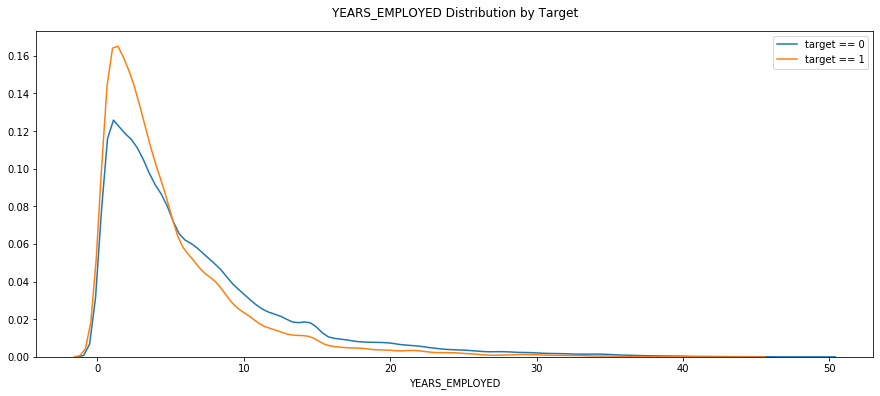

In [460]:
analizer.plot_distributions(occupation, ["YEARS_EMPLOYED"], kind = "kdeplot", name = "Occupation")

In [461]:
occupation["YEARS_EMP_BINS"] = pd.cut(occupation["YEARS_EMPLOYED"], bins = [-1, 5, 10, 15, 25, 35, np.inf],
                                     labels = ["[0, 5]", "(5, 10]", "(10, 15]",  "(15, 25]", "(25, 35]", ">35"])

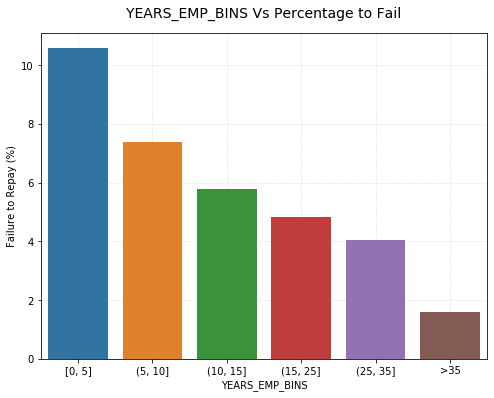

In [462]:
analizer.bins_impact(occupation, ["YEARS_EMP_BINS"])

#### 2) Categorical variables:

This variables have a lot of categories, we should group them. For the first one (OCCUPATION_TYPE) it is hard to think about any kind of group, because it has already done, for the second group the job is easier.

It is hard to deal with these variables, because all their categories are important.

Also imputing NA is hard, because they are a lot and the mode is also the category with the higher probability to default.

In [463]:
# Substitute NA with XNA as string:

In [464]:
occupation.loc[occupation["OCCUPATION_TYPE"].isnull(), 'OCCUPATION_TYPE'] = "XNA"
occupation.loc[occupation['ORGANIZATION_TYPE'].isnull(), 'ORGANIZATION_TYPE'] = "XNA"

In [465]:
# Distribution:

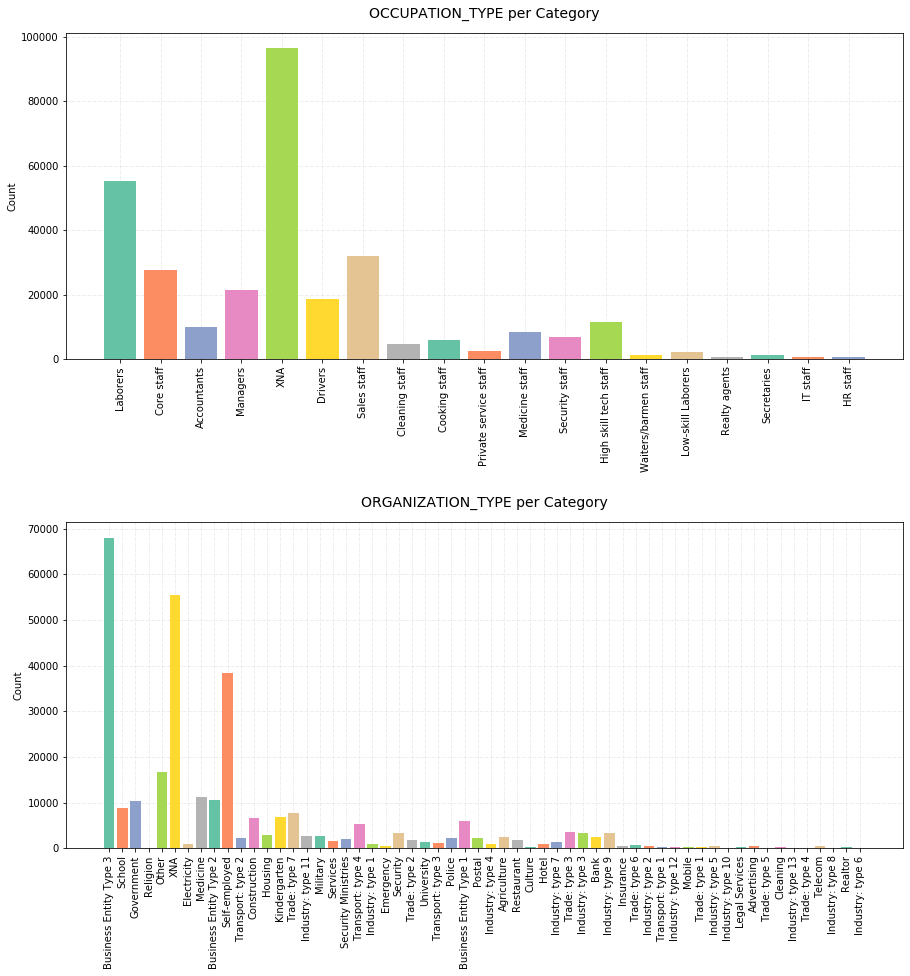

In [466]:
cols = ['OCCUPATION_TYPE','ORGANIZATION_TYPE']
analizer.bar_plot(occupation, cols, nrow = 2, ncol = 1, rot = 90,size = (15, 15))

In [467]:
# Check the impact:

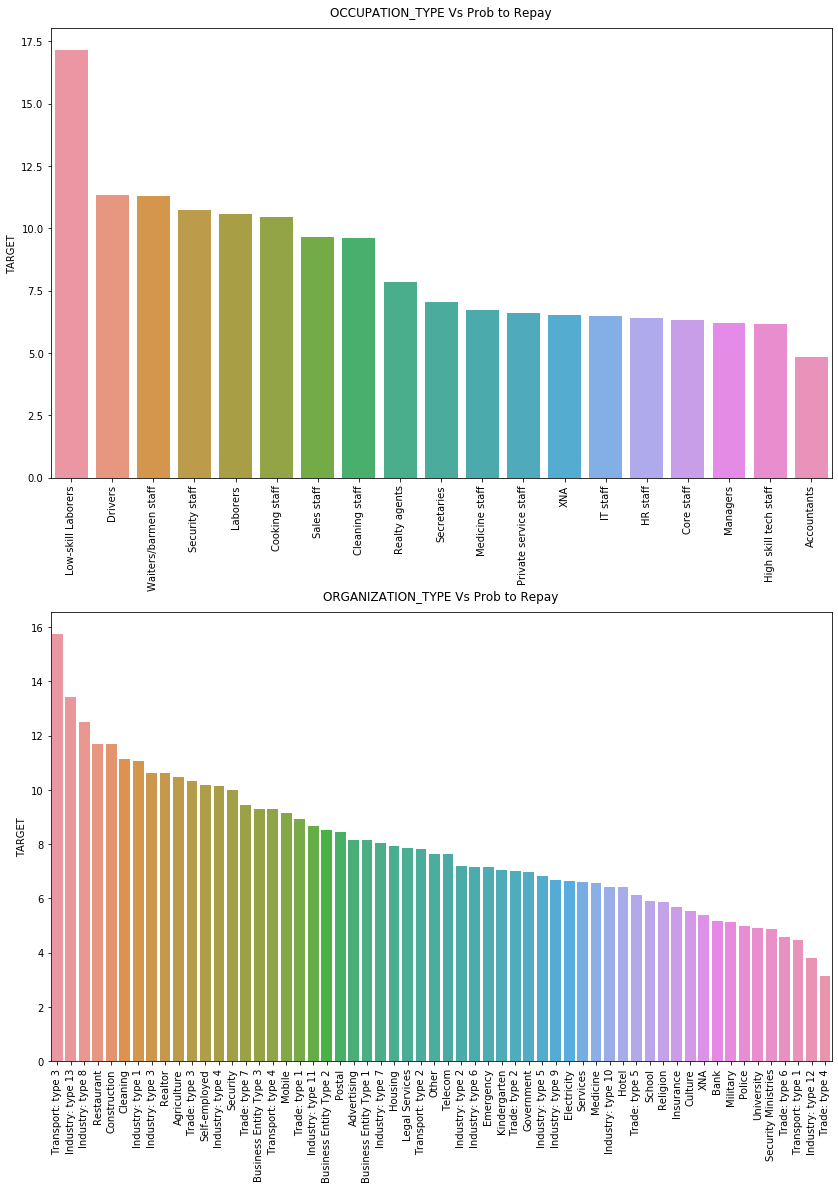

In [468]:
analizer.bins_impact(occupation, cols, nrow = 2, ncol = 1, rot = 90, sort = True, size = (14,19))

#### 4) Check Importance:

In [469]:
# Adjust DF

In [470]:
occ_cat = occupation[["OCCUPATION_TYPE", "ORGANIZATION_TYPE"]]
occ_cat = pd.get_dummies(occ_cat)

In [471]:
# Keep only the most important and group the others:

In [472]:
occupation.head()

DAYS_EMPLOYED OCCUPATION_TYPE       ORGANIZATION_TYPE  YEARS_EMPLOYED  \
0           -637        Laborers  Business Entity Type 3        1.745206   
1          -1188      Core staff                  School        3.254795   
2           -225        Laborers              Government        0.616438   
3          -3039        Laborers  Business Entity Type 3        8.326028   
4          -3038      Core staff                Religion        8.323288   

   YEARS_EMPLOYED_LOG  TARGET YEARS_EMP_BINS  
0            1.009856       1         [0, 5]  
1            1.448046       0         [0, 5]  
2            0.480225       0         [0, 5]  
3            2.232809       0        (5, 10]  
4            2.232515       0        (5, 10]

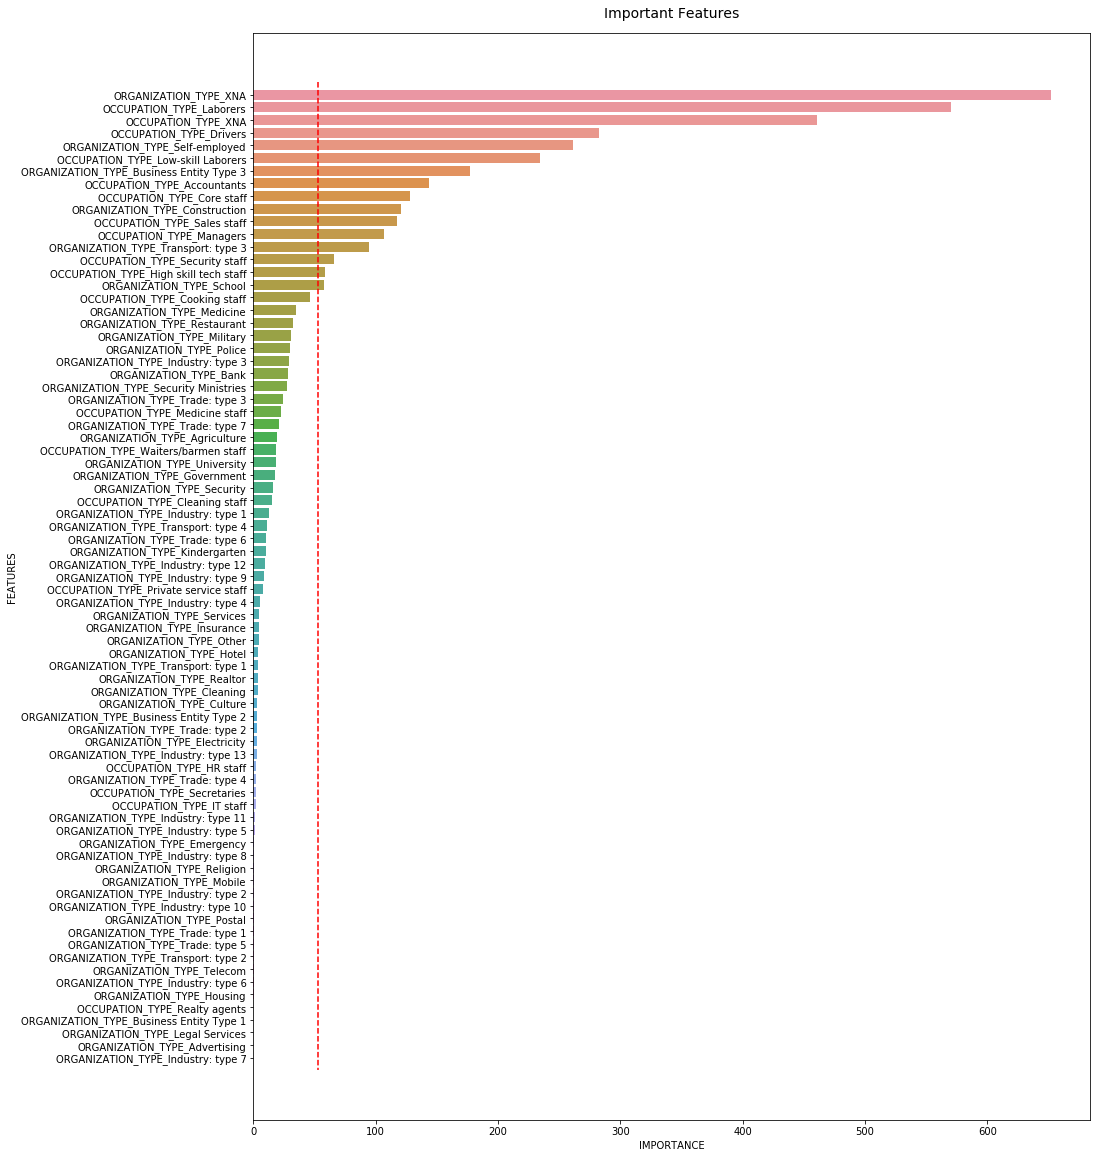

In [473]:
analizer.ANOVA_Importance(occ_cat, train, size = (15, 20), name = "Occupation")

In [474]:
# Add columns

occupation.insert(2,"OCCUPATION_TYPE_GROUP", "")
occupation.insert(4, "ORGANIZATION_TYPE_GROUP", "")

# Fill NA

org_type_mode = occupation["ORGANIZATION_TYPE"].mode()[0]
occ_type_mode = occupation["OCCUPATION_TYPE"].mode()[0]

occupation.loc[occupation["ORGANIZATION_TYPE"] == "XNA","ORGANIZATION_TYPE"] = org_type_mode
occupation.loc[occupation["OCCUPATION_TYPE"] == "XNA", "OCCUPATION_TYPE"] = occ_type_mode

# ORGANIZATION TYPE:

occupation.loc[(occupation["ORGANIZATION_TYPE"] == "Business Entity Type 3") , "ORGANIZATION_TYPE_GROUP"] = "Business Entity Type 3"
occupation.loc[(occupation["ORGANIZATION_TYPE"] == "Construction") , "ORGANIZATION_TYPE_GROUP"] = "Construction"
occupation.loc[(occupation["ORGANIZATION_TYPE"] == "Transport type 3") , "ORGANIZATION_TYPE_GROUP"] = "Construction"
occupation.loc[(occupation["ORGANIZATION_TYPE"] == "School") , "ORGANIZATION_TYPE_GROUP"] = "School"

occupation.loc[(occupation["ORGANIZATION_TYPE"] != "Business Entity Type 3") & (occupation["ORGANIZATION_TYPE"] != "Construction") &
              (occupation["ORGANIZATION_TYPE"] != "Transport type 3") & (occupation["ORGANIZATION_TYPE"] != "School"),
              "ORGANIZATION_TYPE_GROUP"] = "Other"

# OCCUPATION TYPE:

occupation.loc[(occupation["OCCUPATION_TYPE"] == "Laborers") , "OCCUPATION_TYPE_GROUP"] = "Laborers"
occupation.loc[(occupation["OCCUPATION_TYPE"] == "Drivers") , "OCCUPATION_TYPE_GROUP"] = "Drivers"
occupation.loc[(occupation["OCCUPATION_TYPE"] == "Low-skill Laborers") , "OCCUPATION_TYPE_GROUP"] = "Low-skill Laborers"
occupation.loc[(occupation["OCCUPATION_TYPE"] == "Accountants") , "OCCUPATION_TYPE_GROUP"] = "Accountants"
occupation.loc[(occupation["OCCUPATION_TYPE"] == "Core staff") , "OCCUPATION_TYPE_GROUP"] = "Core staff"

occupation.loc[(occupation["OCCUPATION_TYPE"] != "Laborers") & (occupation["OCCUPATION_TYPE"] != "Drivers") &
               (occupation["OCCUPATION_TYPE"] != "Low-skill Laborers") & (occupation["OCCUPATION_TYPE"] != "Accountants") &
               (occupation["OCCUPATION_TYPE"] != "Core staff"), "OCCUPATION_TYPE_GROUP"] = "Others"




In [475]:
occupation = occupation[["YEARS_EMPLOYED_LOG", "OCCUPATION_TYPE_GROUP", "ORGANIZATION_TYPE_GROUP"]]

In [476]:
occupation = pd.get_dummies(occupation)

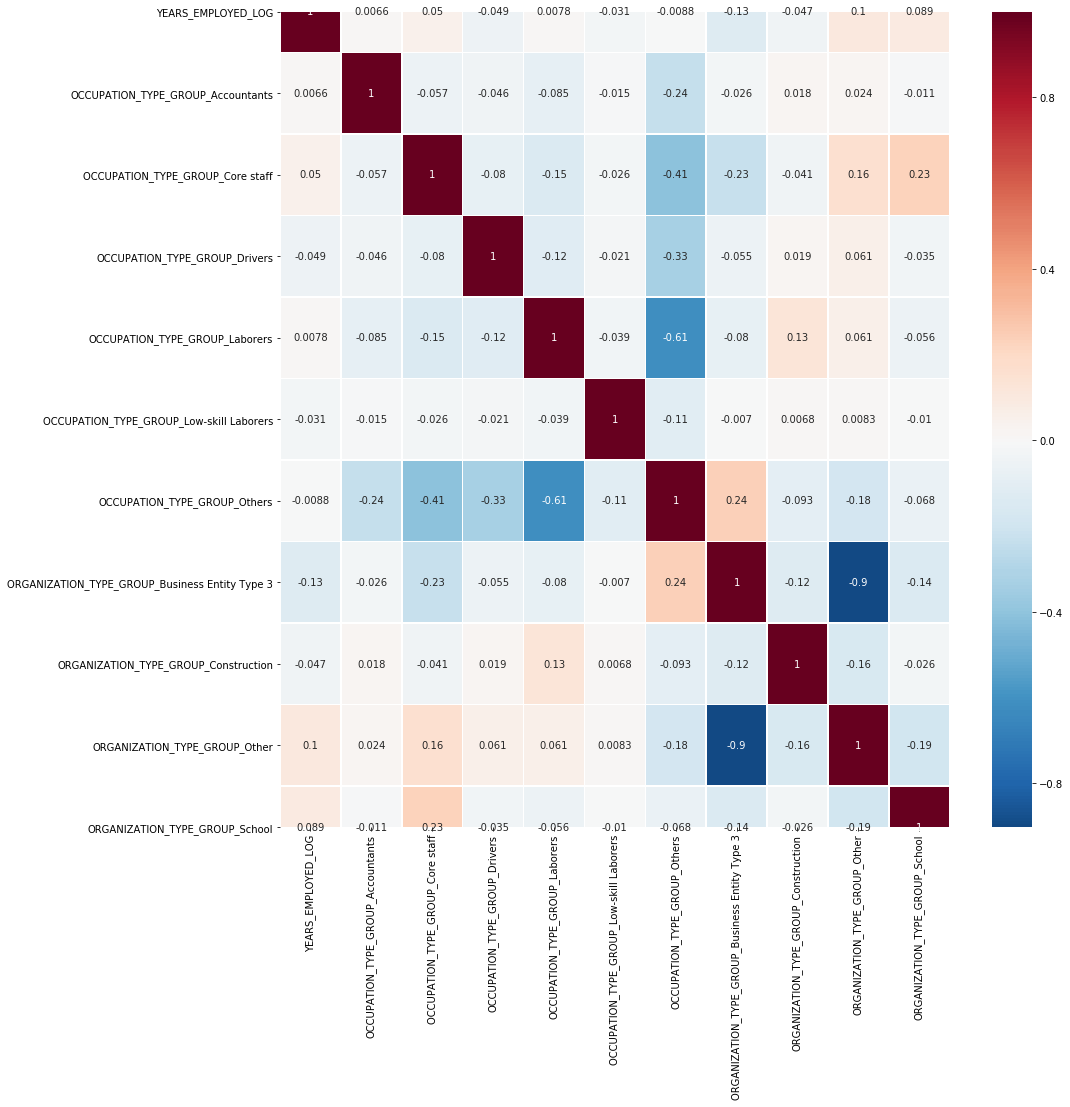

In [477]:
analizer.cor_plot(occupation, an = True, size = (15, 15), name = "Occupation")

In [478]:
occupation = occupation.drop(columns = ['ORGANIZATION_TYPE_GROUP_Other', "OCCUPATION_TYPE_GROUP_Others"])

#### 5) Fill NA:

In [479]:
proportions(occupation[["YEARS_EMPLOYED_LOG"]])

poms      pobs
YEARS_EMPLOYED_LOG  0.180072  0.819928

In [480]:
'''tools.imputer(occupation, "YEARS_EMPLOYED_LOG", method = "mean")'''

'tools.imputer(occupation, "YEARS_EMPLOYED_LOG", method = "mean")'

#### 6) Add to final DF:

In [481]:
final_train = pd.concat([final_train, occupation], axis = 1)

In [482]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  \
0      0.139376               0                  0  ...   
1      0.535276               0                  0  ...   
2      0.729567               0                  1  ...   
3      0.535276               0                  0  ...   
4      0.535276               1                  0  ...   

   REG_CITY_NOT_LIVE_CITY_Different  YEARS_EMPLOYED_LOG  \
0                                 0            1.009856   
1                                 0            1.448046   
2                                 0            0.480225   
3                                 0            2.232809   
4                                 0            2.232515   

   OCCUPATION_TYPE_GROUP_Accountants  OCCUPATION_TYPE_GROUP_Core staff  \
0                                  0                                 0   
1                                  0                                 1   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 1   

   OCCUPATION_TYPE_GROUP_Drivers  OCCUPATION_TYPE_GROUP_Laborers  \
0                              0                               1   
1                              0                               0   
2                              0                               1   
3                              0                               1   
4                              0                               0   

   OCCUPATION_TYPE_GROUP_Low-skill Laborers  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   ORGANIZATION_TYPE_GROUP_Business Entity Type 3  \
0                                               1   
1                                               0   
2                                               0   
3                                               1   
4                                               0   

   ORGANIZATION_TYPE_GROUP_Construction  ORGANIZATION_TYPE_GROUP_School  
0                                     0                               0  
1                                     0                               1  
2                                     0                               0  
3                                     0                               0  
4                                     0                               0  

[5 rows x 52 columns]

### Time and Date

In [483]:
time = train[['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START', 'TARGET']]

In [484]:
# Check importance:

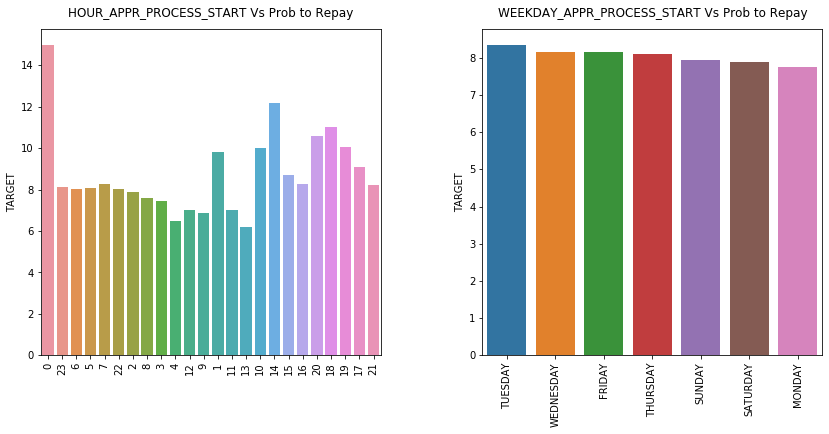

In [485]:
cols = ['HOUR_APPR_PROCESS_START', 'WEEKDAY_APPR_PROCESS_START']
analizer.bins_impact(time, cols, nrow = 1, ncol = 2, rot = 90, sort = True, size = (14,6))

In [486]:
time["HOUR_APPR_BINS"] = pd.cut(time['HOUR_APPR_PROCESS_START'], bins = [-1, 8, 12, 15, 18, 20, 23],
                               labels = ["Night", "Morning", "Lunch time", "Afternoon", "Evening", "Early Night"])

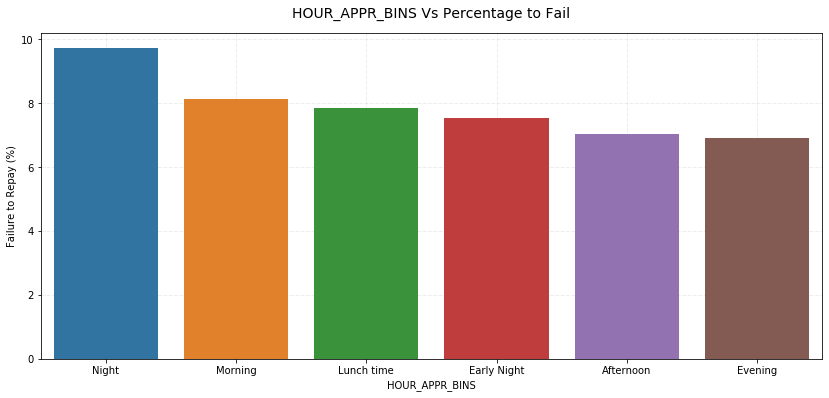

In [487]:
analizer.bins_impact(time, ["HOUR_APPR_BINS"], sort = True, size = (14,6))

In [488]:
# Check NA:

In [489]:
proportions(time)

poms  pobs
HOUR_APPR_PROCESS_START      0.0   1.0
WEEKDAY_APPR_PROCESS_START   0.0   1.0
TARGET                       0.0   1.0
HOUR_APPR_BINS               0.0   1.0

In [490]:
# Add to final DF

In [491]:
final_train = pd.concat([final_train, time[['HOUR_APPR_PROCESS_START']]], axis = 1)

In [492]:
final_train.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100002          0.0149                       0.9722               1   
1      100003          0.0714                       0.9851               1   
2      100004             NaN                          NaN               0   
3      100006             NaN                          NaN               0   
4      100007             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.139376   
1                        0                       1           NaN   
2                        0                       0      0.729567   
3                        0                       0           NaN   
4                        0                       0           NaN   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  YEARS_EMPLOYED_LOG  \
0      0.139376               0                  0  ...            1.009856   
1      0.535276               0                  0  ...            1.448046   
2      0.729567               0                  1  ...            0.480225   
3      0.535276               0                  0  ...            2.232809   
4      0.535276               1                  0  ...            2.232515   

   OCCUPATION_TYPE_GROUP_Accountants  OCCUPATION_TYPE_GROUP_Core staff  \
0                                  0                                 0   
1                                  0                                 1   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 1   

   OCCUPATION_TYPE_GROUP_Drivers  OCCUPATION_TYPE_GROUP_Laborers  \
0                              0                               1   
1                              0                               0   
2                              0                               1   
3                              0                               1   
4                              0                               0   

   OCCUPATION_TYPE_GROUP_Low-skill Laborers  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   ORGANIZATION_TYPE_GROUP_Business Entity Type 3  \
0                                               1   
1                                               0   
2                                               0   
3                                               1   
4                                               0   

   ORGANIZATION_TYPE_GROUP_Construction  ORGANIZATION_TYPE_GROUP_School  \
0                                     0                               0   
1                                     0                               1   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   HOUR_APPR_PROCESS_START  
0                       10  
1                       11  
2                        9  
3                       17  
4                       11  

[5 rows x 53 columns]

# Test DF:

In [493]:
test = pd.read_csv(P_TEST)
test.head()

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

In [494]:
generator = generate_test(test)
final_test = generator.Test_Output()

In [495]:
verifica = list(zip(final_train.columns, final_test.columns))
for tpl in verifica:
    print(tpl)

('SK_ID_CURR', 'SK_ID_CURR')
('TOTALAREA_MODE', 'TOTALAREA_MODE')
('YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_AVG')
('HOUSE_INFO_YES', 'HOUSE_INFO_YES')
('EMERGENCYSTATE_MODE_Yes', 'EMERGENCYSTATE_MODE_Yes')
('EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_No')
('EXT_SOURCE_2', 'EXT_SOURCE_2')
('EXT_SOURCE_3', 'EXT_SOURCE_3')
('FLAG_ANY_BUT_3', 'FLAG_ANY_BUT_3')
('FLAG_NO_DOCUMENTS', 'FLAG_NO_DOCUMENTS')
('SOCIAL_DEFAUL_RATIO_60', 'SOCIAL_DEFAUL_RATIO_60')
('TOT_ENQUIRES_YEARLY', 'TOT_ENQUIRES_YEARLY')
('CONTRACT_TYPE_Cash loans', 'CONTRACT_TYPE_Cash loans')
('DURATION', 'DURATION')
('AMT_ANNUITY_INCOMES_RATIO', 'AMT_ANNUITY_INCOMES_RATIO')
('YEARS_BIRTH', 'YEARS_BIRTH')
('CODE_GENDER_M', 'CODE_GENDER_M')
('NAME_EDUCATION_TYPE_Secondary or Less', 'NAME_EDUCATION_TYPE_Secondary or Less')
('NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Civil marriage')
('NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Separated')
('NAME_FAMILY_STATUS_Single / not married', 'NAME_

In [496]:
pd.set_option('display.max_rows', None)
proportions(final_test)

poms      pobs
SK_ID_CURR                                          0.000000  1.000000
TOTALAREA_MODE                                      0.464139  0.535861
YEARS_BEGINEXPLUATATION_AVG                         0.468899  0.531101
HOUSE_INFO_YES                                      0.000000  1.000000
EMERGENCYSTATE_MODE_Yes                             0.000000  1.000000
EMERGENCYSTATE_MODE_No                              0.000000  1.000000
EXT_SOURCE_2                                        0.000164  0.999836
EXT_SOURCE_3                                        0.177827  0.822173
FLAG_ANY_BUT_3                                      0.000000  1.000000
FLAG_NO_DOCUMENTS                                   0.000000  1.000000
SOCIAL_DEFAUL_RATIO_60                              0.536866  0.463134
TOT_ENQUIRES_YEARLY                                 0.124097  0.875903
CONTRACT_TYPE_Cash loans                            0.000000  1.000000
DURATION                                            0.000492  0.999508
AMT_ANNUITY_INCOMES_RATIO                           0.000492  0.999508
YEARS_BIRTH                                         0.000000  1.000000
CODE_GENDER_M                                       0.000000  1.000000
NAME_EDUCATION_TYPE_Secondary or Less               0.000000  1.000000
NAME_FAMILY_STATUS_Civil marriage                   0.000000  1.000000
NAME_FAMILY_STATUS_Separated                        0.000000  1.000000
NAME_FAMILY_STATUS_Single / not married             0.000000  1.000000
NAME_FAMILY_STATUS_Widow                            0.000000  1.000000
HAS_CHILDREN_Yes                                    0.000000  1.000000
YEARS_LAST_PHONE_CHANGE                             0.000000  1.000000
FLAG_EMP_PHONE_Yes                                  0.000000  1.000000
FLAG_PHONE_No                                       0.000000  1.000000
FLAG_WORK_PHONE_Yes                                 0.000000  1.000000
FLAG_EMAIL_Yes                                      0.000000  1.000000
OWN_CAR_AGE                                         0.662892  0.337108
FLAG_OWN_CAR_N                                      0.000000  1.000000
FLAG_OWN_REALTY_N                                   0.000000  1.000000
NAME_HOUSING_TYPE_GROUPED_Office                    0.000000  1.000000
NAME_HOUSING_TYPE_GROUPED_Subjected to a rent       0.000000  1.000000
NAME_HOUSING_TYPE_GROUPED_With parents              0.000000  1.000000
NAME_INCOME_TYPE_GROUPED_Not working income / N...  0.000000  1.000000
YEARS_ID_PUBLISH                                    0.000000  1.000000
YEARS_REGISTRATION                                  0.000000  1.000000
NAME_TYPE_SUITE_GROUP_Family                        0.000000  1.000000
NAME_TYPE_SUITE_GROUP_Group of people               0.000000  1.000000
NAME_TYPE_SUITE_GROUP_Others                        0.000000  1.000000
REGION_RATING_CLIENT_W_CITY                         0.000000  1.000000
LIVE_CITY_NOT_WORK_CITY_Different                   0.000000  1.000000
REG_CITY_NOT_LIVE_CITY_Different                    0.000000  1.000000
YEARS_EMPLOYED_LOG                                  0.190259  0.809741
OCCUPATION_TYPE_GROUP_Accountants                   0.000000  1.000000
OCCUPATION_TYPE_GROUP_Core staff                    0.000000  1.000000
OCCUPATION_TYPE_GROUP_Drivers                       0.000000  1.000000
OCCUPATION_TYPE_GROUP_Laborers                      0.000000  1.000000
OCCUPATION_TYPE_GROUP_Low-skill Laborers            0.000000  1.000000
ORGANIZATION_TYPE_GROUP_Business Entity Type 3      0.000000  1.000000
ORGANIZATION_TYPE_GROUP_Construction                0.000000  1.000000
ORGANIZATION_TYPE_GROUP_School                      0.000000  1.000000
HOUR_APPR_PROCESS_START                             0.000000  1.000000

In [497]:
pd.set_option('display.max_rows', 10)

In [498]:
final_test.head()

SK_ID_CURR  TOTALAREA_MODE  YEARS_BEGINEXPLUATATION_AVG  HOUSE_INFO_YES  \
0      100001          0.0392                       0.9732               0   
1      100005             NaN                          NaN               0   
2      100013             NaN                          NaN               0   
3      100028          0.3700                       0.9970               1   
4      100038             NaN                          NaN               0   

   EMERGENCYSTATE_MODE_Yes  EMERGENCYSTATE_MODE_No  EXT_SOURCE_2  \
0                        0                       1      0.789654   
1                        0                       0      0.291656   
2                        0                       0      0.699787   
3                        0                       1      0.509677   
4                        0                       0      0.425687   

   EXT_SOURCE_3  FLAG_ANY_BUT_3  FLAG_NO_DOCUMENTS  ...  YEARS_EMPLOYED_LOG  \
0      0.159520               0                  0  ...            1.998885   
1      0.432962               0                  0  ...            2.583532   
2      0.610991               1                  0  ...            2.581254   
3      0.612704               0                  0  ...            1.810308   
4           NaN               0                  0  ...            1.946301   

   OCCUPATION_TYPE_GROUP_Accountants  OCCUPATION_TYPE_GROUP_Core staff  \
0                                  0                                 0   
1                                  0                                 0   
2                                  0                                 0   
3                                  0                                 0   
4                                  0                                 0   

   OCCUPATION_TYPE_GROUP_Drivers  OCCUPATION_TYPE_GROUP_Laborers  \
0                              0                               0   
1                              0                               0   
2                              1                               0   
3                              0                               0   
4                              0                               0   

   OCCUPATION_TYPE_GROUP_Low-skill Laborers  \
0                                         0   
1                                         1   
2                                         0   
3                                         0   
4                                         0   

   ORGANIZATION_TYPE_GROUP_Business Entity Type 3  \
0                                               0   
1                                               0   
2                                               0   
3                                               1   
4                                               1   

   ORGANIZATION_TYPE_GROUP_Construction  ORGANIZATION_TYPE_GROUP_School  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   HOUR_APPR_PROCESS_START  
0                       18  
1                        9  
2                       14  
3                       11  
4                        5  

[5 rows x 53 columns]

## Target column in train:

In [499]:
final_train["TARGET"] = train["TARGET"]

# BUREAU

For this dataframe, for previous applications and for instalments payments for each SK_ID_CURR corresponds different rows, that can be different loans or just monthly data(as for instalment payments), so we group these values and take for each column for each SK_ID_CURR the min, max, std and mean or median. At the end of each section we create a csv file and only at the end in the "PREPROCESSING" section we import all those files.

In [501]:
bureau = pd.read_csv(P_BUREAU)
bureau = bureau.set_index('SK_ID_CURR')

In [502]:
'''
With the function dataframe_chaining we get for numerical features the min, max, mean and std, for categorical features 
we get the mode and the frequency of it.

'''
new = dataframe_group().dataframe_chaining(bureau)

DAYS_CREDIT
CREDIT_DAY_OVERDUE
DAYS_CREDIT_ENDDATE
DAYS_ENDDATE_FACT
AMT_CREDIT_MAX_OVERDUE
CNT_CREDIT_PROLONG
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
DAYS_CREDIT_UPDATE
AMT_ANNUITY
CREDIT_ACTIVE
CREDIT_CURRENCY
CREDIT_TYPE


In [503]:
# count how many CB loans there are for each SK_ID_CURR
temp = bureau['SK_ID_BUREAU']
temp = temp.groupby(level=0).apply(list).to_dict()
jnk = {}
for i in temp:
    jnk[i] = len(set(temp[i]))
new['CNT_PREV_LOANS'] = pd.Series(jnk)

In [504]:
# get the ratio between number of active loans and total number of loans
temp = bureau['CREDIT_ACTIVE']
temp = temp.groupby(level=0).apply(list).to_dict()
jnk = {}
for i in temp:
    jnk[i] = temp[i].count('Active')/len(temp[i])
new['CNT_RATIO_ACTIVE'] = pd.Series(jnk)

In [505]:
new = new.reset_index()
bureau = new.copy()
#new.to_csv('bureaupulitooo.csv', index=False)

# PREVIOUS APPLICATIONS 

In [527]:
prev = pd.read_csv(P_APPLICATION)
prev = prev.set_index('SK_ID_CURR')

In [529]:
# delete useless columns
del prev['WEEKDAY_APPR_PROCESS_START']
del prev['HOUR_APPR_PROCESS_START']
del prev['FLAG_LAST_APPL_PER_CONTRACT']
del prev['NFLAG_LAST_APPL_IN_DAY']
del prev['NAME_TYPE_SUITE']
del prev['NFLAG_INSURED_ON_APPROVAL']

In [530]:
new = dataframe_group().dataframe_chaining(prev)

SK_ID_PREV
AMT_ANNUITY
AMT_APPLICATION
AMT_CREDIT
AMT_DOWN_PAYMENT
AMT_GOODS_PRICE
RATE_DOWN_PAYMENT
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
DAYS_DECISION
SELLERPLACE_AREA
CNT_PAYMENT
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
DAYS_TERMINATION
NAME_CONTRACT_TYPE
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
NAME_SELLER_INDUSTRY
NAME_YIELD_GROUP
PRODUCT_COMBINATION


In [531]:
new = new.reset_index()
prev = new.copy()
#new.to_csv('prevapppp.csv', index=False)

# INSTALMENT PAYMENTS

In [534]:
instpay = pd.read_csv(P_INSTALLMENTS)

In [535]:
# Create these new 2 columns, that represent the difference in time and money between the expected payment and the actual
instpay['DIFF_INST_DAY'] = instpay['DAYS_INSTALMENT'] - instpay['DAYS_ENTRY_PAYMENT']
instpay['DIFF_INST_CASH'] = instpay['AMT_INSTALMENT'] - instpay['AMT_PAYMENT']

In [536]:
instpay = instpay.set_index('SK_ID_CURR')

In [537]:
new = pd.DataFrame()
new['SK_ID_CURR'] = instpay.index.unique()
new = new.set_index('SK_ID_CURR')

In [538]:
# take min, max, median, std
temp = instpay['DIFF_INST_DAY'][pd.notna(instpay['DIFF_INST_DAY'])]
temp = temp.groupby(level=0).apply(list).to_dict()
jnk_median = {}
jnk_max = {}
jnk_min = {}
jnk_std = {}
for i in temp:
    jnk_median[i] = np.median(temp[i])
    jnk_max[i] = max(temp[i])
    jnk_min[i] = min(temp[i])
    jnk_std[i] = np.std(temp[i])

In [539]:
new['DIFF_INST_DAY_MEDIAN'] = pd.Series(jnk_median)
new['DIFF_INST_DAY_MAX'] = pd.Series(jnk_max)
new['DIFF_INST_DAY_MIN'] = pd.Series(jnk_min)
new['DIFF_INST_DAY_STD'] = pd.Series(jnk_std)

In [540]:
temp = instpay['DIFF_INST_CASH'][pd.notna(instpay['DIFF_INST_DAY'])]
temp = temp.groupby(level=0).apply(list).to_dict()
jnk_median = {}
jnk_max = {}
jnk_min = {}
jnk_std = {}
for i in temp:
    jnk_median[i] = np.median(temp[i])
    jnk_max[i] = max(temp[i])
    jnk_min[i] = min(temp[i])
    jnk_std[i] = np.std(temp[i])

In [541]:
new['DIFF_INST_CASH_MEDIAN'] = pd.Series(jnk_median)
new['DIFF_INST_CASH_MAX'] = pd.Series(jnk_max)
new['DIFF_INST_CASH_MIN'] = pd.Series(jnk_min)
new['DIFF_INST_CASH_STD'] = pd.Series(jnk_std)

In [542]:
# get number of previous loans in HC
temp = instpay['SK_ID_PREV']
temp = temp.groupby(level=0).apply(list).to_dict()
jnk = {}
for i in temp:
    jnk[i] = len(set(temp[i]))
new['CNT_PREV_LOANS_HC'] = pd.Series(jnk)

In [543]:
new = new.reset_index()
instpay = new.copy()
#new.to_csv('instpayyy.csv', index = False)

# PREPROCESSING

In [547]:
# load train
final_train = pd.merge(final_train, instpay, on = 'SK_ID_CURR', how = 'left')
final_train = pd.merge(final_train, bureau, on = 'SK_ID_CURR', how = 'left')
final_train = pd.merge(final_train, prev, on = 'SK_ID_CURR', how = 'left')
target = train['TARGET']
del final_train ['TARGET']
del final_train['SK_ID_CURR']

In [548]:
# load test
final_test = pd.merge(final_test, instpay, on = 'SK_ID_CURR', how = 'left')
final_test = pd.merge(final_test, bureau, on = 'SK_ID_CURR', how = 'left')
final_test = pd.merge(final_test, prev, on = 'SK_ID_CURR', how = 'left')
ids = final_test['SK_ID_CURR']
del final_test['SK_ID_CURR']

In [556]:
final_train = pd.concat([final_train, final_test])

In [557]:
# some previous loans from CB and HC
final_train['CNT_TOT_PREV_LOANS'] = final_train['CNT_PREV_LOANS'] + final_train['CNT_PREV_LOANS_HC']
del final_train['CNT_PREV_LOANS']
del final_train['CNT_PREV_LOANS_HC']

In [559]:
final_train = utils().remove_collinearity(final_train,0.9)
final_train = utils().preprocess(final_train)

36  collinear columns


In [561]:
final_test = final_train.iloc[307511:]
final_train = final_train.iloc[:307511]

# MODEL

In [564]:
columns = final_train.columns
train = final_train.to_numpy()
target = target.to_numpy()
test = final_test.to_numpy()

In [569]:
n_splits = 5
k_fold = KFold(n_splits = n_splits, shuffle = True)

test_predictions = np.zeros(target.shape[0])
feature_importances = np.zeros(train.shape[1])
test_predictions = np.zeros(test.shape[0])

valid_scores = []
train_scores = []

for train_indices, valid_indices in k_fold.split(train):
    train_features, train_labels = train[train_indices], target[train_indices]
    valid_features, valid_labels = train[valid_indices], target[valid_indices]
    
    model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1 )


    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], 
              early_stopping_rounds = 100, verbose = 200)
    
    best_iteration = model.best_iteration_
    feature_importances += model.feature_importances_/ n_splits
    test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    gc.enable()
    del model, train_features, valid_features
    gc.collect() 

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.806569	train's binary_logloss: 0.542913	valid's auc: 0.766103	valid's binary_logloss: 0.559489
[400]	train's auc: 0.845798	train's binary_logloss: 0.503505	valid's auc: 0.76792	valid's binary_logloss: 0.533888
Early stopping, best iteration is:
[422]	train's auc: 0.849326	train's binary_logloss: 0.499804	valid's auc: 0.768189	valid's binary_logloss: 0.531417
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.807436	train's binary_logloss: 0.54225	valid's auc: 0.759208	valid's binary_logloss: 0.561571
[400]	train's auc: 0.846535	train's binary_logloss: 0.502347	valid's auc: 0.760924	valid's binary_logloss: 0.535953
[600]	train's auc: 0.876447	train's binary_logloss: 0.470125	valid's auc: 0.760753	valid's binary_logloss: 0.515367
Early stopping, best iteration is:
[508]	train's auc: 0.863687	train's binary_logloss: 0.484295	valid's auc: 0.761394	valid's binary_logloss: 0.524

In [570]:
print(sum(valid_scores)/5)

0.7617046701256083


# PART II : NEW FEATURE SELECTION

In [572]:
# Import Data Train and Test:

In [573]:
row_test = pd.read_csv(P_TEST)
row_train = pd.read_csv(P_TRAIN)

In [574]:
# Generaate thr final DF:
# Add new features created before, but don't delete any old attributes and No Encoding.

In [575]:
# Drop outlayers
cleaner = No_Out(row_train)
row_train = cleaner.Drop_Out()

# Generate final DF:

genTes = New_Attributes(row_test)
genTra = New_Attributes(row_train)

test = genTes.Complete_Data()
train = genTra.Complete_Data()

In [578]:
# merge train and test with other dataframes
train = pd.merge(train, instpay, on = 'SK_ID_CURR', how = 'left')
train = pd.merge(train, bureau, on = 'SK_ID_CURR', how = 'left')
train = pd.merge(train, prev, on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, instpay, on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, bureau, on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, prev, on = 'SK_ID_CURR', how = 'left')
ids = test['SK_ID_CURR']
del test['SK_ID_CURR']
target = train['TARGET']
del train ['TARGET']
del train['SK_ID_CURR']
train = pd.concat([train, test])

In [582]:
# some previous loans from CB and HC
train['CNT_TOT_PREV_LOANS'] = train['CNT_PREV_LOANS'] + train['CNT_PREV_LOANS_HC']
del train['CNT_PREV_LOANS']
del train['CNT_PREV_LOANS_HC']

In [ ]:
# Feature selection:

Drop columns that we think are highly correlated and cause overfitting.

In [581]:
del train['AMT_INCOME_TOTAL']
del train['AMT_CREDIT']
del train['AMT_ANNUITY']
del train['AMT_GOODS_PRICE']
del train['OBS_30_CNT_SOCIAL_CIRCLE']
del train['DEF_30_CNT_SOCIAL_CIRCLE']
del train['AMT_INCOME_TOTAL_LOG']
del train['AMT_GOODS_PRICE_LOG']
del train['AMT_REQ_CREDIT_BUREAU_DAY']
del train['AMT_REQ_CREDIT_BUREAU_HOUR']
del train['AMT_REQ_CREDIT_BUREAU_MON']
del train['AMT_REQ_CREDIT_BUREAU_QRT']
del train['AMT_REQ_CREDIT_BUREAU_WEEK']
del train['AMT_REQ_CREDIT_BUREAU_YEAR']
del train['FLAG_DOCUMENT_2']
del train['FLAG_DOCUMENT_4']
del train['FLAG_DOCUMENT_5']
del train['FLAG_DOCUMENT_6']
del train['FLAG_DOCUMENT_7']
del train['FLAG_DOCUMENT_8']
del train['FLAG_DOCUMENT_9']
del train['FLAG_DOCUMENT_10']
del train['FLAG_DOCUMENT_11']
del train['FLAG_DOCUMENT_12']
del train['FLAG_DOCUMENT_13']
del train['FLAG_DOCUMENT_14']
del train['FLAG_DOCUMENT_15']
del train['FLAG_DOCUMENT_16']
del train['FLAG_DOCUMENT_17']
del train['FLAG_DOCUMENT_18']
del train['FLAG_DOCUMENT_19']
del train['FLAG_DOCUMENT_20']
del train['FLAG_DOCUMENT_21']

## PREPROCESSING

In [583]:
train = utils().remove_collinearity(train,0.9)
train = utils().preprocess(train)

66  collinear columns


In [584]:
test = train.iloc[307511:]
train = train.iloc[:307511]

# MODEL

LightGBM model with 5-fold validation. We first run the model to get the feature importance, then delete those with 0 importance and re-run the model again for the predictions.

In [585]:
train = train.to_numpy()
target = target.to_numpy()
test = test.to_numpy()

In [586]:
n_splits = 5
k_fold = KFold(n_splits = n_splits, shuffle = True)

feature_importances = np.zeros(train.shape[1])


for train_indices, valid_indices in k_fold.split(train):
    train_features, train_labels = train[train_indices], target[train_indices]
    valid_features, valid_labels = train[valid_indices], target[valid_indices]
    
    model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.02, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1 )
    
    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], 
              early_stopping_rounds = 100, verbose = 200)
    
    feature_importances += model.feature_importances_/ n_splits

    gc.enable()
    del model, train_features, valid_features
    gc.collect() 

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.790137	train's binary_logloss: 0.561898	valid's auc: 0.772275	valid's binary_logloss: 0.569716
[400]	train's auc: 0.814608	train's binary_logloss: 0.532981	valid's auc: 0.782706	valid's binary_logloss: 0.547563
[600]	train's auc: 0.832511	train's binary_logloss: 0.513305	valid's auc: 0.785499	valid's binary_logloss: 0.534438
[800]	train's auc: 0.847598	train's binary_logloss: 0.496917	valid's auc: 0.786492	valid's binary_logloss: 0.52394
[1000]	train's auc: 0.861162	train's binary_logloss: 0.481873	valid's auc: 0.786979	valid's binary_logloss: 0.514503
[1200]	train's auc: 0.873392	train's binary_logloss: 0.467923	valid's auc: 0.787394	valid's binary_logloss: 0.505619
Early stopping, best iteration is:
[1223]	train's auc: 0.874755	train's binary_logloss: 0.466373	valid's auc: 0.78744	valid's binary_logloss: 0.504564
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.790592	

In [587]:
print('number features with 0 importance ',sum(feature_importances==0))

number features with 0 importance  56


In [588]:
zero_importance_indices = []
for i in range(len(feature_importances)):
    if feature_importances[i] == 0:
        zero_importance_indices.append(i)

In [589]:
train = np.delete(train, zero_importance_indices, 1)
test = np.delete(test, zero_importance_indices, 1)

In [590]:
n_splits = 5
k_fold = KFold(n_splits = n_splits, shuffle = True)

test_predictions = np.zeros(target.shape[0])
feature_importances = np.zeros(train.shape[1])
test_predictions = np.zeros(test.shape[0])

valid_scores = []
train_scores = []

for train_indices, valid_indices in k_fold.split(train):
    train_features, train_labels = train[train_indices], target[train_indices]
    valid_features, valid_labels = train[valid_indices], target[valid_indices]
    
    model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', boosting_type='goss',
                                   class_weight = 'balanced', learning_rate = 0.02, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, n_jobs = -1 )


    model.fit(train_features, train_labels, eval_metric = 'auc',
              eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
              eval_names = ['valid', 'train'], 
              early_stopping_rounds = 100, verbose = 200)
    
    best_iteration = model.best_iteration_
    feature_importances += model.feature_importances_/ n_splits
    test_predictions += model.predict_proba(test, num_iteration = best_iteration)[:, 1] / n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']

    valid_scores.append(valid_score)
    train_scores.append(train_score)

    gc.enable()
    del model, train_features, valid_features
    gc.collect() 

Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.790121	train's binary_logloss: 0.562133	valid's auc: 0.774492	valid's binary_logloss: 0.568855
[400]	train's auc: 0.814612	train's binary_logloss: 0.532999	valid's auc: 0.783858	valid's binary_logloss: 0.545779
[600]	train's auc: 0.832711	train's binary_logloss: 0.513106	valid's auc: 0.786705	valid's binary_logloss: 0.532324
[800]	train's auc: 0.847814	train's binary_logloss: 0.496538	valid's auc: 0.787778	valid's binary_logloss: 0.521467
[1000]	train's auc: 0.861615	train's binary_logloss: 0.481383	valid's auc: 0.788165	valid's binary_logloss: 0.511568
[1200]	train's auc: 0.873872	train's binary_logloss: 0.467398	valid's auc: 0.788576	valid's binary_logloss: 0.502671
[1400]	train's auc: 0.884926	train's binary_logloss: 0.454213	valid's auc: 0.788786	valid's binary_logloss: 0.493961
[1600]	train's auc: 0.894984	train's binary_logloss: 0.441962	valid's auc: 0.788773	valid's binary_logloss: 0.485883
Early 

In [591]:
print('validation score ', sum(valid_scores)/5)
print('number features with 0 importance ',sum(feature_importances==0))

validation score  0.7838801492014691
number features with 0 importance  5


In [592]:
submission = pd.DataFrame({'SK_ID_CURR': list(ids), 'TARGET': test_predictions})
submission.to_csv('submission.csv', index=False)